# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109B Data Science 2: Advanced Topics in Data Science 
## Final Project - Module F Genetic Sequencing



**Harvard University**<br/>
**Spring 2021**<br/>
**Instructors**: Mark Glickman, Pavlos Protopapas, and Chris Tanner <br/>
**Authors**: Jessica Tian, Alex Yu, Nina Chen, and Moni Radev

---

In [204]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

%matplotlib inline 
import matplotlib.pyplot as plt
import scipy.stats as st

import pymc3 as pm
import statsmodels.formula.api as sm

from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from pygam import LinearGAM, s, f

from collections import defaultdict

from matplotlib import gridspec

from tqdm.notebook import trange, tqdm
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers

from ast import literal_eval

---

## Abstract

This project explores the intricacies of the microbiome. In particular, we aim to accomplish two goals: 1) classify the change in absolute abundance of a microbial taxa given one of the three perturbations and 2) classify the family of a microbial taxa given the fluctuations in absolute abundance of a microbial taxa. To accomplish the first goal we implemented several logistic regression models to forecast the effects of three different pertrubations on the microbiome system. These three perturbations were to subject the mice to either a high-fat diet, Vancomycin, or Gentamicin. For the second goal we made several recurrent networks and a convolutional neural network to help us classify the family of a particular microbial taxa, given variation in the absolute abundance. Although our neural networks provided some success, the lack of an abundant amount of data prevents our models from taking full advantage of the power of a neural net. Nevertheless, we successfully accomplished both goals.

---

<a id="contents"></a>

## Notebook Contents

- [**1. Introduction**](#introduction)


- [**2. Data and Study Design**](#dataAndStudyDesign)


- [**3. Exploratory Data Analysis (EDA)**](#eda)
<!--   - [Preprocessing Data](#edaPreprocessing)
  - [Analysis](#edaAnalysis) -->


- [**4. Research Question**](#researchQuestion)


- [**5. Models (Part 1)**](#models1)
    - [Logistic Regression](#logit)


- [**6. Models (Part 2)**](#models2)
    - [Data Processing](#dataPreprocessing)
    - [Baseline Model](#baselineModel)
    - [RNN](#rnn)
    - [LSTM](#lstm)
    - [BiDirectional LSTM](#biLstm)
    - [GRU](#gru)
    - [CNN](#cnn)


- [**7. Conclusions**](#conclusions)


- [**8. Next Steps and Future Work**](#nextSteps)


- [**9. Resources**](#resources)



<!-- - [**Part C: Baseline Model - Linear Regression**](#regression)


- [**Part D: B-Splines**](#splines) -->

<!-- - [**Part C: Bayesian Logistic Regression and Varying-Intercepts Model**](#part2) -->
<!--   - [Overview](#part2intro)
  - [Questions](#part2questions) -->


<!-- - [**Part C: Varying-Coefficients Model and Model Selection**](#part3)
  - [Overview](#part3intro)
  - [Questions](#part3questions) -->


---

<a id="introduction"></a>
## 1. Introduction

In recent years, scientific researchers have become increasingly aware of the importance of the microbiome to human health. Beneficial health effects can range from providing nutritional compounds to generating signals for neurotransmitters to protecting against infection. Conversely, imbalances and irregularities in the microbiome have been found to be associated with diseases ranging from psychiatric disorders to cancer. Given the integral role of the microbiome, researchers have focused on employing microbiome therapies such as prebiotics, probiotics, and phage therapies for clinical application. In particular, one important avenue of research to generating new clinical treatments to suppress the growth of infectious pathogens using commensal bacteria is studying the dynamic response of the human microbiome to perturbations.

Although the microbiome is generally considered to play an important role in the onset of UC, there is still much research necessary to determine its etiology and to determine new effective treatments. One medical study found that oral vancomycin can lead to “sustained deep remission in adult patients with ulcerative colitis” while another found that oral vancomycin and gentamicin can be used to effectively treat its early onset (Chambrun et al., 2018; Lev-Tzion et al., 2017). The latter study found that three patients reached clinical remission taking vancomycin 500 mg twice a day (Chambrun et al., 2018).

This paper conducts computational analyses on data provided by Harvard Medical School’s Dr. Georg Gerber. Over the course of the 60 day study, two cohorts of germ-free mice were implanted with human fecal samples. In cohort one (mice 2-5), mice received a healthy donor fecal sample while in cohort two (mice 6-10), mice received a sick donor fecal sample with Ulcerative Colitis (UC), a “chronic inflammatory bowel disease of unknown etiology” (Chambrun et al., 2018). The mice were colonized for three weeks after which three intermittently spaced perturbations of 1) a high fat diet 2) vancomycin and 3) gentamicin were applied.

This study seeks to 1) classify the change in absolute abundance of a microbial taxa given one of the three perturbations and 2) classify the family of a microbial taxa given the fluctuations in absolute abundance of a microbial taxa.

---

<a id="dataAndStudyDesign"></a>
# 2. Data and Study Design

In the experiment we had two cohorts of mice. **Mice 2-5** received a fecal transplant from a **Healthy** human donor. **Mice 6-10** received am FMT from a human donor with **Ulcerative Colitis (UC)**. We refere to these mouse cohorts as the Healthy and UC cohorts.  

![](figure/study_design.png)

Our analysis depends on five datasets. First, we have one dataset that contains metadata linking a sample’s ID to its corresponding subject (mouse) and timepoint (in days) of fecal sample collection. In the time column, A.M. corresponds to .0 and P.M. corresponds to .5.

Our second dataset was a sequencing counts table. This data was obtained via amplicon sequencing of the 16s rRNA gene which is known to provide superior species differentiation, in addition to DADA2 analysis. Each row in the table represents a distinct amplicon sequence variant (ASV), while each column represents a given sample ID. It is important to note that each read count is a relative value whose interpretation hinges on the read depth, and that read count values of zero do not necessarily signal the absence of that particular ASV.

Our third dataset is a qPCR table that has three replicate measurements of the qPCR for each sample normalized by the mass of the fecal pellet in Colony Forming Units per gram of feces (CFU/g). qPCR is an estimate for the total bacterial load in each sample. Using the qPCR table and the sequencing counts table, we can estimate the concentration of any given species.

Our fourth dataset is a taxonomy table that presents the actual amplicon sequence associated with a given ASV number, in addition to taxonomical information down to the species level. For sequences that could be plausibly identified with more than five species or did not have a match within the library of 16s rRNA sequences, they were marked as NaN. Moreover, if more than one species is presented for a given row, then this indicates that the specific region of the 16s rRNA gene cannot provide enough information to distinguish between them.

The final dataset we used was perturbation data. It shows when each of the three perturbations of a High Fat Diet, Vancomycin, and Gentamicin were applied based on the start and end times presented in days for a given mouse subject.

## Metadata

The following table is a metadata table.  For every sampleID it has the corresponding subject (mouse) and timepoint (in days) of fecal sample collection

In [205]:
metadata = pd.read_csv('data/metadata.tsv', sep='\t')
metadata.head()

sampleID  subject  time
0  10-D0AM       10   0.0
1   10-D10       10  10.0
2   10-D11       10  11.0
3   10-D14       10  14.0
4   10-D16       10  16.0

## qPCR


The following table is a qPCR table. This has the replicate measurements (3) of the qPCR for every sample (already normalized by the mass of the fecal pellet) in the units of CFU/g.

CFU/g: Colony Forming Units per gram of feces

In [206]:
qpcr = pd.read_csv('data/qpcr.tsv', sep='\t')
qpcr.head()

sampleID  measurement1  measurement2  measurement3
0  10-D0AM  3.124446e+07  6.624073e+07  2.146892e+07
1   10-D10  1.249714e+11  1.476571e+11  5.866129e+10
2   10-D11  1.430439e+11  2.154554e+11  2.931997e+11
3   10-D14  7.274684e+10  1.950943e+11  6.949483e+10
4   10-D16  9.364484e+10  1.167788e+11  1.107184e+11

## Sequencing counts table - rows: ASVs, columns: samples

The following table is a read counts table. This shows the number of reads associated with each ASV for each sample ID.

In [207]:
counts = pd.read_csv('data/counts.tsv', sep='\t')
counts.head()

Unnamed: 0  10-D0AM  10-D10  10-D11  10-D14  10-D16  10-D18  10-D1AM  \
0      ASV_1       22   10503   21726   25990   21572   21352    17823   
1      ASV_2       21    9319   17515   20188   14972   14868     6627   
2      ASV_3        3    9380   17748   20899   15247   17260       45   
3      ASV_4        0       0       7      24       5      20        0   
4      ASV_5        0       0       0       0       0       0        0   

   10-D1PM  10-D21AM  ...  9-D60AM  9-D60PM  9-D61  9-D62  9-D63  9-D64AM  \
0    16916     26669  ...    23613    20729  37601  38306  21944    12971   
1     7697     20212  ...    10875    11709   6582   7369   4935     7152   
2     1078     21997  ...       21        6    120     21    502     1034   
3        0         0  ...       22       19     25     23     24       20   
4        0         0  ...       15       20      0      0      0        0   

   9-D64PM   9-D7   9-D8   9-D9  
0    24560  12622  10323  10960  
1    15477   7814   9361   8009  
2     5944  19830  15778  22068  
3       45      8      0      0  
4        0      0      0      0  

[5 rows x 687 columns]

**NOTES:**
- The `ASV`'s (row) are the taxa, and columns are the sample id's (e.g. `10-D0AM`)
- Limit of detection for each sample (i.e. a 0 value does not necessarily mean that a bug is not there)
- How much you sequence defines your ability to detect the lower abundance organisms (culturing, more sensitive, vs sequencing)
- Measurement of uncertainty is thought to be lognormal in qPCR

Read counts are not quantitative (but are instead relative to the read depth). The total read depth for each sample can be computed as

In [208]:
read_depth = counts.sum()[1:] # first column was just the ASV number hence indexing from 1 to the end, removing the 0 index
read_depth.head()

10-D0AM       84
10-D10     46512
10-D11     82066
10-D14     96268
10-D16     78009
dtype: object

The read depth for each sample changes, but the read depth does not correspond to changes in total bacterial load. That is why we also have a qPCR measurement for estimating total bacterial load in each sample.

## ASV number, sequences and taxonomy

The taxonomy table relates the ASV number to the actual amplicon sequence associated with the ASV number. In addition you have the taxonomic information down to the species level (if the classification is known). When multiple species are provided it means that those species all have the same ASV (and this specific region of the 16S rRNA gene is not enough to destinguish them) and if `NaN` then that ASV did not have an associated species in the training set or more than 5 species were returned.

In [209]:
asv_and_taxonomy = pd.read_csv('data/asv_and_taxonomy.tsv', sep='\t')
asv_and_taxonomy.head()

name                                           sequence   Kingdom  \
0  ASV_1  TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAG...  Bacteria   
1  ASV_2  TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAG...  Bacteria   
2  ASV_3  TACAGAGGTCTCAAGCGTTGTTCGGAATCACTGGGCGTAAAGCGTG...  Bacteria   
3  ASV_4  TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAG...  Bacteria   
4  ASV_5  TACAGAGGTCTCAAGCGTTGTTCGGAATCACTGGGCGTAAAGCGTG...  Bacteria   

            Phylum             Class               Order           Family  \
0    Bacteroidetes       Bacteroidia       Bacteroidales   Bacteroidaceae   
1    Bacteroidetes       Bacteroidia       Bacteroidales   Bacteroidaceae   
2  Verrucomicrobia  Verrucomicrobiae  Verrucomicrobiales  Akkermansiaceae   
3    Bacteroidetes       Bacteroidia       Bacteroidales   Bacteroidaceae   
4  Verrucomicrobia  Verrucomicrobiae  Verrucomicrobiales  Akkermansiaceae   

         Genus                                   Species  
0  Phocaeicola                                       NaN  
1  Bacteroides                           fragilis/ovatus  
2  Akkermansia                               muciniphila  
3  Bacteroides  cellulosilyticus/intestinalis/timonensis  
4  Akkermansia                               muciniphila

## Perturbation type with start and stop time (days) for each subject

There were three perturbations applied, High Fat Diet, Vancomycin, and Gentamicin. This table has the start and stop time (in days) for the perturbations

In [210]:
perturbations = pd.read_csv('data/perturbations.tsv', sep='\t')
perturbations.head()

name  start   end  subject
0  High Fat Diet   21.5  28.5        2
1  High Fat Diet   21.5  28.5        3
2  High Fat Diet   21.5  28.5        4
3  High Fat Diet   21.5  28.5        5
4  High Fat Diet   21.5  28.5        6

---

<a id="eda"></a>
# 3. Exploratory Data Analysis (EDA)

## Relative Abundance

To start, we first computed the relative abundance of each species:

$relative \: abundance_{sample \: k, species \: A} = \frac{counts_{species \: A}}{(read \: depth)_{sample \: k}}$

Here, the read depth is the total number of counts for a particular sample. In order to deal with the large number of 0 counts and uncertainty in the measurement of the counts, we added `zero_tuner = 1/max(read depth)`, that is the multiplicative inverse of the maximum read depth across all samples, to all of the relative abundances values and normalized such that the relative abundances for a sample summed up to 100%.

In [211]:
zero_tuner = 1 / max(read_depth)

print(f"Adds {zero_tuner:.4f} to every cell to prevent infinities")

Adds 0.0000 to every cell to prevent infinities


In [212]:
relative_abundance = counts.drop(['Unnamed: 0'], axis=1)

for idx, col in enumerate(relative_abundance.columns):
    relative_abundance[col] = relative_abundance[col] / read_depth[idx] + zero_tuner
    
    relative_abundance[col] = relative_abundance[col] / sum(relative_abundance[col])
    
relative_abundance['Name'] = counts['Unnamed: 0']

relative_abundance.head()

10-D0AM    10-D10    10-D11    10-D14    10-D16    10-D18   10-D1AM  \
0  0.259253  0.223527  0.262057  0.267241  0.273731  0.256067  0.354229   
1  0.247469  0.198330  0.211266  0.207584  0.189985  0.178309  0.131715   
2  0.035359  0.199628  0.214076  0.214895  0.193474  0.206995  0.000901   
3  0.000007  0.000007  0.000091  0.000254  0.000070  0.000247  0.000007   
4  0.000007  0.000007  0.000007  0.000007  0.000007  0.000007  0.000007   

    10-D1PM  10-D21AM  10-D21PM  ...   9-D60PM     9-D61     9-D62     9-D63  \
0  0.346020  0.244250  0.209199  ...  0.412001  0.648980  0.542540  0.496503   
1  0.157447  0.185114  0.179891  ...  0.232726  0.113609  0.104375  0.111664   
2  0.022057  0.201462  0.288319  ...  0.000126  0.002078  0.000304  0.011365   
3  0.000007  0.000007  0.000007  ...  0.000385  0.000438  0.000333  0.000550   
4  0.000007  0.000007  0.000007  ...  0.000404  0.000007  0.000007  0.000007   

    9-D64AM   9-D64PM      9-D7      9-D8      9-D9   Name  
0  0.369505  0.318359  0.206852  0.179418  0.175783  ASV_1  
1  0.203742  0.200623  0.128060  0.162699  0.128455  ASV_2  
2  0.029462  0.077054  0.324974  0.274225  0.353933  ASV_3  
3  0.000577  0.000590  0.000138  0.000007  0.000007  ASV_4  
4  0.000007  0.000007  0.000007  0.000007  0.000007  ASV_5  

[5 rows x 687 columns]

## Filtering

Additionally, because dealing with microbiome time-series data is complex due to its high-dimensional nature, we reduced the dimensionality. In particular, we created a filtering function: given a certain minimum threshold t%, if there does not exist a sample for which the relative abundance of a particular microbial taxa is greater than the threshold t%, then we removed the microbial taxa.

In [213]:
def filtering(df, threshold):
    '''
    Input: dataframe with relative abundances and threshold for minimum abundance level (removes all bugs for that 
    are below the threshold level across all samples)
    Ouptut: filtered dataframe with the most prevalent categories/rows remaining
    '''
    for idx in range(df.shape[0]):
        # exclude all strings in the row
        row = [r for r in df.loc[idx] if not isinstance(r, str)]
        if sum([percent > threshold for percent in row]) == 0:
            df = df.drop(idx, axis = 0)
            
    return df

### Relative Abundance Filtering
To start, let us filter the relative abundances. With a threshold of 1%, we were left with 144 unique microbial taxa.

In [214]:
print(f'The shape of the dataframe before filtering is {relative_abundance.shape}')

The shape of the dataframe before filtering is (1473, 687)


In [215]:
# Drop rows
threshold = 0.01

relative_abundance_filtered = filtering(relative_abundance, threshold)

In [216]:
print(f'The shape of the dataframe after filtering is {relative_abundance_filtered.shape}')

The shape of the dataframe after filtering is (144, 687)


In [217]:
# 10 of the 146 bugs (after filtering)
print('Top 10:', list(relative_abundance_filtered['Name'][:10]))

Top 10: ['ASV_1', 'ASV_2', 'ASV_3', 'ASV_4', 'ASV_5', 'ASV_6', 'ASV_7', 'ASV_8', 'ASV_9', 'ASV_10']


In [218]:
# Taxonomy of those bugs
k = asv_and_taxonomy.loc[asv_and_taxonomy['name'].isin(relative_abundance_filtered['Name']),'Kingdom']
p = asv_and_taxonomy.loc[asv_and_taxonomy['name'].isin(relative_abundance_filtered['Name']),'Phylum']
c = asv_and_taxonomy.loc[asv_and_taxonomy['name'].isin(relative_abundance_filtered['Name']),'Class']
o = asv_and_taxonomy.loc[asv_and_taxonomy['name'].isin(relative_abundance_filtered['Name']),'Order']
f = asv_and_taxonomy.loc[asv_and_taxonomy['name'].isin(relative_abundance_filtered['Name']),'Family']
g = asv_and_taxonomy.loc[asv_and_taxonomy['name'].isin(relative_abundance_filtered['Name']),'Genus']
s = asv_and_taxonomy.loc[asv_and_taxonomy['name'].isin(relative_abundance_filtered['Name']),'Species']

# add to filtered dataframe
relative_abundance_filtered['Kingdom'] = k
relative_abundance_filtered['Phylum'] = p
relative_abundance_filtered['Class'] = c
relative_abundance_filtered['Order'] = o
relative_abundance_filtered['Family'] = f
relative_abundance_filtered['Genus'] = g
relative_abundance_filtered['Species'] = s

In [219]:
# Find the mean relative abundance across samples
relative_abundance_filtered['Mean'] = relative_abundance_filtered.mean(axis=1)

# Sort by mean
relative_abundance_filtered = relative_abundance_filtered.sort_values(by=['Mean'], ascending=False).reset_index()

## Family Analysis

First, we clustered by family. We found that there were 75 unique families within the dataset. After filtering with a threshold of 25%, we were left with 9 families: Akkermansiaceae, Bacteroidaceae, Clostridiaceae, Enterobacteriaceae, Erysipelotrichaceae, Lachnospiraceae, Peptostreptococcaceae, Porphyromonadaceae, and Prevotellaceae.

In [220]:
counts['Family'] = asv_and_taxonomy['Family']
family_counts = counts.groupby(['Family'], as_index=False).agg('sum')

In [221]:
families = family_counts['Family'].unique()

print(f"There are {len(families)} unique families")

There are 75 unique families


In [222]:
# Find the relative abundance of each family for each sample
relative_abundance_f = family_counts.drop(['Family'], axis=1)

for idx, col in enumerate(relative_abundance_f.columns):

    relative_abundance_f[col] = relative_abundance_f[col] / read_depth[idx] + zero_tuner
    relative_abundance_f[col] = relative_abundance_f[col] / sum(relative_abundance_f[col])
    
relative_abundance_f['Family'] = family_counts['Family']

In [223]:
relative_abundance_f.head()

10-D0AM    10-D10    10-D11    10-D14    10-D16    10-D18   10-D1AM  \
0  0.000007  0.000007  0.000007  0.000048  0.000007  0.000043  0.000007   
1  0.035703  0.201699  0.216439  0.216986  0.195395  0.209214  0.000926   
2  0.000007  0.000007  0.000007  0.000007  0.000007  0.000007  0.000007   
3  0.000007  0.000007  0.000007  0.000007  0.000007  0.000007  0.000007   
4  0.000007  0.000007  0.000007  0.000007  0.000007  0.000007  0.000007   

    10-D1PM  10-D21AM  10-D21PM  ...   9-D60PM     9-D61     9-D62     9-D63  \
0  0.000028  0.000007  0.000007  ...  0.000108  0.000007  0.000007  0.000053   
1  0.023587  0.203496  0.291252  ...  0.000533  0.002106  0.000308  0.011507   
2  0.000007  0.000007  0.000007  ...  0.000007  0.000007  0.000007  0.000007   
3  0.000007  0.000007  0.000007  ...  0.000007  0.000007  0.000007  0.000007   
4  0.000007  0.000007  0.000007  ...  0.000007  0.000007  0.000007  0.000007   

    9-D64AM   9-D64PM      9-D7      9-D8      9-D9              Family  
0  0.000007  0.000007  0.000057  0.000077  0.000007  Acidaminococcaceae  
1  0.029801  0.078078  0.340166  0.277156  0.357593     Akkermansiaceae  
2  0.000007  0.000007  0.000007  0.000007  0.000007     Anaerolineaceae  
3  0.000007  0.000007  0.000007  0.000007  0.000007   Aurantimonadaceae  
4  0.000007  0.000007  0.000007  0.000007  0.000007     Azospirillaceae  

[5 rows x 687 columns]

In [224]:
family_threshold = 0.25
relative_abundance_f_filtered = filtering(relative_abundance_f, family_threshold)

In [225]:
other_row = {}
for col in relative_abundance_f_filtered.columns[:-1]:
    other_row[col] = 1 - sum(relative_abundance_f_filtered[col])
    
other_row['Family'] = 'Other'

relative_abundance_f_filtered = relative_abundance_f_filtered.append(other_row, ignore_index = True)

In [226]:
relative_abundance_f_filtered

10-D0AM    10-D10    10-D11    10-D14    10-D16    10-D18   10-D1AM  \
0  0.035703  0.201699  0.216439  0.216986  0.195395  0.209214  0.000926   
1  0.773413  0.578287  0.629963  0.639564  0.615473  0.583213  0.846953   
2  0.059500  0.000007  0.000007  0.000017  0.000109  0.000031  0.060559   
3  0.000007  0.000007  0.000007  0.000028  0.000007  0.000007  0.000845   
4  0.000007  0.000867  0.000506  0.000350  0.000071  0.000964  0.001355   
5  0.023804  0.078999  0.078525  0.071541  0.096369  0.080823  0.027688   
6  0.000007  0.000007  0.000007  0.000007  0.000033  0.000007  0.005012   
7  0.000007  0.045326  0.012758  0.016888  0.012332  0.045016  0.030181   
8  0.000007  0.000007  0.000007  0.000007  0.000007  0.000031  0.000007   
9  0.107546  0.094794  0.061780  0.054613  0.080203  0.080694  0.026474   

    10-D1PM  10-D21AM  10-D21PM  ...   9-D60PM     9-D61     9-D62     9-D63  \
0  0.023587  0.203496  0.291252  ...  0.000533  0.002106  0.000308  0.011507   
1  0.808198  0.566263  0.522417  ...  0.763769  0.811306  0.684917  0.655374   
2  0.012432  0.000007  0.000050  ...  0.000007  0.000007  0.000007  0.000007   
3  0.001984  0.000007  0.000007  ...  0.000007  0.000007  0.000007  0.000076   
4  0.001152  0.001163  0.003614  ...  0.005309  0.005186  0.002045  0.004039   
5  0.051725  0.116820  0.077639  ...  0.050177  0.045844  0.101031  0.100140   
6  0.002442  0.000007  0.000007  ...  0.000007  0.000007  0.000007  0.000007   
7  0.043629  0.041639  0.015698  ...  0.073613  0.091454  0.102581  0.072123   
8  0.000007  0.000007  0.000007  ...  0.000068  0.000007  0.000007  0.000076   
9  0.054845  0.070592  0.089310  ...  0.106510  0.044076  0.109090  0.156651   

    9-D64AM   9-D64PM      9-D7      9-D8      9-D9                 Family  
0  0.029801  0.078078  0.340166  0.277156  0.357593        Akkermansiaceae  
1  0.684689  0.632389  0.491787  0.521629  0.463989         Bacteroidaceae  
2  0.000007  0.000007  0.000007  0.000007  0.000039       Clostridiaceae_1  
3  0.000007  0.000007  0.000007  0.000007  0.000007     Enterobacteriaceae  
4  0.003436  0.005694  0.001331  0.001499  0.001027    Erysipelotrichaceae  
5  0.101635  0.086589  0.065451  0.092454  0.086160        Lachnospiraceae  
6  0.000007  0.000007  0.000007  0.000007  0.000007  Peptostreptococcaceae  
7  0.056857  0.046687  0.029080  0.030437  0.024719     Porphyromonadaceae  
8  0.000007  0.000007  0.000007  0.000007  0.000023         Prevotellaceae  
9  0.123554  0.150535  0.072158  0.076797  0.066435                  Other  

[10 rows x 687 columns]

In [227]:
# Note that 1 of the families is an "other" category, for all other families that were excluded via filtering
families = relative_abundance_f_filtered['Family'].unique()

print(f"There are {len(families)} unique families after filtering")

There are 10 unique families after filtering


## Genus Analysis

First, we clustered by family. We found that there were 177 unique genera within the dataset. After filtering with a threshold of 25%, we were left with 9 genera: Akkermansia, Bacteroides, Clostridium_sensu_stricto, Escherichia/Shigella, Parabacteroides, Paraprevotella, Phocaeicola, Romboutsia, and Turicibacter.

In [228]:
counts['Genus'] = asv_and_taxonomy['Genus']
genus_counts = counts.groupby(['Genus'], as_index=False).agg('sum')

In [229]:
genuses = genus_counts['Genus'].unique()
print(f"There are {len(genuses)} unique genera")

There are 177 unique genera


In [230]:
# Find the relative abundance of each genus for each sample
relative_abundance_g = genus_counts.drop(['Genus'], axis=1)

for idx, col in enumerate(relative_abundance_g.columns):

    relative_abundance_g[col] = relative_abundance_g[col] / read_depth[idx] + zero_tuner
    relative_abundance_g[col] = relative_abundance_g[col] / sum(relative_abundance_g[col])
    
relative_abundance_g['Genus'] = genus_counts['Genus']

In [231]:
relative_abundance_g.head()

10-D0AM    10-D10    10-D11    10-D14    10-D16    10-D18   10-D1AM  \
0  0.000007  0.000007  0.000007  0.000007  0.000007  0.000007  0.000007   
1  0.000007  0.000007  0.000007  0.000007  0.000007  0.000007  0.000007   
2  0.000007  0.000007  0.000007  0.000007  0.000007  0.000007  0.000007   
3  0.035677  0.000007  0.000007  0.000007  0.000007  0.000007  0.000007   
4  0.000007  0.000007  0.000007  0.000007  0.000007  0.000007  0.000007   

    10-D1PM  10-D21AM  10-D21PM  ...   9-D60PM     9-D61     9-D62     9-D63  \
0  0.000007  0.000007  0.000007  ...  0.000007  0.000042  0.000122  0.000586   
1  0.000007  0.000007  0.000007  ...  0.000007  0.000007  0.000007  0.000007   
2  0.000007  0.000007  0.000007  ...  0.000007  0.000007  0.000007  0.000007   
3  0.000007  0.000007  0.000007  ...  0.000007  0.000007  0.000021  0.000007   
4  0.000007  0.000007  0.000007  ...  0.000007  0.000007  0.000007  0.000007   

    9-D64AM   9-D64PM      9-D7      9-D8      9-D9           Genus  
0  0.018835  0.006622  0.000007  0.000007  0.000007   Acetatifactor  
1  0.000007  0.000007  0.000007  0.000007  0.000007  Acetitomaculum  
2  0.000007  0.000007  0.000007  0.000007  0.000007      Acidovorax  
3  0.000007  0.000047  0.000007  0.000007  0.000007   Acinetobacter  
4  0.000007  0.000007  0.000007  0.000007  0.000007   Adlercreutzia  

[5 rows x 687 columns]

In [232]:
# Drop rows
threshold = 0.1

relative_abundance_g_filtered = filtering(relative_abundance_g, threshold)

In [233]:
# Add a row for other so that everything sums to 1

other_row = {}
for col in relative_abundance_g_filtered.columns[:-1]:
    other_row[col] = 1 - sum(relative_abundance_g_filtered[col])
    
other_row['Genus'] = 'Other'

relative_abundance_g_filtered = relative_abundance_g_filtered.append(other_row, ignore_index = True)

In [234]:
relative_abundance_g_filtered

10-D0AM    10-D10    10-D11    10-D14    10-D16    10-D18   10-D1AM  \
0   0.035677  0.203474  0.218200  0.218112  0.197063  0.210777  0.000936   
1   0.511282  0.354915  0.367759  0.371472  0.341747  0.326904  0.475939   
2   0.000007  0.000007  0.000203  0.000070  0.000007  0.000007  0.000007   
3   0.059457  0.000007  0.000007  0.000017  0.000110  0.000031  0.061178   
4   0.000007  0.022183  0.021862  0.014524  0.022840  0.017135  0.001926   
5   0.000007  0.000007  0.000007  0.000028  0.000007  0.000007  0.000606   
6   0.000007  0.001048  0.001124  0.000539  0.003922  0.002520  0.000007   
7   0.000007  0.045725  0.012862  0.016976  0.012438  0.045352  0.030489   
8   0.000007  0.000007  0.000007  0.000007  0.000007  0.000031  0.000007   
9   0.000007  0.076529  0.047855  0.044162  0.058814  0.054758  0.000007   
10  0.000007  0.000007  0.000007  0.000049  0.000007  0.000044  0.000007   
11  0.261589  0.228468  0.267337  0.271420  0.278987  0.260673  0.379684   
12  0.000007  0.000007  0.000007  0.000007  0.000007  0.000007  0.001638   
13  0.000007  0.000007  0.000007  0.000007  0.000007  0.000007  0.001266   
14  0.131925  0.067608  0.062755  0.062609  0.084037  0.081745  0.046302   

     10-D1PM  10-D21AM  10-D21PM  ...   9-D60PM     9-D61     9-D62     9-D63  \
0   0.023940  0.205361  0.293012  ...  0.000535  0.002109  0.000309  0.011638   
1   0.449717  0.322452  0.313070  ...  0.345287  0.153687  0.135500  0.154410   
2   0.000007  0.000007  0.000050  ...  0.000007  0.000007  0.000007  0.000007   
3   0.012618  0.000007  0.000050  ...  0.000007  0.000007  0.000007  0.000007   
4   0.008604  0.024149  0.015679  ...  0.030069  0.016090  0.016270  0.011685   
5   0.000239  0.000007  0.000007  ...  0.000007  0.000007  0.000007  0.000077   
6   0.000134  0.001015  0.000321  ...  0.004331  0.016440  0.067315  0.059113   
7   0.044281  0.042020  0.015793  ...  0.073833  0.091581  0.102788  0.072945   
8   0.000007  0.000007  0.000007  ...  0.000068  0.000007  0.000007  0.000077   
9   0.000599  0.048030  0.064208  ...  0.081283  0.022502  0.092119  0.145536   
10  0.000028  0.000007  0.000007  ...  0.000109  0.000007  0.000007  0.000053   
11  0.370569  0.249008  0.212511  ...  0.420778  0.658753  0.550807  0.508442   
12  0.000472  0.000007  0.000007  ...  0.000007  0.000007  0.000007  0.000007   
13  0.000176  0.000007  0.000007  ...  0.000007  0.000007  0.000007  0.000007   
14  0.088610  0.107914  0.085271  ...  0.043673  0.038790  0.034845  0.035998   

     9-D64AM   9-D64PM      9-D7      9-D8      9-D9  \
0   0.030144  0.079118  0.343164  0.279098  0.360890   
1   0.314523  0.313935  0.279230  0.342858  0.289141   
2   0.000007  0.000007  0.000007  0.000007  0.000007   
3   0.000007  0.000007  0.000007  0.000007  0.000040   
4   0.014988  0.016418  0.005649  0.007959  0.013392   
5   0.000007  0.000007  0.000007  0.000007  0.000007   
6   0.046087  0.038857  0.001342  0.000360  0.000350   
7   0.057512  0.047309  0.029337  0.030650  0.024947   
8   0.000007  0.000007  0.000007  0.000007  0.000023   
9   0.116242  0.143336  0.034628  0.050001  0.042223   
10  0.000007  0.000007  0.000057  0.000078  0.000007   
11  0.378062  0.326885  0.216899  0.182433  0.179133   
12  0.000007  0.000007  0.000007  0.000007  0.000007   
13  0.000007  0.000007  0.000007  0.000007  0.000023   
14  0.042391  0.034094  0.089651  0.106520  0.089809   

                        Genus  
0                 Akkermansia  
1                 Bacteroides  
2                   Bilophila  
3   Clostridium_sensu_stricto  
4               Enterocloster  
5        Escherichia/Shigella  
6                   Murimonas  
7             Parabacteroides  
8              Paraprevotella  
9              Parasutterella  
10      Phascolarctobacterium  
11                Phocaeicola  
12                 Romboutsia  
13               Turicibacter  
14                      Other  

[15 rows x 687 columns]

In [235]:
# Note that 1 of the genera is an "other" category, for all other genera that were excluded via filtering
genuses = relative_abundance_g_filtered['Genus'].unique()

print(f"There are {len(genuses)} unique genera after filtering")

There are 15 unique genera after filtering


## Absolute Abundance

Next, we calcualated the log absolute abundance (log(CFU/g)) to analyse absolute change.


In [236]:
# add the metadata info to the qpcr dataframe
qPCR_more = pd.merge(qpcr, metadata, on = 'sampleID').sort_values(['time', 'subject']).reset_index()

# calculate mean and standard deviation for each sample 
qPCR_more['std'] = qPCR_more[['measurement1', 'measurement2', 'measurement3']].std(axis=1)
qPCR_more['mean'] = qPCR_more[['measurement1', 'measurement2', 'measurement3']].mean(axis=1)

# calculate log mean and standard deviation
qPCR_more['m1_log'] = np.log(qPCR_more['measurement1'])
qPCR_more['m2_log'] = np.log(qPCR_more['measurement2'])
qPCR_more['m3_log'] = np.log(qPCR_more['measurement3'])

# calculate mean and standard deviation for the log versions
qPCR_more['std_log'] = qPCR_more[['m1_log','m2_log','m3_log']].std(axis=1)
qPCR_more['mean_log'] = qPCR_more[['m1_log','m2_log','m3_log']].mean(axis=1)

qPCR_more.head()

index sampleID  measurement1  measurement2  measurement3  subject  time  \
0     74   2-D0AM  8.097580e+06  8.536466e+06  9.538355e+06        2   0.0   
1    151   3-D0AM  1.630664e+07  1.883786e+07  5.296967e+07        3   0.0   
2    226   4-D0AM  3.234546e+06  6.191312e+06  7.706586e+06        4   0.0   
3    302   5-D0AM  3.335103e+07  6.742301e+07  5.424212e+07        5   0.0   
4    379   6-D0AM  7.090394e+06  1.906353e+07  9.145012e+06        6   0.0   

            std          mean     m1_log     m2_log     m3_log   std_log  \
0  7.384937e+05  8.724134e+06  15.907076  15.959858  16.070832  0.083583   
1  2.047586e+07  2.937139e+07  16.607083  16.751379  17.785230  0.642612   
2  2.274411e+06  5.710815e+06  14.989399  15.638658  15.857586  0.451519   
3  1.718077e+07  5.167205e+07  17.322599  18.026497  17.808968  0.360404   
4  6.402532e+06  1.176631e+07  15.774252  16.763288  16.028719  0.513572   

    mean_log  
0  15.979255  
1  17.047897  
2  15.495214  
3  17.719355  
4  16.188753

In [237]:
# Absolute abundance by family
qPCR_family = qPCR_more.copy()

for indx, row in relative_abundance_f_filtered.iterrows():
    family_values = relative_abundance_f_filtered.loc[relative_abundance_f_filtered['Family'] == row['Family']].drop(['Family'], axis=1).to_dict(orient='records')[0]
    qPCR_family[row['Family']] = qPCR_family['sampleID'].map(family_values)
    qPCR_family[row['Family']] = np.log(qPCR_family[row['Family']]) + qPCR_family['mean_log']

In [238]:
qPCR_family.head()

index sampleID  measurement1  measurement2  measurement3  subject  time  \
0     74   2-D0AM  8.097580e+06  8.536466e+06  9.538355e+06        2   0.0   
1    151   3-D0AM  1.630664e+07  1.883786e+07  5.296967e+07        3   0.0   
2    226   4-D0AM  3.234546e+06  6.191312e+06  7.706586e+06        4   0.0   
3    302   5-D0AM  3.335103e+07  6.742301e+07  5.424212e+07        5   0.0   
4    379   6-D0AM  7.090394e+06  1.906353e+07  9.145012e+06        6   0.0   

            std          mean     m1_log  ...  Akkermansiaceae  \
0  7.384937e+05  8.724134e+06  15.907076  ...        10.482501   
1  2.047586e+07  2.937139e+07  16.607083  ...         9.871138   
2  2.274411e+06  5.710815e+06  14.989399  ...        10.042425   
3  1.718077e+07  5.167205e+07  17.322599  ...        12.821314   
4  6.402532e+06  1.176631e+07  15.774252  ...        12.175982   

   Bacteroidaceae  Clostridiaceae_1  Enterobacteriaceae  Erysipelotrichaceae  \
0       15.298566         12.955373           12.878844            12.758236   
1       16.237029         14.794127           11.250578            14.231552   
2       14.337347         14.613995           10.753092            11.742468   
3       17.429114         13.848374           14.650367            12.245155   
4       15.918025         13.035073           12.636181            11.316306   

   Lachnospiraceae  Peptostreptococcaceae  Porphyromonadaceae  Prevotellaceae  \
0        11.867515              11.883013           13.074309       11.292483   
1        13.857295              15.493233           11.163775        5.172533   
2        11.164329              11.721996           10.552599        3.621907   
3        14.227242              11.966106           14.413432        9.256625   
4        13.227090              11.751302           11.678144        9.261109   

       Other  
0  14.628684  
1  15.020699  
2  13.844082  
3  15.441173  
4  13.448612  

[5 rows x 24 columns]

In [239]:
absolute_abundance = relative_abundance.copy()

for column_name in relative_abundance:
    if column_name == 'Name':
        break
    total_qPCR = qPCR_more.loc[qPCR_more['sampleID'] == column_name]['mean_log']
    absolute_abundance[column_name] = total_qPCR.values[0] + np.log(relative_abundance[column_name])
    

absolute_abundance["Family"] = asv_and_taxonomy["Family"]

In [240]:
absolute_abundance.head()

10-D0AM     10-D10     10-D11     10-D14     10-D16     10-D18  \
0  16.032806  23.856628  24.722993  24.004236  24.096585  23.717803   
1  15.986287  23.737027  24.507547  23.751620  23.731382  23.355881   
2  14.040544  23.743551  24.520762  23.786232  23.749582  23.505056   
3   5.497711  13.469804  16.761087  17.044345  15.829982  16.772940   
4   5.497711  13.469804  14.177138  13.438792  13.507145  13.195071   

     10-D1AM    10-D1PM   10-D21AM   10-D21PM  ...      9-D61      9-D62  \
0  22.106908  24.102363  24.458914  24.567119  ...  23.365159  24.377936   
1  21.117603  23.314958  24.181697  24.416185  ...  21.622517  22.729665   
2  16.132983  21.349503  24.266324  24.887902  ...  17.621177  16.891994   
3  11.259672  13.278575  13.983431  14.246542  ...  16.065087  16.980995   
4  11.259672  13.278575  13.983431  14.246542  ...  11.912466  13.104383   

       9-D63    9-D64AM    9-D64PM       9-D7       9-D8       9-D9   Name  \
0  24.732070  24.477127  24.090344  23.446558  23.295767  23.798334  ASV_1   
1  23.239977  23.881818  23.628592  22.967054  23.197948  23.484662  ASV_2   
2  20.955014  21.948061  22.671675  23.898300  23.719996  24.498191  ASV_3   
3  17.926475  18.014395  17.799858  16.134009  13.128755  13.651792  ASV_4   
4  13.547189  13.587672  13.349872  13.137263  13.128755  13.651792  ASV_5   

            Family  
0   Bacteroidaceae  
1   Bacteroidaceae  
2  Akkermansiaceae  
3   Bacteroidaceae  
4  Akkermansiaceae  

[5 rows x 688 columns]

### Visualized Perturbations' Effect on Bacteria Families' qPCR Concentration Separated by Subject

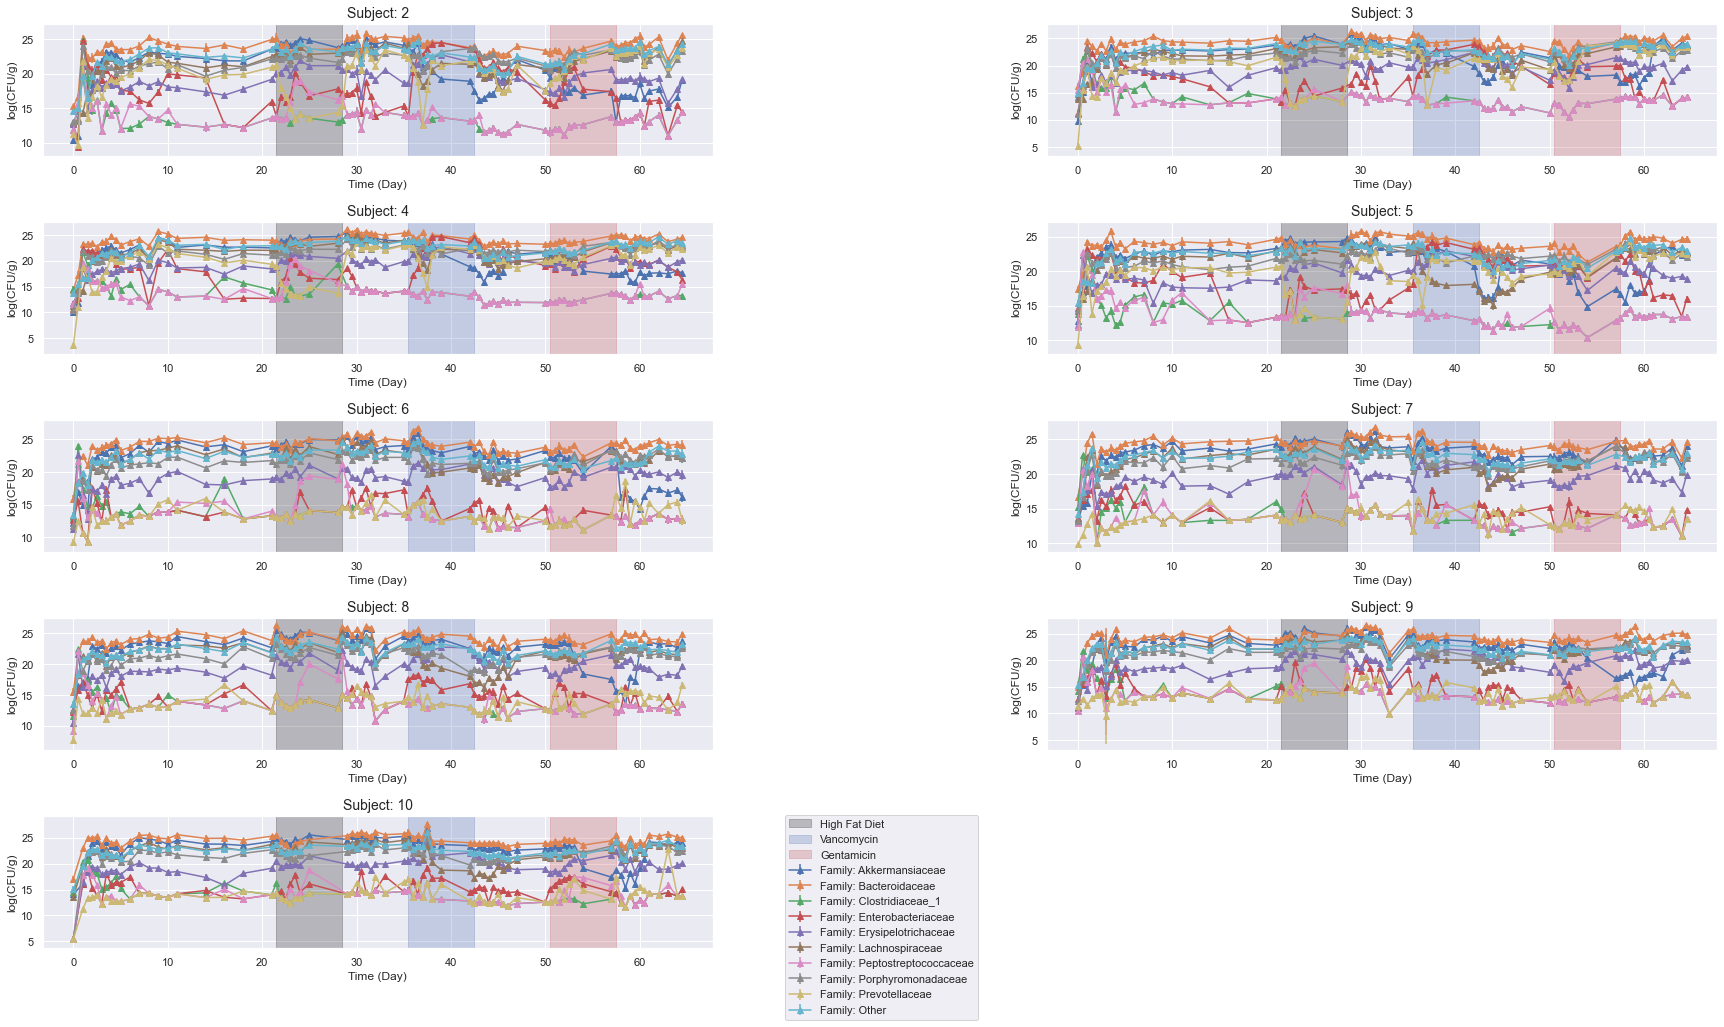

In [241]:
plt.figure(figsize=(30,17))
gs  = gridspec.GridSpec(5, 2)
gs.update(wspace=0.5, hspace=0.5)

for s_num in range(2, 11):
    subplt = plt.subplot(gs[s_num - 2])
    
    for indx, row in relative_abundance_f_filtered.iterrows():
        samples = list(qPCR_family.loc[qPCR_family['subject'] == s_num]['sampleID'])
        time = list(qPCR_family.loc[qPCR_family['subject'] == s_num]['time'])
        mean_log = list(qPCR_family.loc[qPCR_family['subject'] == s_num][row['Family']])
        std_log = list(qPCR_family.loc[qPCR_family['subject'] == s_num]['std_log'])

        plt.errorbar(time, mean_log, std_log, marker = '^', label = f'Family: {row["Family"]}')

    # pertubations
    plt.axvspan(21.5, 28.5, color='k', alpha=0.25, label = 'High Fat Diet')
    plt.axvspan(35.5, 42.5, color='b', alpha=0.25, label = 'Vancomycin')
    plt.axvspan(50.5, 57.5, color='r', alpha=0.25,  label = 'Gentamicin')

    plt.ylabel('log(CFU/g)')
    plt.xlabel('Time (Day)')
    plt.title(f'Subject: {s_num}', fontsize = 14)

plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()

The above graphs depict how the log of (CFU/g) changes for each of the subjects across time (in days). In general, we observe that for each subject, these families of bacteria move similarly across time. The results do vary somewhat for the different subjects. In particular, Peptostreptococcaceae (the orange triangles) seems to have one of the lowest log(CFU/g) outputs across time (around 15), although it does appear to rise to about 20 when the mice are subjected to a high fat diet. This is most obvious in subjects 2-5. In subjects 6-10 this does still appear to be the case, even though the output appears to fluctuate more, and several other bacterial families also dip to that range. This could be because subjects 6-10 are the unhealthy mice, while 2-5 are the healthy mice. More generally, it appears that in the healthy mice (subjects 2-5), overall the log(CFU/g) output for the different bacterial families tends to be higher than in the unhealthy mice. More bacterial families seem to produce log(CFU/g) below 15 in the unhealthy mice than in the healthy mice.  

There are also several families of bacteria that are not particularly affected by the subjects being healthy or unhealthy. One such example is the family Bacteroidaceae (orange triangles), which appears to have some of the highest (CFU/g) output across all the subjects across time. There are some interesting trends with this bacterial family, however. For one, it appears that in subjects 2-5 (the healthy mice), the production decreases slightly when the subjects are on the antibiotic Vancomycin. This is most evident in subject 5, though the trend occurs in all the healthy subjects. However, in subjects 6-10, this is not the case. In fact, the opposite occurs, and we see that when the subjects are on Vancomycin, the production stays at about the same level, and in fact appears to increase at times. This all leads us to conclude that there are some obvious distinctions between the healthy and unhealthy mice, and moreover it suggests that the antibiotics affect the two populations somewhat differently.

More generally, we can now understand the rough effects of the three permutations in the subjects’ system (high fat diet, Vancomycin, and Gentamicin). As we observed above, the antibiotic Vancomycin affects the log(CFU/g) output of the various bacterial families differently across subjects. We can see that the family Prevotellaceae (light-green triangles) appears to decrease its production under the antibiotic Vancomycin in the healthy mice, but to increase its production in the unhealthy mice, at least at first. We can see that in subjects 2-5 (healthy mice), for example, the output starts decreasing immediately when the subject receives Vancomycin, whereas in subjects 6 and 10 (unhealthy mice) the output at least has a slight increase. This appears to actually be an example of a broader trend. It seems that Vancomycin improves production for almost all bacterial families for the unhealthy mice, and has very little effect on healthy mice (it actually negatively affects some of the families’ output). This spike in production when Vancomycin is first introduced into the environment is most apparent in subjects 6, 7, and 10. Gentamicin appears to have less of an affect on log(CFU/g) for any of the bacterial families across the different subjects. It does appear to increase production for some bacterial families, like Bacteroidaceae (orange), most apparently in subjects 2, 5, 6, 7, 8, amongst others, but there doesn’t appear to be a very clearly defined trend across the different subjects for several bacterial families.

Overall, it seems that in the healthy mice samples (subjects 2-5), most of the bacterial families produce a higher log(CFU/g) , usually above 15, than in the unhealthy mice (subjects 6-10). It also seems like Vancomycin has more of an effect on the unhealthy mouse population, as most of the bacterial families appear to spike in terms of how much CFU they produce, whereas in the healthy mouse population it does not really seem to affect much of the production.

### Visualized Perturbations' Effect on Bacteria Families' qPCR Concentration Separated by Family

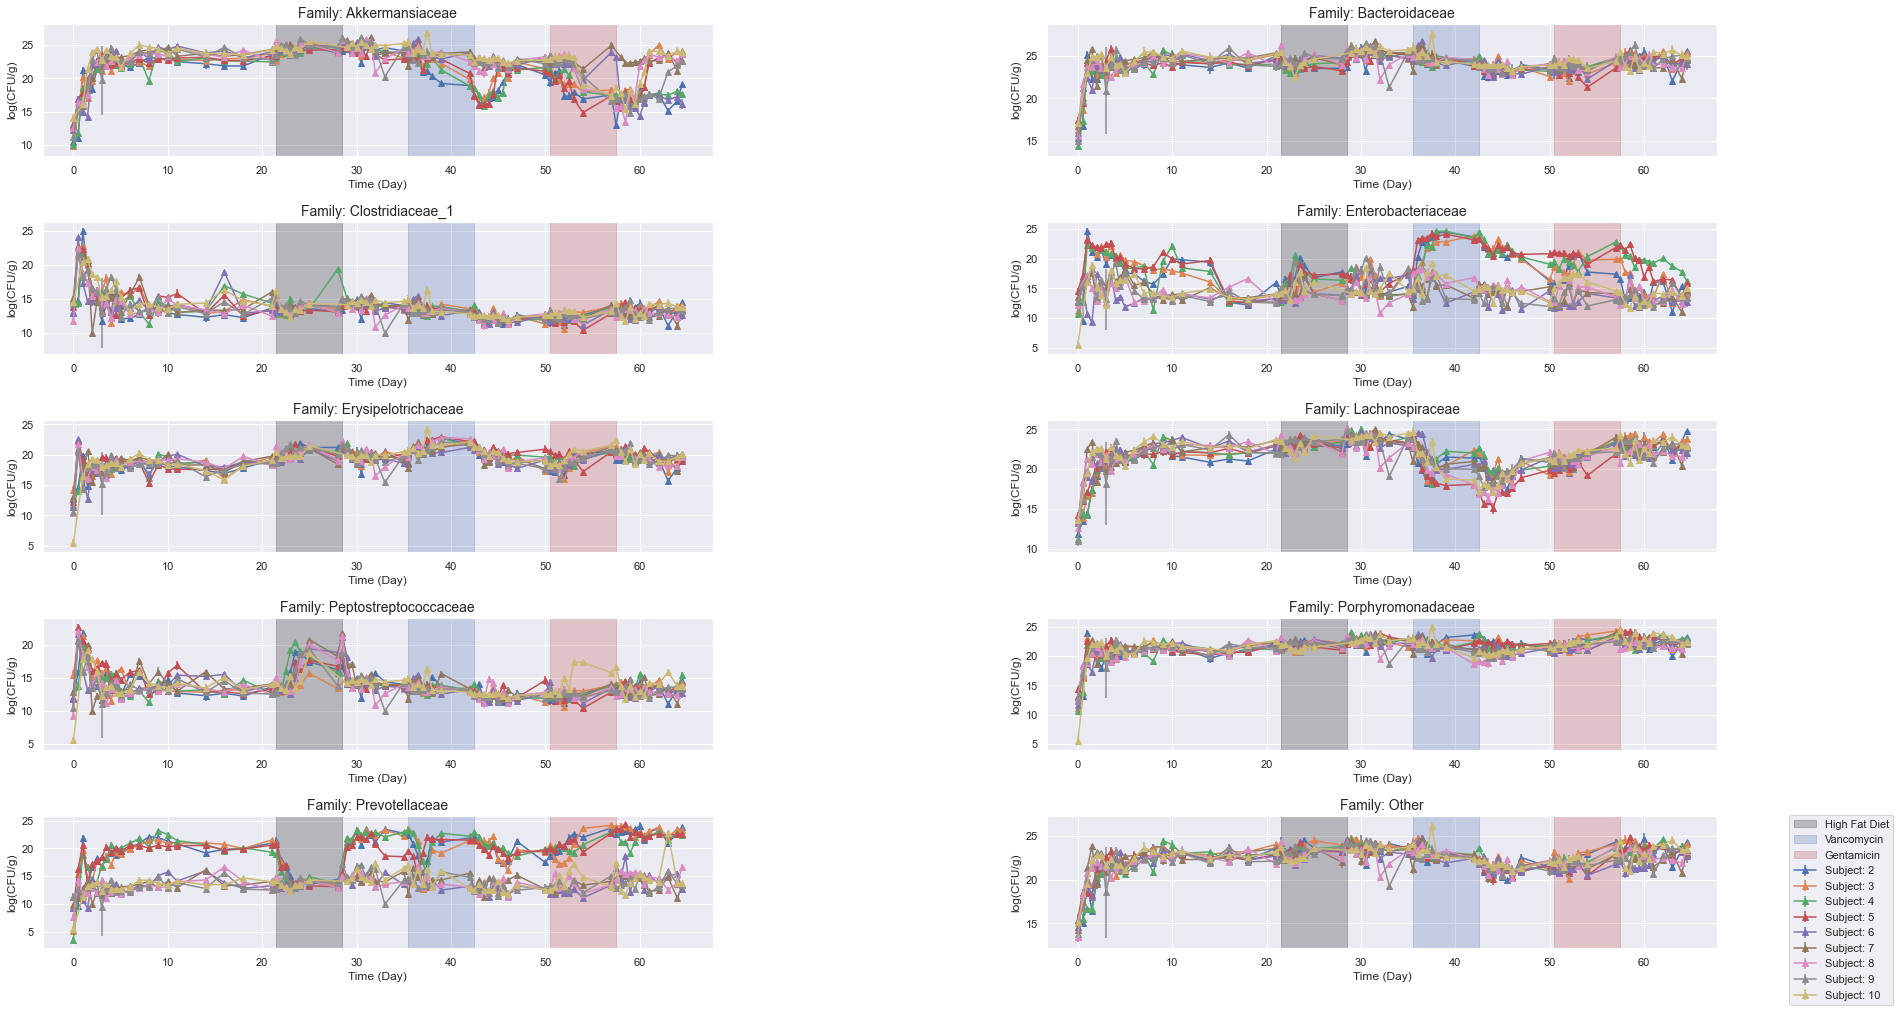

In [242]:
plt.figure(figsize=(30,17))
gs  = gridspec.GridSpec(5, 2)
gs.update(wspace=0.5, hspace=0.5)

for indx, row in relative_abundance_f_filtered.iterrows():    
    family_name = row['Family']
    
    subplt = plt.subplot(gs[indx])
    
    for s_num in range(2, 11):
        samples = list(qPCR_family.loc[qPCR_family['subject'] == s_num]['sampleID'])
        time = list(qPCR_family.loc[qPCR_family['subject'] == s_num]['time'])
        mean_log = list(qPCR_family.loc[qPCR_family['subject'] == s_num][row['Family']])
        std_log = list(qPCR_family.loc[qPCR_family['subject'] == s_num]['std_log'])

        plt.errorbar(time, mean_log, std_log, marker = '^', label = f'Subject: {s_num}')

    # pertubations
    plt.axvspan(21.5, 28.5, color='k', alpha=0.25, label = 'High Fat Diet')
    plt.axvspan(35.5, 42.5, color='b', alpha=0.25, label = 'Vancomycin')
    plt.axvspan(50.5, 57.5, color='r', alpha=0.25,  label = 'Gentamicin')

    plt.ylabel('log(CFU/g)')
    plt.xlabel('Time (Day)')
    plt.title(f'Family: {row["Family"]}', fontsize = 14)

plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()

These graphs give us a better way to visualize the effects of the three permutations (high fat diet, Vancomycin, Gentamicin) on the different families across time. It also lets us view the analysis from above differently. For example, the family Peptostreptococcaceae appears to have fairly low CFU production, with log(CFU/g) roughly around 15 for most of the duration of the trial. When the subjects are undergoing a high fat diet, however, it looks like CFU production increased for all of the subjects. While some subjects responded more strongly than others, it appears that a high fat diet clearly affects CFU production for the Peptostreptococcaceae family of bacteria. By contrast, Bacteroidaceae is a bacterial family that fairly consistently produces high amounts of CFU, with a log(CFU/g) value generally around 20.

We can note some other interesting trends that were less obvious in the previous set of plots. For example, it looks like some families of bacteria are more drastically affected by whether the subject is healthy or unhealthy. We can see that the family Prevotellaceae seems to very clearly produce more CFU in healthy subjects than in unhealthy subjects, at certain points in time. In the unhealthy subjects, their log(CFU/g) production is around 15, while in healthy subjects it’s about 20 at times. In the Prevotellaceae family, however, there is the interesting observation that under a high fat diet, the production levels in healthy mice decrease to the same level as in unhealthy mice. This is all to signify that some families appear to be more affected by the health status of their hosts than others.
We can also clearly see that some families are more seriously affected by the antibiotics than others. In particular, the family Lachnospiraceae appears to drastically decrease their production of CFU under Vancomycin, whereas the family Erysipelotrichaceae appears to slightly increase production across all subjects when Vancomycin is applied to the host environment. Some of the other families also appear to increase CFU production slightly when subjected to Gentamicin, even though the production decreased under Vancomycin for some subjects.

It also appears to be the case that some families respond differently to the antibiotics depending on whether their host was a healthy mouse or an unhealthy one. In the family Enterobacteriaceae, the healthy subjects increase their production drastically in healthy mice that receive Vancomycin, and the production also appears to be somewhat greater for Gentamicin as well.

Overall, there does not appear to be a particularly clear trend for how the three perturbations affect CFU in various bacterial families. However, it does look like in a lot of the families the changing trends in CFU production is fairly similar across the different subjects, except for the examples mentioned above. Furthermore, it does appear that some families are more affected by the antibiotics (in particular, Vancomycin) than others, and it seems that the antibiotics affect production differently depending on whether the subject is healthy or unhealthy. 

### Relative Abundance of Microbial Taxonomies Grouped by Family

Let us take the look at **changes in UC cohort subject #10's microbiome** and **changes in healthy cohort subject #2's microbiome**.

In [243]:
# Subject 10's metadata
s10_metadata = metadata.loc[metadata['subject'] == 10].sort_values(by=['time']).reset_index()

# Perturbations
s10_perturbations = perturbations.loc[perturbations['subject'] == 10].reset_index()

# Subject 2's metadata
s2_metadata = metadata.loc[metadata['subject'] == 2].sort_values(by=['time']).reset_index()

# Perturbations
s2_perturbations = perturbations.loc[perturbations['subject'] == 2].reset_index()

In [244]:
print('Subject 10 Pertubation Info:')
s10_perturbations

Subject 10 Pertubation Info:


index           name  start   end  subject
0      8  High Fat Diet   21.5  28.5       10
1     17     Vancomycin   35.5  42.5       10
2     26     Gentamicin   50.5  57.5       10

In [245]:
print('Subject 2 Pertubation Info:')
s2_perturbations

Subject 2 Pertubation Info:


index           name  start   end  subject
0      0  High Fat Diet   21.5  28.5        2
1      9     Vancomycin   35.5  42.5        2
2     18     Gentamicin   50.5  57.5        2

In [246]:
# Get all the info needed for the two subjects
s10_info = relative_abundance_f_filtered[np.append(['Family'],s10_metadata['sampleID'])]
s2_info = relative_abundance_f_filtered[np.append(['Family'],s2_metadata['sampleID'])]

# Categorize based on period
# 1: Before any perturbation
# 2: During high fat diet
# 3: After high fat diet
# 4: During Vancomycin
# 5: After Vancomycin
# 6: During Gentamicin
# 7: After Gentamicin

# Subject 10
samples = s10_info.columns[1:]
idx1 = s10_metadata.loc[s10_metadata['time'] == s10_perturbations['start'][0]].index[0]
# added 0.5 for idx2 because next sample starts at time 29.0
idx2 = s10_metadata.loc[s10_metadata['time'] == s10_perturbations['end'][0] + 0.5].index[0]
idx3 = s10_metadata.loc[s10_metadata['time'] == s10_perturbations['start'][1]].index[0]
idx4 = s10_metadata.loc[s10_metadata['time'] == s10_perturbations['end'][1]].index[0]
idx5 = s10_metadata.loc[s10_metadata['time'] == s10_perturbations['start'][2]].index[0]
idx6 = s10_metadata.loc[s10_metadata['time'] == s10_perturbations['end'][2]].index[0]

s10_info_1 = s10_info[np.append(['Family'], samples[:idx1])]
s10_info_2 = s10_info[np.append(['Family'], samples[idx1:idx2])]
s10_info_3 = s10_info[np.append(['Family'], samples[idx2:idx3])]
s10_info_4 = s10_info[np.append(['Family'], samples[idx3:idx4])]
s10_info_5 = s10_info[np.append(['Family'], samples[idx4:idx5])]
s10_info_6 = s10_info[np.append(['Family'], samples[idx5:idx6])]
s10_info_7 = s10_info[np.append(['Family'], samples[idx6:])]

# Subject 2
samples = s2_info.columns[1:]
idx1 = s2_metadata.loc[s2_metadata['time'] == s2_perturbations['start'][0]].index[0]
idx2 = s2_metadata.loc[s2_metadata['time'] == s2_perturbations['end'][0]].index[0]
idx3 = s2_metadata.loc[s2_metadata['time'] == s2_perturbations['start'][1]].index[0]
idx4 = s2_metadata.loc[s2_metadata['time'] == s2_perturbations['end'][1]].index[0]
idx5 = s2_metadata.loc[s2_metadata['time'] == s2_perturbations['start'][2]].index[0]
idx6 = s2_metadata.loc[s2_metadata['time'] == s2_perturbations['end'][2]].index[0]


s2_info_1 = s2_info[np.append(['Family'], samples[:idx1])]
s2_info_2 = s2_info[np.append(['Family'], samples[idx1:idx2])]
s2_info_3 = s2_info[np.append(['Family'], samples[idx2:idx3])]
s2_info_4 = s2_info[np.append(['Family'], samples[idx3:idx4])]
s2_info_5 = s2_info[np.append(['Family'], samples[idx4:idx5])]
s2_info_6 = s2_info[np.append(['Family'], samples[idx5:idx6])]
s2_info_7 = s2_info[np.append(['Family'], samples[idx6:])]

In [248]:
# Print cutoff times
print('Subject 10 Cutoff Times:')
print('idx1: Day', s10_metadata.iloc[idx1].time)
print('idx2: Day', s10_metadata.iloc[idx2].time)
print('idx3: Day', s10_metadata.iloc[idx3].time)
print('idx4: Day', s10_metadata.iloc[idx4].time)
print('idx5: Day', s10_metadata.iloc[idx5].time)
print('idx6: Day', s10_metadata.iloc[idx6].time)

print('\nSubject 2 Cutoff Times:')
print('idx1: Day', s2_metadata.iloc[idx1].time)
print('idx2: Day', s2_metadata.iloc[idx2].time)
print('idx3: Day', s2_metadata.iloc[idx3].time)
print('idx4: Day', s2_metadata.iloc[idx4].time)
print('idx5: Day', s2_metadata.iloc[idx5].time)
print('idx6: Day', s2_metadata.iloc[idx6].time)

Subject 10 Cutoff Times:
idx1: Day 22.0
idx2: Day 30.0
idx3: Day 37.0
idx4: Day 44.0
idx5: Day 52.0
idx6: Day 59.0

Subject 2 Cutoff Times:
idx1: Day 21.5
idx2: Day 28.5
idx3: Day 35.5
idx4: Day 42.5
idx5: Day 50.5
idx6: Day 57.5


In [249]:
# Change column names from sample id to time (day)
s10_info_1 = s10_info_1.rename(dict(zip(s10_info_1.columns[1:], list(metadata.loc[metadata['sampleID'].isin(s10_info_1), 'time']))), axis='columns').drop('Family', axis=1)
s10_info_2 = s10_info_2.rename(dict(zip(s10_info_2.columns[1:], list(metadata.loc[metadata['sampleID'].isin(s10_info_2), 'time']))), axis='columns').drop('Family', axis=1)
s10_info_3 = s10_info_3.rename(dict(zip(s10_info_3.columns[1:], list(metadata.loc[metadata['sampleID'].isin(s10_info_3), 'time']))), axis='columns').drop('Family', axis=1)
s10_info_4 = s10_info_4.rename(dict(zip(s10_info_4.columns[1:], list(metadata.loc[metadata['sampleID'].isin(s10_info_4), 'time']))), axis='columns').drop('Family', axis=1)
s10_info_5 = s10_info_5.rename(dict(zip(s10_info_5.columns[1:], list(metadata.loc[metadata['sampleID'].isin(s10_info_5), 'time']))), axis='columns').drop('Family', axis=1)
s10_info_6 = s10_info_6.rename(dict(zip(s10_info_6.columns[1:], list(metadata.loc[metadata['sampleID'].isin(s10_info_6), 'time']))), axis='columns').drop('Family', axis=1)
s10_info_7 = s10_info_7.rename(dict(zip(s10_info_7.columns[1:], list(metadata.loc[metadata['sampleID'].isin(s10_info_7), 'time']))), axis='columns').drop('Family', axis=1)

s2_info_1 = s2_info_1.rename(dict(zip(s2_info_1.columns[1:], list(metadata.loc[metadata['sampleID'].isin(s2_info_1), 'time']))), axis='columns').drop('Family', axis=1)
s2_info_2 = s2_info_2.rename(dict(zip(s2_info_2.columns[1:], list(metadata.loc[metadata['sampleID'].isin(s2_info_2), 'time']))), axis='columns').drop('Family', axis=1)
s2_info_3 = s2_info_3.rename(dict(zip(s2_info_3.columns[1:], list(metadata.loc[metadata['sampleID'].isin(s2_info_3), 'time']))), axis='columns').drop('Family', axis=1)
s2_info_4 = s2_info_4.rename(dict(zip(s2_info_4.columns[1:], list(metadata.loc[metadata['sampleID'].isin(s2_info_4), 'time']))), axis='columns').drop('Family', axis=1)
s2_info_5 = s2_info_5.rename(dict(zip(s2_info_5.columns[1:], list(metadata.loc[metadata['sampleID'].isin(s2_info_5), 'time']))), axis='columns').drop('Family', axis=1)
s2_info_6 = s2_info_6.rename(dict(zip(s2_info_6.columns[1:], list(metadata.loc[metadata['sampleID'].isin(s2_info_6), 'time']))), axis='columns').drop('Family', axis=1)
s2_info_7 = s2_info_7.rename(dict(zip(s2_info_7.columns[1:], list(metadata.loc[metadata['sampleID'].isin(s2_info_7), 'time']))), axis='columns').drop('Family', axis=1)

In [251]:
# Sort columns in ascending order
s10_info_1 = s10_info_1.reindex(sorted(s10_info_1.columns), axis=1)
s10_info_2 = s10_info_2.reindex(sorted(s10_info_2.columns), axis=1)
s10_info_3 = s10_info_3.reindex(sorted(s10_info_3.columns), axis=1)
s10_info_4 = s10_info_4.reindex(sorted(s10_info_4.columns), axis=1)
s10_info_5 = s10_info_5.reindex(sorted(s10_info_5.columns), axis=1)
s10_info_6 = s10_info_6.reindex(sorted(s10_info_6.columns), axis=1)
s10_info_7 = s10_info_7.reindex(sorted(s10_info_7.columns), axis=1)

s2_info_1 = s2_info_1.reindex(sorted(s2_info_1.columns), axis=1)
s2_info_2 = s2_info_2.reindex(sorted(s2_info_2.columns), axis=1)
s2_info_3 = s2_info_3.reindex(sorted(s2_info_3.columns), axis=1)
s2_info_4 = s2_info_4.reindex(sorted(s2_info_4.columns), axis=1)
s2_info_5 = s2_info_5.reindex(sorted(s2_info_5.columns), axis=1)
s2_info_6 = s2_info_6.reindex(sorted(s2_info_6.columns), axis=1)
s2_info_7 = s2_info_7.reindex(sorted(s2_info_7.columns), axis=1)

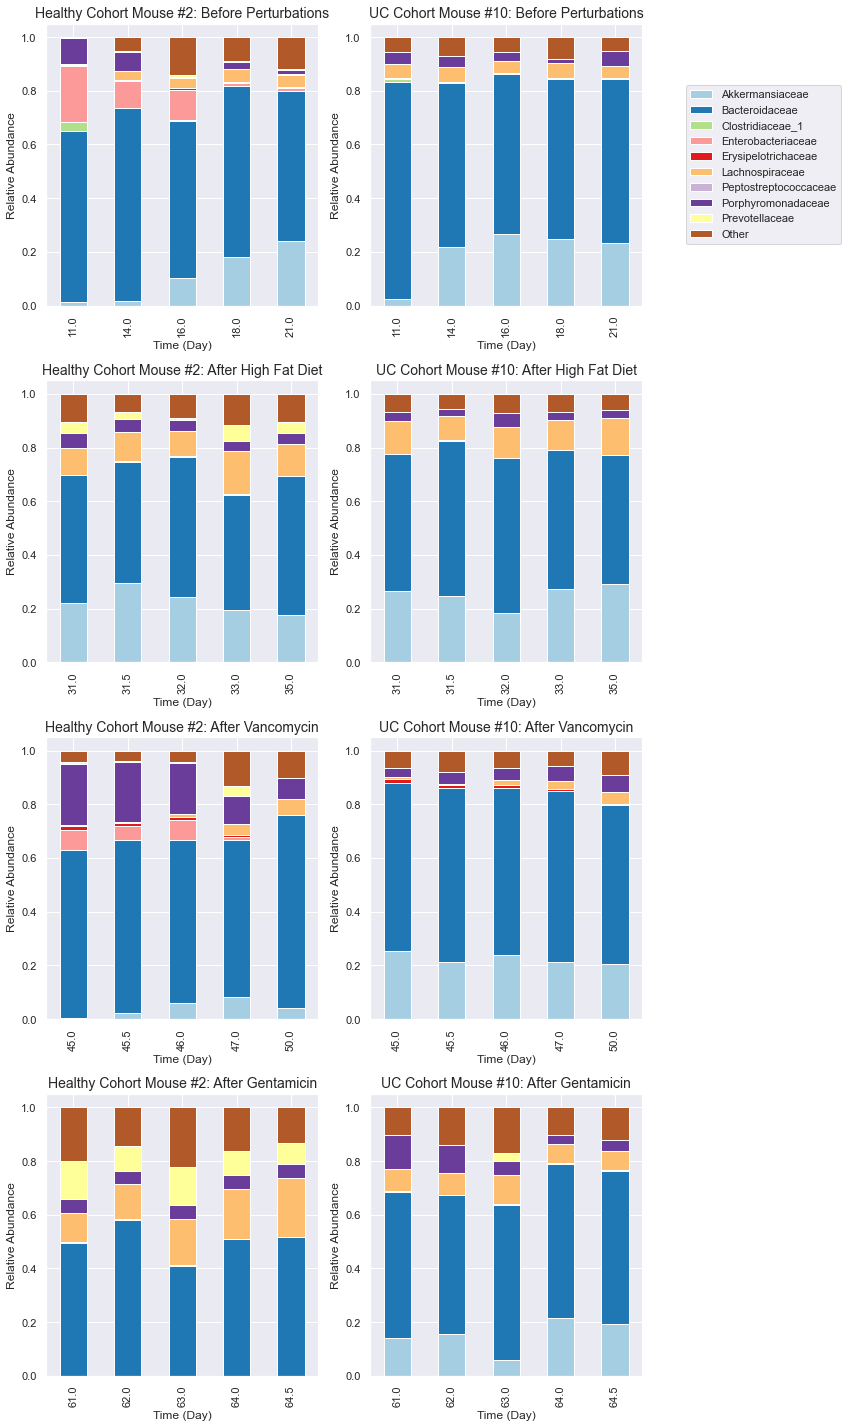

In [252]:
# Plot
sns.set()
sns.set_theme()
num_sample_to_display = 5

fig, axes = plt.subplots(4,2, figsize = (12, 20))

# State 1: Before Pertubations
# Subject 2
s2_info_1.set_index(families)[s2_info_1.columns[-num_sample_to_display:]].T.plot(kind='bar', 
                                                                                 stacked=True, 
                                                                                 colormap='Paired',
                                                                                 ax = axes[0,0],
                                                                                 legend=False)

axes[0,0].set_title('Healthy Cohort Mouse #2: Before Perturbations',fontsize = 14)
axes[0,0].set_ylabel('Relative Abundance')
axes[0,0].set_xlabel('Time (Day)');

# Subject 10
s10_info_1.set_index(families)[s10_info_1.columns[-num_sample_to_display:]].T.plot(kind='bar', stacked=True, 
                                                                                   colormap='Paired',
                                                                                   ax = axes[0,1],
                                                                                   legend=True).legend(loc='center right',
                                                                                                       bbox_to_anchor=(1.75, 0.5))


axes[0,1].set_title('UC Cohort Mouse #10: Before Perturbations',fontsize = 14)
axes[0,1].set_ylabel('Relative Abundance')
axes[0,1].set_xlabel('Time (Day)');

# State 2: After High Fat Diet
# Subject 2
s2_info_3.set_index(families)[s2_info_3.columns[-num_sample_to_display:]].T.plot(kind='bar', 
                                                                                 stacked=True, 
                                                                                 colormap='Paired',
                                                                                 ax = axes[1,0],
                                                                                 legend=False)

axes[1,0].set_title('Healthy Cohort Mouse #2: After High Fat Diet',fontsize = 14)
axes[1,0].set_ylabel('Relative Abundance')
axes[1,0].set_xlabel('Time (Day)');

# Subject 10
s10_info_3.set_index(families)[s10_info_3.columns[-num_sample_to_display:]].T.plot(kind='bar', stacked=True, 
                                                                                   colormap='Paired',
                                                                                   ax = axes[1,1],
                                                                                   legend=False)


axes[1,1].set_title('UC Cohort Mouse #10: After High Fat Diet',fontsize = 14)
axes[1,1].set_ylabel('Relative Abundance')
axes[1,1].set_xlabel('Time (Day)');

fig.tight_layout()

# State 3: After Vancomycin
# Subject 2
s2_info_5.set_index(families)[s2_info_5.columns[-num_sample_to_display:]].T.plot(kind='bar', 
                                                                                 stacked=True, 
                                                                                 colormap='Paired',
                                                                                 ax = axes[2,0],
                                                                                 legend=False)

axes[2,0].set_title('Healthy Cohort Mouse #2: After Vancomycin',fontsize = 14)
axes[2,0].set_ylabel('Relative Abundance')
axes[2,0].set_xlabel('Time (Day)');

# Subject 10
s10_info_5.set_index(families)[s10_info_5.columns[-num_sample_to_display:]].T.plot(kind='bar', stacked=True, 
                                                                                   colormap='Paired',
                                                                                   ax = axes[2,1],
                                                                                   legend=False)


axes[2,1].set_title('UC Cohort Mouse #10: After Vancomycin',fontsize = 14)
axes[2,1].set_ylabel('Relative Abundance')
axes[2,1].set_xlabel('Time (Day)');

fig.tight_layout()

# State 4: After Vancomycin
# Subject 2
s2_info_7.set_index(families)[s2_info_7.columns[-num_sample_to_display:]].T.plot(kind='bar', 
                                                                                 stacked=True, 
                                                                                 colormap='Paired',
                                                                                 ax = axes[3,0],
                                                                                 legend=False)

axes[3,0].set_title('Healthy Cohort Mouse #2: After Gentamicin',fontsize = 14)
axes[3,0].set_ylabel('Relative Abundance')
axes[3,0].set_xlabel('Time (Day)');

# Subject 10
s10_info_7.set_index(families)[s10_info_7.columns[-num_sample_to_display:]].T.plot(kind='bar', stacked=True, 
                                                                                   colormap='Paired',
                                                                                   ax = axes[3,1],
                                                                                   legend=False)


axes[3,1].set_title('UC Cohort Mouse #10: After Gentamicin',fontsize = 14)
axes[3,1].set_ylabel('Relative Abundance')
axes[3,1].set_xlabel('Time (Day)');

fig.tight_layout()

In the figure above, we observe the relative abundance of these families for the selected Mouse #2 from the healthy cohort and for Mouse #10 from the UC cohort at 4 different states: 1) before perturbations, 2) after the high fat diet, 3) after the Vancomycin perturbation, 4) and after the Gentamicin perturbation. The effects of the perturbations appear to be more drastic on the microbiomes of healthy cohort Mouse #2 versus UC cohort Mouse #10. Specifically, in state #1, before perturbations, we see that UC cohort Mouse #10 appears to have a greater share of microorganisms from the Akkermansiaceae and Lachnospiraceae families compared to healthy cohort Mouse #2. In state #2, we observe that a high fat diet increases the abundance of microorganisms of family Akkermansiaceae and family Lachnospiraceae for Mouse #2. There appears to be a slight increase in abundance from those two families for Mouse #10, but the effects are much less obvious. For state #3, after the Vancomycin perturbation, we observe that healthy cohort Mouse #2’s microbiome contains a higher share of Porphyromonadaceae and Enterobacteriaceae microorganisms (although on days 11, 14, and 16, there is a sizable proportion of Enterobacteriaceae microorganisms), with a decline of those from the Akkermansiaceae family. This result is supported by the literature (Isaac et al., 2017). Once again, there does not appear to be any significant change for Mouse #10’s microbiome in the bar chart. Finally, in state #4, after the Gentamicin perturbation, we observe that healthy cohort Mouse #2’s microbiome now consists of a larger proportion of microorganisms from the Lachnospiraceae and Prevotellaceae family with a significant decrease in microorganisms from the Akkermansiaceae family. For UC cohort Mouse #10, there appears to be some increase in the share of microorganisms from the Porphyromonadaceae family.

### A look at the log(CFU/g) for Akkermansia muciniphila for the 9 mice over the length of the experiment

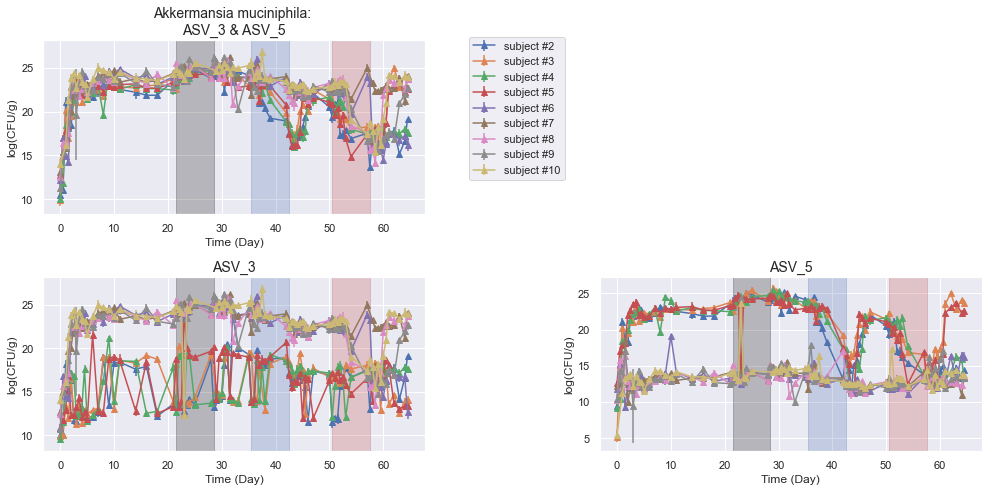

In [154]:
fig, axes = plt.subplots(2,2,figsize=(14,7))

bugs = ['ASV_3', 'ASV_5']

# iterate through the subject numbers
for s_num in range(2,11):
    samples = list(qPCR_more.loc[qPCR_more['subject'] == s_num]['sampleID'])
    time = list(qPCR_more.loc[qPCR_more['subject'] == s_num]['time'])
    mean_log = list(qPCR_more.loc[qPCR_more['subject'] == s_num]['mean_log'])
    std_log = list(qPCR_more.loc[qPCR_more['subject'] == s_num]['std_log'])
    
    # scale by relative abundance
    for idx, sample in enumerate(samples):
        # relative abundance
        ra = float(relative_abundance_filtered.loc[(relative_abundance_filtered['Name'] == bugs[0]), sample])
        ra += float(relative_abundance_filtered.loc[(relative_abundance_filtered['Name'] == bugs[1]), sample])
        
        mean_log[idx] = mean_log[idx] + np.log(ra) # add because log(qpcr * ra) = log(qpcr) + log(ra)
        std_log[idx] = std_log[idx]
    
    axes[0,0].errorbar(time, mean_log, std_log, marker = '^', label = f'subject #{s_num}')

# formatting
axes[0,0].set_ylabel('log(CFU/g)')
axes[0,0].set_xlabel('Time (Day)')
axes[0,0].set_title(f'Akkermansia muciniphila: \n{bugs[0]} & {bugs[1]}', fontsize = 14)
axes[0,0].legend(bbox_to_anchor=(1.1, 1.05))
    
# iterate through the subject numbers
for col in range(2):
    for s_num in range(2,11):
        samples = list(qPCR_more.loc[qPCR_more['subject'] == s_num]['sampleID'])
        time = list(qPCR_more.loc[qPCR_more['subject'] == s_num]['time'])
        mean_log = list(qPCR_more.loc[qPCR_more['subject'] == s_num]['mean_log'])
        std_log = list(qPCR_more.loc[qPCR_more['subject'] == s_num]['std_log'])

        # scale by relative abundance
        for idx, sample in enumerate(samples):
            # relative abundance
            ra = float(relative_abundance_filtered.loc[(relative_abundance_filtered['Name'] == bugs[col]), sample])

            mean_log[idx] = mean_log[idx] + np.log(ra) # add because log(qpcr * ra) = log(qpcr) + log(ra)
            std_log[idx] = std_log[idx]

        axes[1,col].errorbar(time, mean_log, std_log, marker = '^', label = f'subject #{s_num}')
    # formatting
    axes[1,col].set_ylabel('log(CFU/g)')
    axes[1,col].set_xlabel('Time (Day)')
    axes[1,col].set_title(f'{bugs[col]}', fontsize = 14)
    
    axes[1,col].axvspan(21.5, 28.5, color='k', alpha=0.25, label = 'High Fat Diet')
    axes[1,col].axvspan(35.5, 42.5, color='b', alpha=0.25, label = 'Vancomycin')
    axes[1,col].axvspan(50.5, 57.5, color='r', alpha=0.25,  label = 'Gentamicin')

# perturbations
axes[0,0].axvspan(21.5, 28.5, color='k', alpha=0.25, label = 'High Fat Diet')
axes[0,0].axvspan(35.5, 42.5, color='b', alpha=0.25, label = 'Vancomycin')
axes[0,0].axvspan(50.5, 57.5, color='r', alpha=0.25,  label = 'Gentamicin')

fig.tight_layout()
fig.delaxes(axes[0,1])

In the figure above, we investigate the changes in the log absolute abundance (log(CFU/g)) of Akkermansia muciniphila for the 9 mice over the length of the experiment. The reason why we selected Akkermansia muciniphila to further examine was because it demonstrated the greatest changes during and after the perturbations, as seen in the following two figures. In our dataset, Akkermansia muciniphila appears twice under 2 distinct amplicon sequence variants (ASVs), that is ASV #3 and ASV #5. It appears that ASV #3 is more prevalent in UC individuals than healthy individuals, whereas ASV #5 is more prevalent in healthy individuals versus UC individuals. The high fat diet does not appear to have a significant impact on levels of Akkermansia muciniphila for either cohort. For the healthy cohort, there appears to be a decrease in levels of ASV #5 after the Vancomycin perturbation and Gentamicin perturbation. For the UC cohort, there appears to be a slight decrease in levels of ASV #3 after the Vancomycin and Gentamicin perturbations. With Vancomycin targeting gram-positive bugs and Akkermansia muciniphila being gram-negative, we would not expect Akkermansia muciniphila to decrease as a result of the Vancomycin perturbation. This suggests that there are downstream effects at play. For example, if cross-feeding from gram-positive bugs occurs, this could result in the decline of Akkermansia muciniphila that we have observed.

### log(CFU/g) levels for the 5 most prevalent microorganisms among the healthy cohort vs the UC cohort

In [49]:
# Legend
relative_abundance_filtered.iloc[:5][['Name', 'Class', 'Order', 'Genus', 'Species', 'Mean']]

Name             Class               Order        Genus  \
0  ASV_1       Bacteroidia       Bacteroidales  Phocaeicola   
1  ASV_2       Bacteroidia       Bacteroidales  Bacteroides   
2  ASV_3  Verrucomicrobiae  Verrucomicrobiales  Akkermansia   
3  ASV_4       Bacteroidia       Bacteroidales  Bacteroides   
4  ASV_5  Verrucomicrobiae  Verrucomicrobiales  Akkermansia   

                                    Species      Mean  
0                                       NaN  0.144238  
1                           fragilis/ovatus  0.138948  
2                               muciniphila  0.114443  
3  cellulosilyticus/intestinalis/timonensis  0.064083  
4                               muciniphila  0.048967

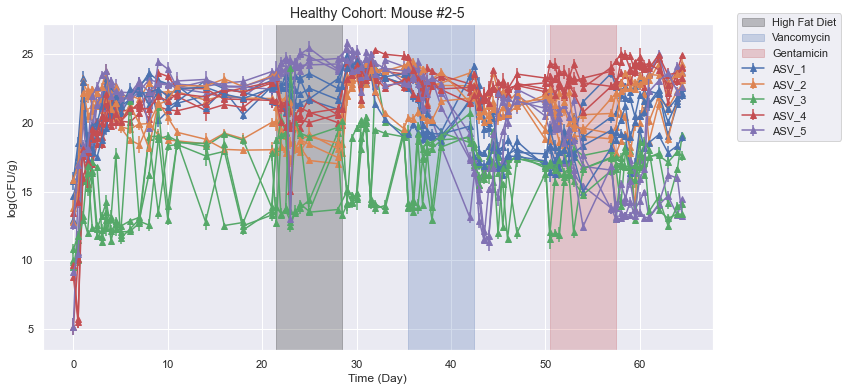

In [50]:
# Plot healthy cohort first
plt.figure(figsize=(12,6))

bugs = relative_abundance_filtered.iloc[:5]['Name']

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for s_num in range(2,6):
    for color_idx, bug in enumerate(bugs):
        samples = list(qPCR_more.loc[qPCR_more['subject'] == s_num]['sampleID'])
        time = list(qPCR_more.loc[qPCR_more['subject'] == s_num]['time'])
        mean_log = list(qPCR_more.loc[qPCR_more['subject'] == s_num]['mean_log'])
        std_log = list(qPCR_more.loc[qPCR_more['subject'] == s_num]['std_log'])

        # scale by relative abundance
        for idx, sample in enumerate(samples):
            # relative abundance
            ra = float(relative_abundance_filtered.loc[(relative_abundance_filtered['Name'] == bug), sample])

            mean_log[idx] = mean_log[idx] + np.log(ra) # add because log(qpcr * ra) = log(qpcr) + log(ra)
            std_log[idx] = std_log[idx]
        
        # include label for first iteration
        if s_num == 2:
            plt.errorbar(time, mean_log, std_log, marker = '^', label = bug, color = colors[color_idx])
        else:
            plt.errorbar(time, mean_log, std_log, marker = '^',color = colors[color_idx])

# perturbations
plt.axvspan(21.5, 28.5, color='k', alpha=0.25, label = 'High Fat Diet')
plt.axvspan(35.5, 42.5, color='b', alpha=0.25, label = 'Vancomycin')
plt.axvspan(50.5, 57.5, color='r', alpha=0.25,  label = 'Gentamicin')

# formatting
plt.ylabel('log(CFU/g)')
plt.xlabel('Time (Day)')
plt.title(f'Healthy Cohort: Mouse #2-5', fontsize = 14)
plt.legend(bbox_to_anchor=(1.2, 1.05))
    
plt.show()

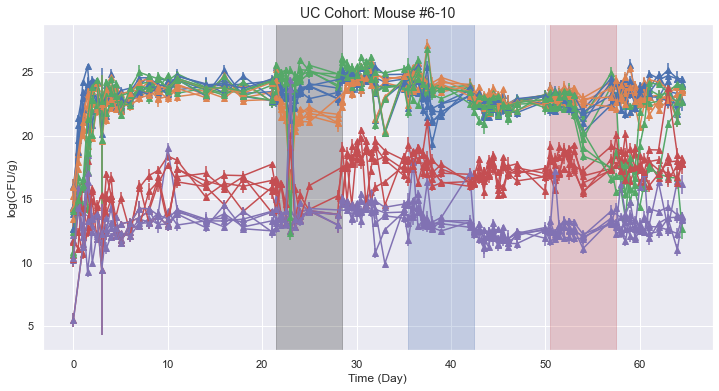

In [51]:
# Plot unhealthy cohort
plt.figure(figsize=(12,6))

bugs = relative_abundance_filtered.iloc[:5]['Name']

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for s_num in range(6,11):
    for color_idx, bug in enumerate(bugs):
        samples = list(qPCR_more.loc[qPCR_more['subject'] == s_num]['sampleID'])
        time = list(qPCR_more.loc[qPCR_more['subject'] == s_num]['time'])
        mean_log = list(qPCR_more.loc[qPCR_more['subject'] == s_num]['mean_log'])
        std_log = list(qPCR_more.loc[qPCR_more['subject'] == s_num]['std_log'])

        # scale by relative abundance
        for idx, sample in enumerate(samples):
            # relative abundance
            ra = float(relative_abundance_filtered.loc[(relative_abundance_filtered['Name'] == bug), sample])

            mean_log[idx] = mean_log[idx] + np.log(ra) # add because log(qpcr * ra) = log(qpcr) + log(ra)
            std_log[idx] = std_log[idx]
        
        # include label for first iteration
        if s_num == 2:
            plt.errorbar(time, mean_log, std_log, marker = '^', label = bug, color = colors[color_idx])
        else:
            plt.errorbar(time, mean_log, std_log, marker = '^',color = colors[color_idx])

# perturbations
plt.axvspan(21.5, 28.5, color='k', alpha=0.25, label = 'High Fat Diet')
plt.axvspan(35.5, 42.5, color='b', alpha=0.25, label = 'Vancomycin')
plt.axvspan(50.5, 57.5, color='r', alpha=0.25,  label = 'Gentamicin')

# formatting
plt.ylabel('log(CFU/g)')
plt.xlabel('Time (Day)')
plt.title(f'UC Cohort: Mouse #6-10', fontsize = 14)
    
plt.show()

In the current figure, we compare levels of the 5 most prevalent microorganisms among the healthy cohort versus the UC cohort. Aside from the 2 types of Akkermansia muciniphila, we observed a microbial taxa of the Phocaeicola genus and 2 microbial taxas from the Bacteroides genus. Looking at the most prevalent microorganism, that is ASV #1 from the Phocaeicola genus, we observe that Vancomycin appears to substantially decrease levels of this microorganism for the healthy cohort, in contrast to that of the UC cohort.

### t-SNE Dimensionality Reduction

In [52]:
# Copy the relative abundance for a given ASV sequence for a given sample and add a family column
relative_abundance_tsne = relative_abundance.copy()
relative_abundance_tsne = relative_abundance_tsne.drop(['Name'], axis = 1)

In [53]:
# Calculate absolute abundance for each ASV over the time series for tSNE plots
# Calculate the geometric mean of sample measurements
qpcr_tsne = qpcr.copy()
qpcr_tsne['geo_mean'] = (qpcr['measurement1'] *  qpcr['measurement2'] *  qpcr['measurement3']) ** (1/3)

# Transpose qPCR values so that samples are the columns and quantity is the single row
qpcr_tsne = pd.DataFrame(qpcr_tsne['geo_mean']).transpose()

print('Absolute abundance for each ASV over the time series:')
qpcr_tsne

Absolute abundance for each ASV over the time series:


0             1             2             3    \
geo_mean  3.541898e+07  1.026768e+11  2.082876e+11  9.954139e+10   

                   4             5             6             7    \
geo_mean  1.065833e+11  7.801122e+10  1.126221e+10  8.480518e+10   

                   8             9    ...           676           677  \
geo_mean  1.716080e+11  2.232570e+11  ...  3.067040e+10  6.395276e+10   

                   678           679           680           681  \
geo_mean  2.163359e+10  7.124783e+10  1.109379e+11  1.155211e+11   

                   682           683           684           685  
geo_mean  9.107228e+10  7.362940e+10  7.300566e+10  1.231710e+11  

[1 rows x 686 columns]

In [54]:
# Multiply every column of relative frequencies by the corresponding qPCR value to get absolute abundance
absolute_abundance_tsne = relative_abundance_tsne.multiply(np.array(qpcr_tsne), axis = 'columns')

# natural_log(qpcr * ra)
absolute_abundance_tsne = (np.log(absolute_abundance_tsne))

In [55]:
# TSNE
tsne_result = TSNE(n_components = 2, random_state=109).fit_transform(absolute_abundance_tsne)

#### Family:

In [56]:
# Add family to label the TSNE plot
absolute_abundance_tsne['Family'] = asv_and_taxonomy['Family']

# Change all the non-top 10 families to be labeled to Other for tsne chart label purposes
absolute_abundance_tsne.loc[~absolute_abundance_tsne['Family'].isin(['Akkermansiaceae', 'Bacteroidaceae', 'Clostridiaceae_1', 'Enterobacteriaceae',
                                    'Erysipelotrichaceae','Lachnospiraceae','Peptostreptococcaceae',
                                    'Porphyromonadaceae','Prevotellaceae']), 'Family'] = 'Other' 

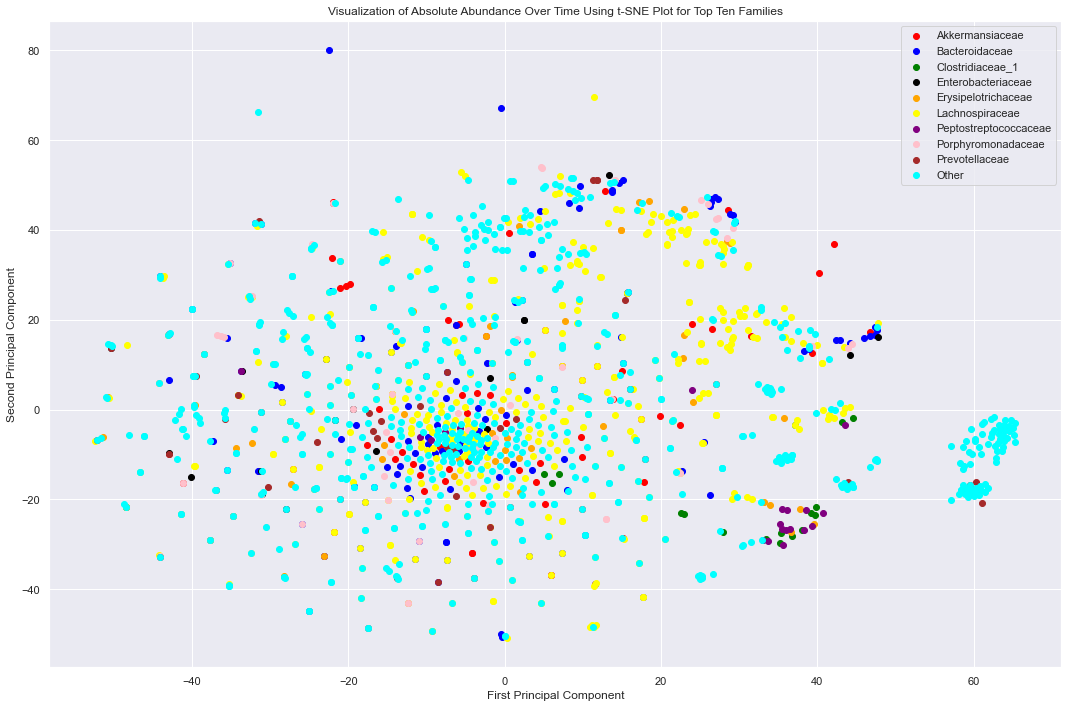

In [57]:
# Visualize absolute abundance over time with t-SNE for top 10 families
label_dict = {}
for count, family in enumerate(relative_abundance_f_filtered['Family']):
    label_dict[count] = family

color_dict = {0:'Red', 1: 'Blue', 2: 'Green', 3:'Black', 4:'Orange', 5: 'Yellow', 6: 'Purple', 7: 'Pink', 8:'Brown', 9:'Aqua'}


plt.figure(figsize = (15,10))
for count, g in enumerate(relative_abundance_f_filtered['Family']):
    index = np.where(absolute_abundance_tsne['Family'] == g)
    plt.scatter(tsne_result[:,0][index], tsne_result[:,1][index], color = color_dict[count], label = label_dict[count])

plt.title("Visualization of Absolute Abundance Over Time Using t-SNE Plot for Top Ten Families")
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.legend()
plt.tight_layout()
plt.show()

As stated in Section 6, "t-SNE tries to preserve local neighborhood structure from high dimensional space in low dimensional space by converting pairwise distances to pairwise joint distributions. Then using the KL divergence it tries to match the distributions". In other words t-SNE adapts its notion of distance to "regional density variations" in the data set. By using t-SNE, we embedded the high dimensional (686 dimension) space into two dimensions, and are able to capture non-linear transformations, which can be helpful in the context of time series.
In the graph above titled "Visualization of Absolute Abundance Over Time Using t-SNE Plot for Top Ten Families, “ we observe that the cloud of points are centered at first and second principal components equal to zero. Interestingly, the “Other” family taxonomical class that encompasses all families beyond the top nine families has an evenly spaced, oval, elongated shape along the east-west axis, yet there is a dense cluster of points in the right hand side which could represent closely related genera that respond similarly to perturbations over time, or could also correspond to points that did not have high absolute abundances throughout the experiment. 
Moreover, Lachnospiraceae colored in yellow and Peptostreptococcaceae colored in purple appear well clustered in some regions of the graph such as near first principal component equals 20 and second principal component equals 40, and near first principal component equals 40 and second principal component equals -20, respectively. 
Regardless, it is important to note that most of the colors appear well intermixed in the plot, which could indicate that our tsne may not adequately distinguish amongst the families. This makes sense given that we are doing a dimensionality reduction from 686 to 2.


#### Genus:

In [58]:
# TSNE Plot Labeled by Top 15 Genera
# Remove Family Column
absolute_abundance_tsne = absolute_abundance_tsne.drop(['Family'], axis = 1)

# Add genus to label the TSNE plot
absolute_abundance_tsne['Genus'] = asv_and_taxonomy['Genus']

# Change all the non-top 15 genera to be labeled to Other for tsne chart label purposes
absolute_abundance_tsne.loc[~absolute_abundance_tsne['Genus'].isin(['Akkermansia', 'Bacteroides',
                                                                  'Bilophila','Clostridium_sensu_stricto',
                                                                   'Enterocloster','Escherichia/Shigella',
                                                                   'Murimonas','Parabacteroides',
                                                                   'Paraprevotella','Parasutterella',
                                                                   'Phascolarctobacterium',
                                                                   'Phocaeicola',
                                                                   'Romboutsia',
                                                                   'Turicibacter',
                                                                   'Other']), 'Genus'] = 'Other' 

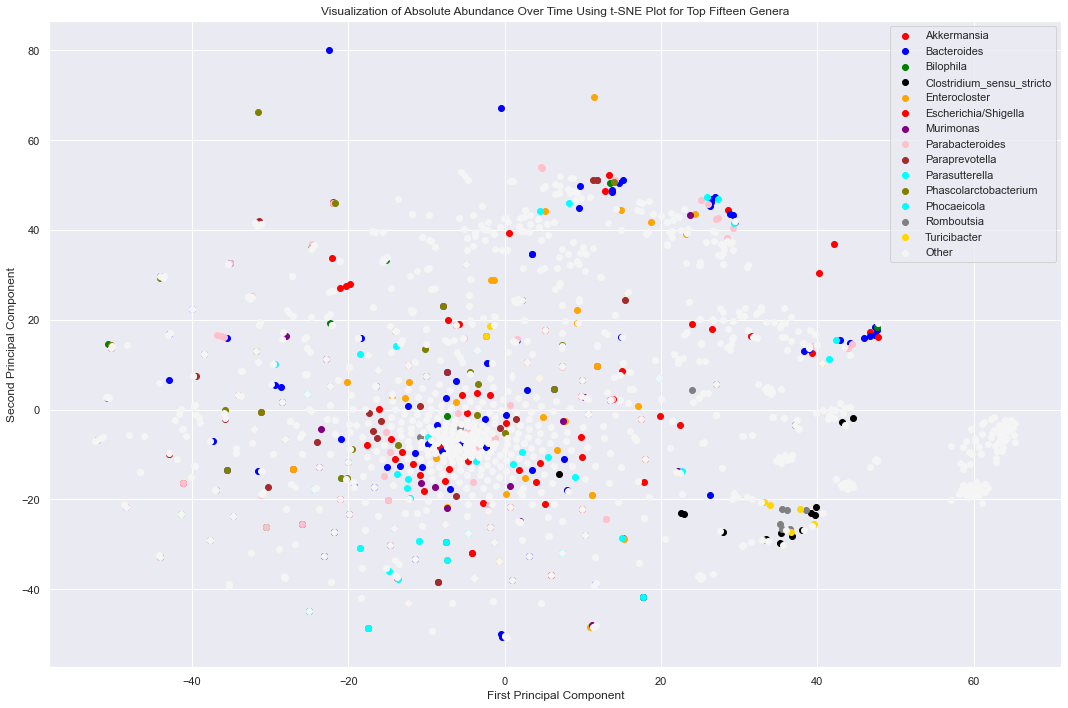

In [59]:
# Visualize absolute abundance over time with t-SNE for top 15 genera

label_dict = {}
for count, family in enumerate(relative_abundance_g_filtered['Genus']):
    label_dict[count] = family

color_dict = {0:'Red', 1: 'Blue', 2: 'Green', 3:'Black', 4:'Orange', 5: 'Red', 6: 'Purple', 7: 'Pink', 8:'Brown',
              9:'Aqua', 10:'Olive', 11:'cyan', 12:'gray', 13:'gold', 14:'whitesmoke'}


plt.figure(figsize = (15,10))
for count, g in enumerate(relative_abundance_g_filtered['Genus']):
    index = np.where(absolute_abundance_tsne['Genus'] == g)
    plt.scatter(tsne_result[:,0][index], tsne_result[:,1][index], color = color_dict[count], label = label_dict[count])

plt.title("Visualization of Absolute Abundance Over Time Using t-SNE Plot for Top Fifteen Genera")
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.legend()
plt.tight_layout()
plt.show()

In this plot titled “Visualization of Absolute Abundance Over Time using t-SNE Plot for Top Fifteen Genera”, we take the same data and simply color code the points differently; we color code by the top 15 genera rather than the top 10 families. Similar to the prior t-SNE plot, we observe that the genera are well intermixed with no clear pattern in the data. This could indicate that it could be hard to distinguish between genera responses to perturbations; however, as mentioned earlier, this could be because we are doing a dimensionality reduction from 686 to 2. 


---

<a id="researchQuestion"> </a>
# 4. Research Question

Through our EDA, we observed differing responses of various families to the perturbations.

The goal of this study is twofold. We aim to answer the following two classification questions:

- 1) Given one of the three perturbations, will the absolute abundance of a microbial taxa in the microbiome increase or decrease?

- 2) Provided the fluctuations in absolute abundance of a microbial taxa, would we be able to classify which family it is from?

For the first goal, we use logistic regression classifiers to predict the perturbation response (increase in absolute abundance or decrease in absolute abundance) of a microbial taxa, given its family and its starting absolute abundance. We compared our results with a naive model that predicts the majority class. The results of the logistic regression classifier are available in Models (Part 1). To target the second goal, we began with a RNN baseline model. Then, for each perturbation, we built a LSTM, Bi-driectional LSTM, GRU, and CNN model, resulting in a total of 15 different models. The results for these models are available in Models (Part 2).

---

<a id="models1"> </a>
# 5. Models (Part 1)

One of the central questions of this study was to predict the change in absolute abundance for an operational taxonomic unit (OTU) for a given perturbation (high fat diet, vancomycin, and gentamicin), for a given taxonomical class at a given starting absolute abundance. Specifically, we chose to focus on the perturbation response of the top nine families selected by relative abundance as described in the EDA section above. These families consisted of Akkermansiaceae, Bacteroidaceae, Clostridiaceae_1, Enterobacteriaceae, Erysipelotrichaceae, Lachnospiraceae, Peptostreptococcaceae, Porphyromonadaceae, and Prevotellaceae. For each of the three perturbations, and for each of the nine families, we trained a separate logistic regression model for a total of 27 models. 

<a id="logit"> </a>
## Logistic Regression

In [60]:
# Add Family Labels
log_absolute_abundance = absolute_abundance_tsne
log_absolute_abundance['Family'] = asv_and_taxonomy['Family']

In [61]:
family_list = ['Akkermansiaceae', 'Bacteroidaceae', 'Clostridiaceae_1', 'Enterobacteriaceae',
                                    'Erysipelotrichaceae','Lachnospiraceae','Peptostreptococcaceae',
                                    'Porphyromonadaceae','Prevotellaceae']

In [62]:
def logistic_regression (Family, start_day, end_day):
    ''' Input: Family taxonomical level (string), start day of treatment and end day of treatment (integers)
        Output: 1. train-test split [x_train, x_test, y_train, y_test]
                2. model beta0 and beta1
                3. logit predictions: probabilities and classes [yhat_prob_logit, yhat_class_logit]
                4. train accuracies for naive and logit[naive_train_accuracy, logit_train_accuracy]
                5. test accuracies for naive and logit [naive_test_accuracy, logit_test_accuracy]
    '''
    # Filter for Given Family
    log_absolute_abundance_family = log_absolute_abundance[log_absolute_abundance['Family'].\
                                                        isin([Family])].transpose().reset_index()
    
    # Rename the index column to sampleID for merger preparation
    log_absolute_abundance_family.rename(columns = {"index": "sampleID"},inplace=True)
    
    # Merge metadata and log_absolute_abundance_Akk to get the time column
    log_absolute_abundance_family = pd.merge(log_absolute_abundance_family, metadata, on = 'sampleID').sort_values(['time', 'subject']).reset_index()

    # Drop unnecessary columns
    log_absolute_abundance_family = log_absolute_abundance_family.drop(['index','sampleID'], axis = 1)
    
    # Filter for given perturbation based on start or end day
    log_absolute_abundance_family_perturbation = log_absolute_abundance_family[log_absolute_abundance_family['time']\
                                                                 .isin([start_day,end_day])]
    
    # Drop unnecessary columns
    log_absolute_abundance_family_perturbation = log_absolute_abundance_family_perturbation.drop(['subject','time'], axis = 1)
    
    # Select for x_train
    log_absolute_abundance_family_perturbation_before = log_absolute_abundance_family_perturbation\
                                        [0:int(log_absolute_abundance_family_perturbation.shape[0]/2)]
    
    x = log_absolute_abundance_family_perturbation_before.to_numpy().flatten()
    x = pd.DataFrame(x)
    
    # Select for y_train
    log_absolute_abundance_family_perturbation_after = log_absolute_abundance_family_perturbation\
                                        [int(log_absolute_abundance_family_perturbation.shape[0]/2):\
                                        int(log_absolute_abundance_family_perturbation.shape[0])]
    
    
    # Convert y_train to 1 for increase in absolute abundance and 0 for decrease in absolute abundance
    y = []
    for i in range(int(log_absolute_abundance_family_perturbation.shape[0]/2)):
        y.append(np.where(log_absolute_abundance_family_perturbation_before.iloc[i]\
                                > log_absolute_abundance_family_perturbation_after.iloc[i],0,1))
    
    # Reshape and flatten dataset to match requirements for logistic regression input
    y = np.array(y).reshape(1, -1) 
    y = y.flatten()
    
    # Split into train and test datasets
    x_train, x_test, y_train, y_test = train_test_split(
         x, y, test_size=0.2, random_state=42)
        
    # Instantiate and fit the model
    logit1 = LogisticRegression(penalty='none', max_iter = 1000)
    
    # Fit the training data
    logit1.fit(x_train,y_train)
    
    
    # Calculate naive train accuracy
    if np.mean(y_train) < 0.5:
        naive_train_accuracy = len([i for i in y_train if i == 0 ]) / len(y_train)
    # Predict one for all y_test if one is in the majority in y_train
    else:
        naive_train_accuracy = len([i for i in y_train if i == 1 ]) / len(y_train)
    
    # Print the train accuracy
    logit_train_accuracy = logit1.score(x_train, y_train)
    
    # Calculate naive model test accuracy
    # Predict zero for all y_test if zero is in the majority in y_train
    if np.mean(y_train) < 0.5:
        naive_test_accuracy = len([i for i in y_test if i == 0 ]) / len(y_test)
    # Predict one for all y_test if one is in the majority in y_train
    else:
        naive_test_accuracy = len([i for i in y_test if i == 1 ]) / len(y_test)

    # Calculate logistic regression model test accuracy
    logit_test_accuracy = logit1.score(x_test, y_test)
    
    # Logit model probabilities and the predictions
    x = np.linspace(np.min(x_train)-10,np.max(x_train))

    yhat_prob_logit = logit1.predict_proba(x)[:,1]

    yhat_class_logit = logit1.predict(x)
    
    # Save data into an array
    data_array = [x_train, x_test, y_train, y_test]
    betas = [logit1.intercept_,logit1.coef_]
    predictions = [yhat_prob_logit, yhat_class_logit]
    train_accuracies = [naive_train_accuracy, logit_train_accuracy]
    test_accuracies = [naive_test_accuracy, logit_test_accuracy]
    
    return data_array, betas, predictions, train_accuracies, test_accuracies

To preprocess the data for the logistic regression model, we filtered for absolute abundance of every ASV sequence for a given family, and chose a particular start and end time corresponding to the particular perturbation. Specifically, the start and end times for the high fat diet, vancomycin, and gentamicin was 21.5 and 28.5, 35.5 and 42.5, and 50.5 and 57.5, respectively. 

Our x variable was an array of the absolute abundance of each ASV of a given family across the nine mice for the treatment start time. Although aggregating the data by family could potentially smooth out the noise associated with collection of the samples, importantly, we chose not to aggregate the absolute abundances after filtering by family in order to maximize the quantity of data that our logistic regression model could train on. Otherwise, we would only have nine data points to train on corresponding to the nine mice. 

Our y variable for this logistic regression model was an array of zeroes and ones, zeroes corresponding to a decline in absolute abundance and ones corresponding to an increase in absolute abundance. To preprocess the y variable data, we labeled every instance in which the “after” absolute perturbation was greater than the “before” absolute perturbation as a one, while we labeled every instance in which the “before” absolute perturbation was greater than the “after” absolute perturbation as a zero. Thus, for each (x,y) pair, we have a starting absolute abundance as the x variable, and a zero or a one label as the y variable.

For the final step in preprocessing the data, we split the data into a train and test dataset in order to perform subsequent model evaluation with 80% of the data in the former and 20% of the data in the latter.

For reference, in subsequent analyses, we defined the naïve model as the one in which we always predict the majority class of y_train i.e. if six of the ten data points in y_train are labeled as 1, our naïve model would predict 1 for all of y_predict. 


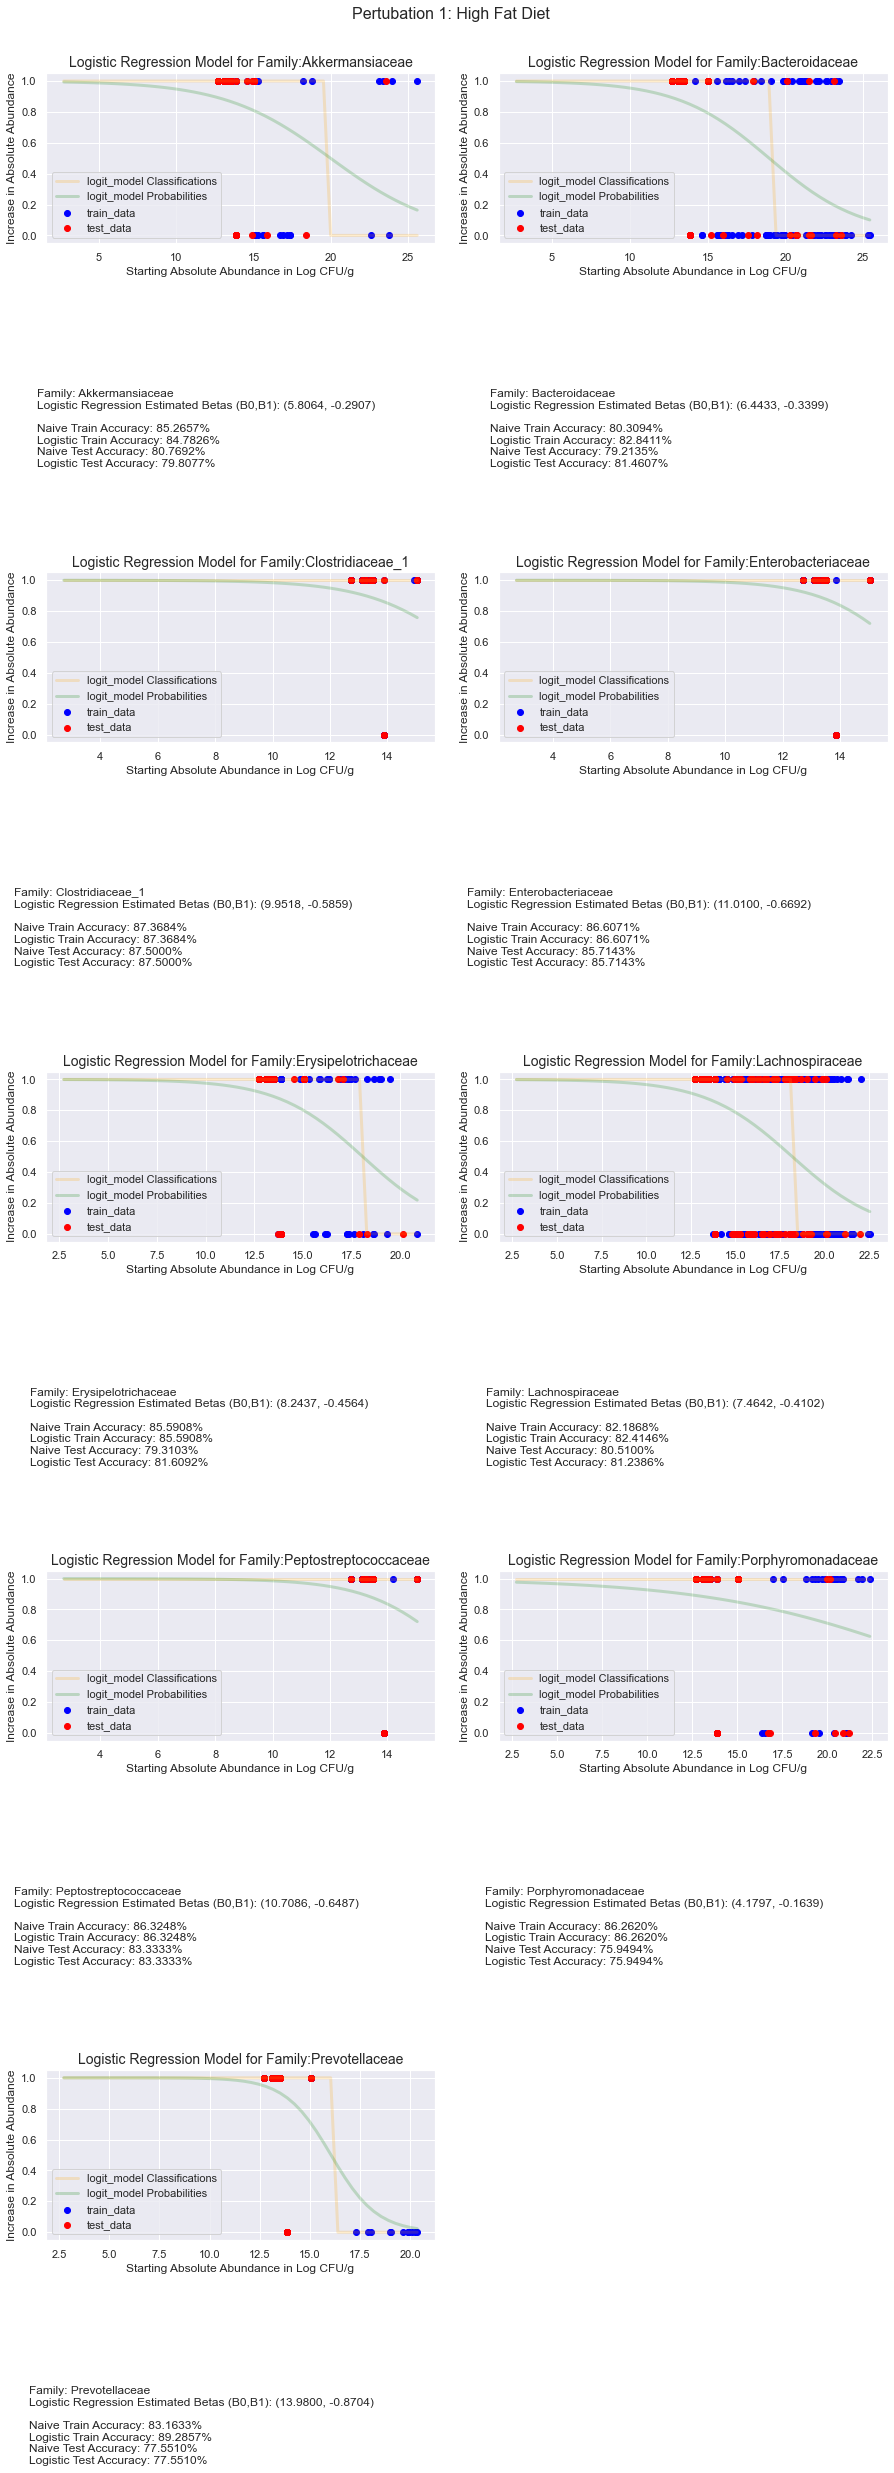

In [63]:
# High Fat Diet Perturbation
# Perturbation starts at time 21.5 and ends at 28.5
start = 21.5
end = 28.5

# Create figure
fig, axes = plt.subplots(5,2,figsize = (13,35))
fig.subplots_adjust(top = 1, bottom = 0.5)

for fam, ax in zip(family_list, axes.flatten()):
    # Run the logistic regression
    data_array, betas, predictions, train_accuracies, test_accuracies = logistic_regression(fam, start, end)
    
    # Decompose the arrays
    x_train, x_test, y_train, y_test = data_array
    beta0, beta1 = betas
    yhat_prob_logit, yhat_class_logit = predictions
    naive_train_accuracy, logit_train_accuracy = train_accuracies
    naive_test_accuracy, logit_test_accuracy = test_accuracies
    

    # Check that the shapes are correct
    ax.text(1, -1.5, f'Family: {fam}\n' + f'Logistic Regression Estimated Betas (B0,B1): ({beta0[0]:.4f}, {beta1[0][0]:.4f})\n\n'
                        + f'Naive Train Accuracy: {naive_train_accuracy*100:.4f}%\n'
                        + f'Logistic Train Accuracy: {logit_train_accuracy*100:.4f}%\n'
                        + f'Naive Test Accuracy: {naive_test_accuracy*100:.4f}%\n'
                        + f'Logistic Test Accuracy: {logit_test_accuracy*100:.4f}%')
    
    # Define the x for plot
    x = np.linspace(np.min(x_train)-10,np.max(x_train))
    
    # Plotting
    # Plot the train and test data
    ax.scatter(x_train, y_train, c = 'blue', label = 'train_data')
    ax.scatter(x_test, y_test, c = 'red', label = 'test_data')

    # Plot classifications and probabilities
    ax.plot(x, yhat_class_logit, label='logit_model Classifications', c = 'orange', alpha = 0.2, linewidth = 3)
    ax.plot(x, yhat_prob_logit, label = 'logit_model Probabilities', c = 'green', alpha = 0.2, linewidth = 3)

    ax.legend()
    ax.set_xlabel('Starting Absolute Abundance in Log CFU/g')
    ax.set_ylabel('Increase in Absolute Abundance')
    ax.set_title('Logistic Regression Model for Family:' + fam, fontsize = 14)

fig.tight_layout(pad=2)
fig.suptitle('Pertubation 1: High Fat Diet', fontsize = 16, y = 1.01);
fig.delaxes(axes[4][1]);

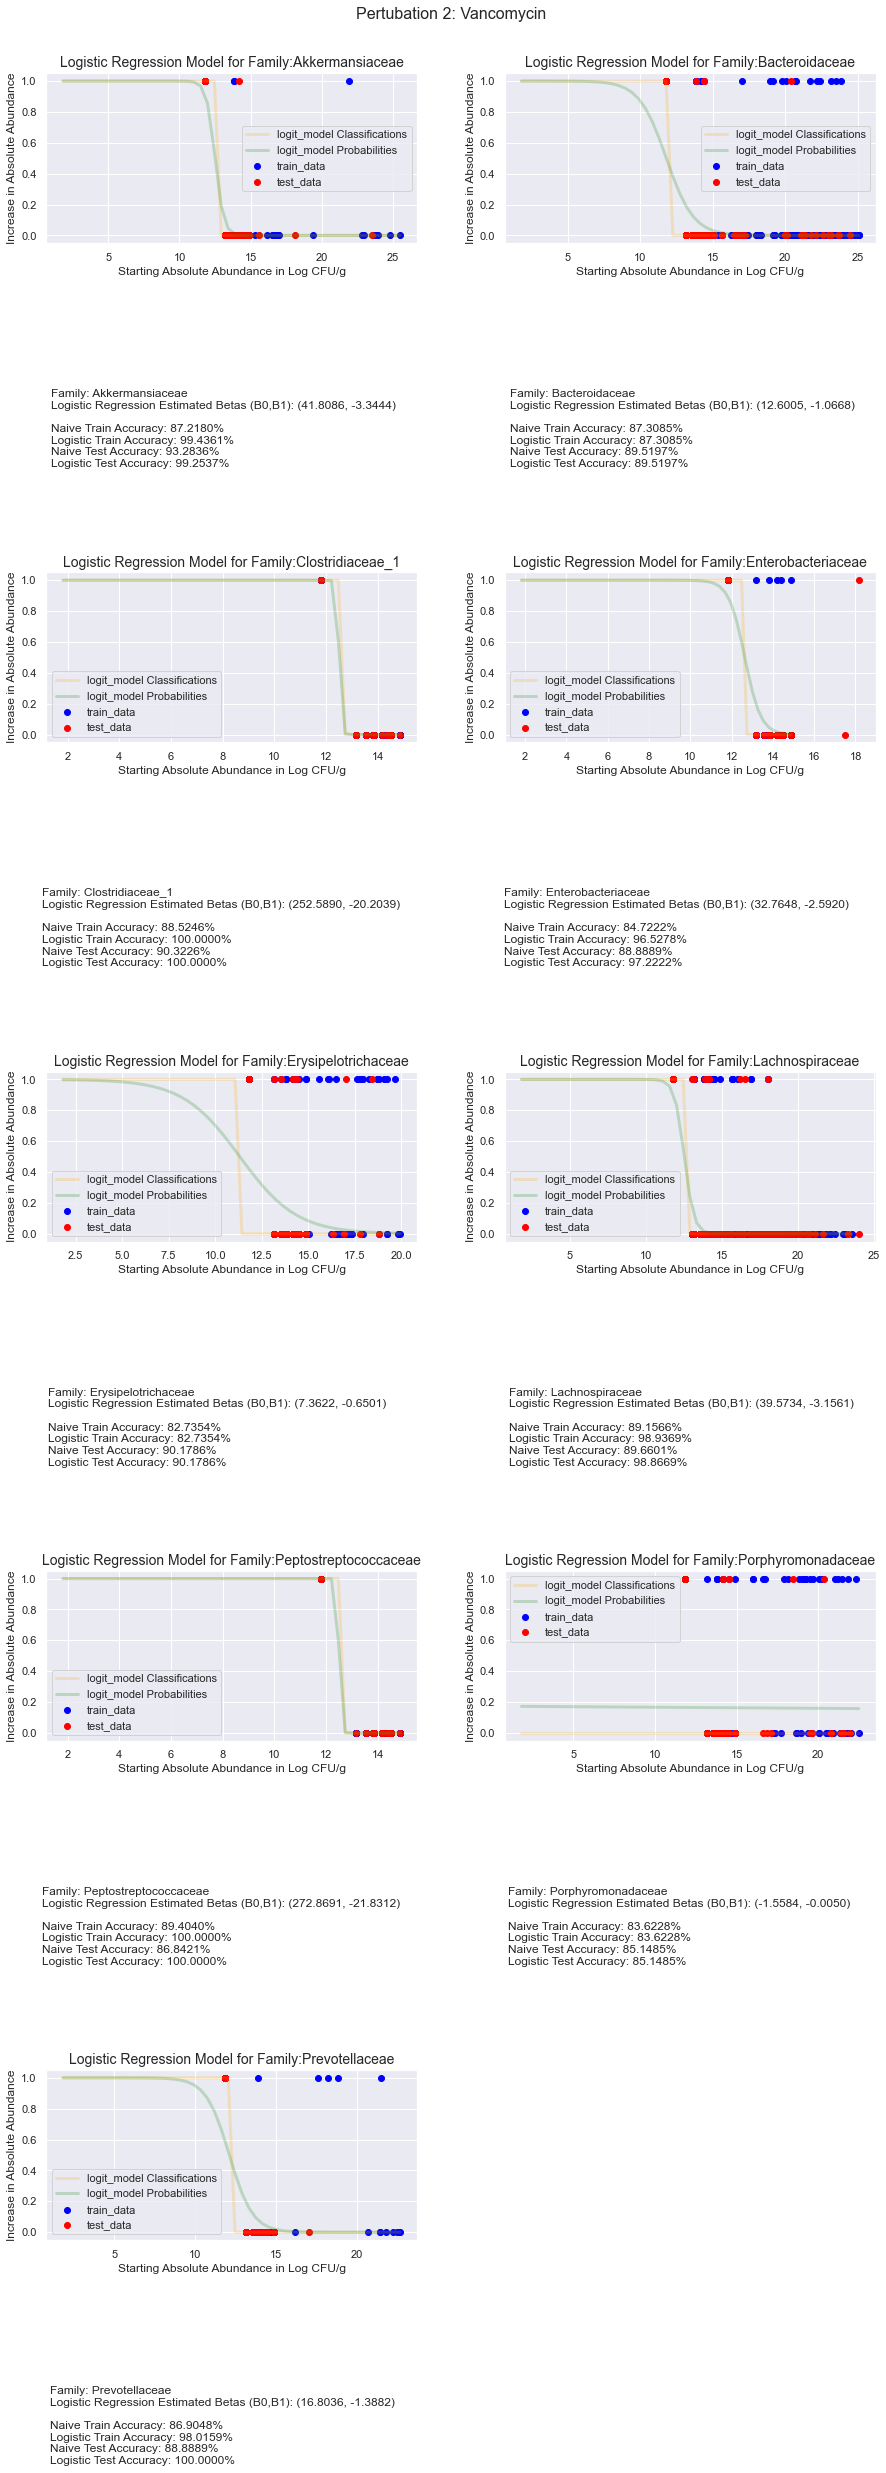

In [64]:
# Vancomycin Perturbation
# Perturbation starts at time 35.5 and ends at 42.5
start = 35.5
end = 42.5

# Create figure
fig, axes = plt.subplots(5,2,figsize = (13,35))
fig.subplots_adjust(top = 1, bottom = 0.5)

for fam, ax in zip(family_list, axes.flatten()):
    # Run the logistic regression
    data_array, betas, predictions, train_accuracies, test_accuracies = logistic_regression(fam, start, end)
    
    # Decompose the arrays
    x_train, x_test, y_train, y_test = data_array
    beta0, beta1 = betas
    yhat_prob_logit, yhat_class_logit = predictions
    naive_train_accuracy, logit_train_accuracy = train_accuracies
    naive_test_accuracy, logit_test_accuracy = test_accuracies
    

    # Check that the shapes are correct
    ax.text(1, -1.5, f'Family: {fam}\n' + f'Logistic Regression Estimated Betas (B0,B1): ({beta0[0]:.4f}, {beta1[0][0]:.4f})\n\n'
                        + f'Naive Train Accuracy: {naive_train_accuracy*100:.4f}%\n'
                        + f'Logistic Train Accuracy: {logit_train_accuracy*100:.4f}%\n'
                        + f'Naive Test Accuracy: {naive_test_accuracy*100:.4f}%\n'
                        + f'Logistic Test Accuracy: {logit_test_accuracy*100:.4f}%')
    
    # Define the x for plot
    x = np.linspace(np.min(x_train)-10,np.max(x_train))
    
    # Plotting
    # Plot the train and test data
    ax.scatter(x_train, y_train, c = 'blue', label = 'train_data')
    ax.scatter(x_test, y_test, c = 'red', label = 'test_data')

    # Plot classifications and probabilities
    ax.plot(x, yhat_class_logit, label='logit_model Classifications', c = 'orange', alpha = 0.2, linewidth = 3)
    ax.plot(x, yhat_prob_logit, label = 'logit_model Probabilities', c = 'green', alpha = 0.2, linewidth = 3)

    ax.legend()
    ax.set_xlabel('Starting Absolute Abundance in Log CFU/g')
    ax.set_ylabel('Increase in Absolute Abundance')
    ax.set_title('Logistic Regression Model for Family:' + fam, fontsize = 14)

fig.tight_layout(pad=2)
fig.suptitle('Pertubation 2: Vancomycin', fontsize = 16, y = 1.01);
fig.delaxes(axes[4][1]);

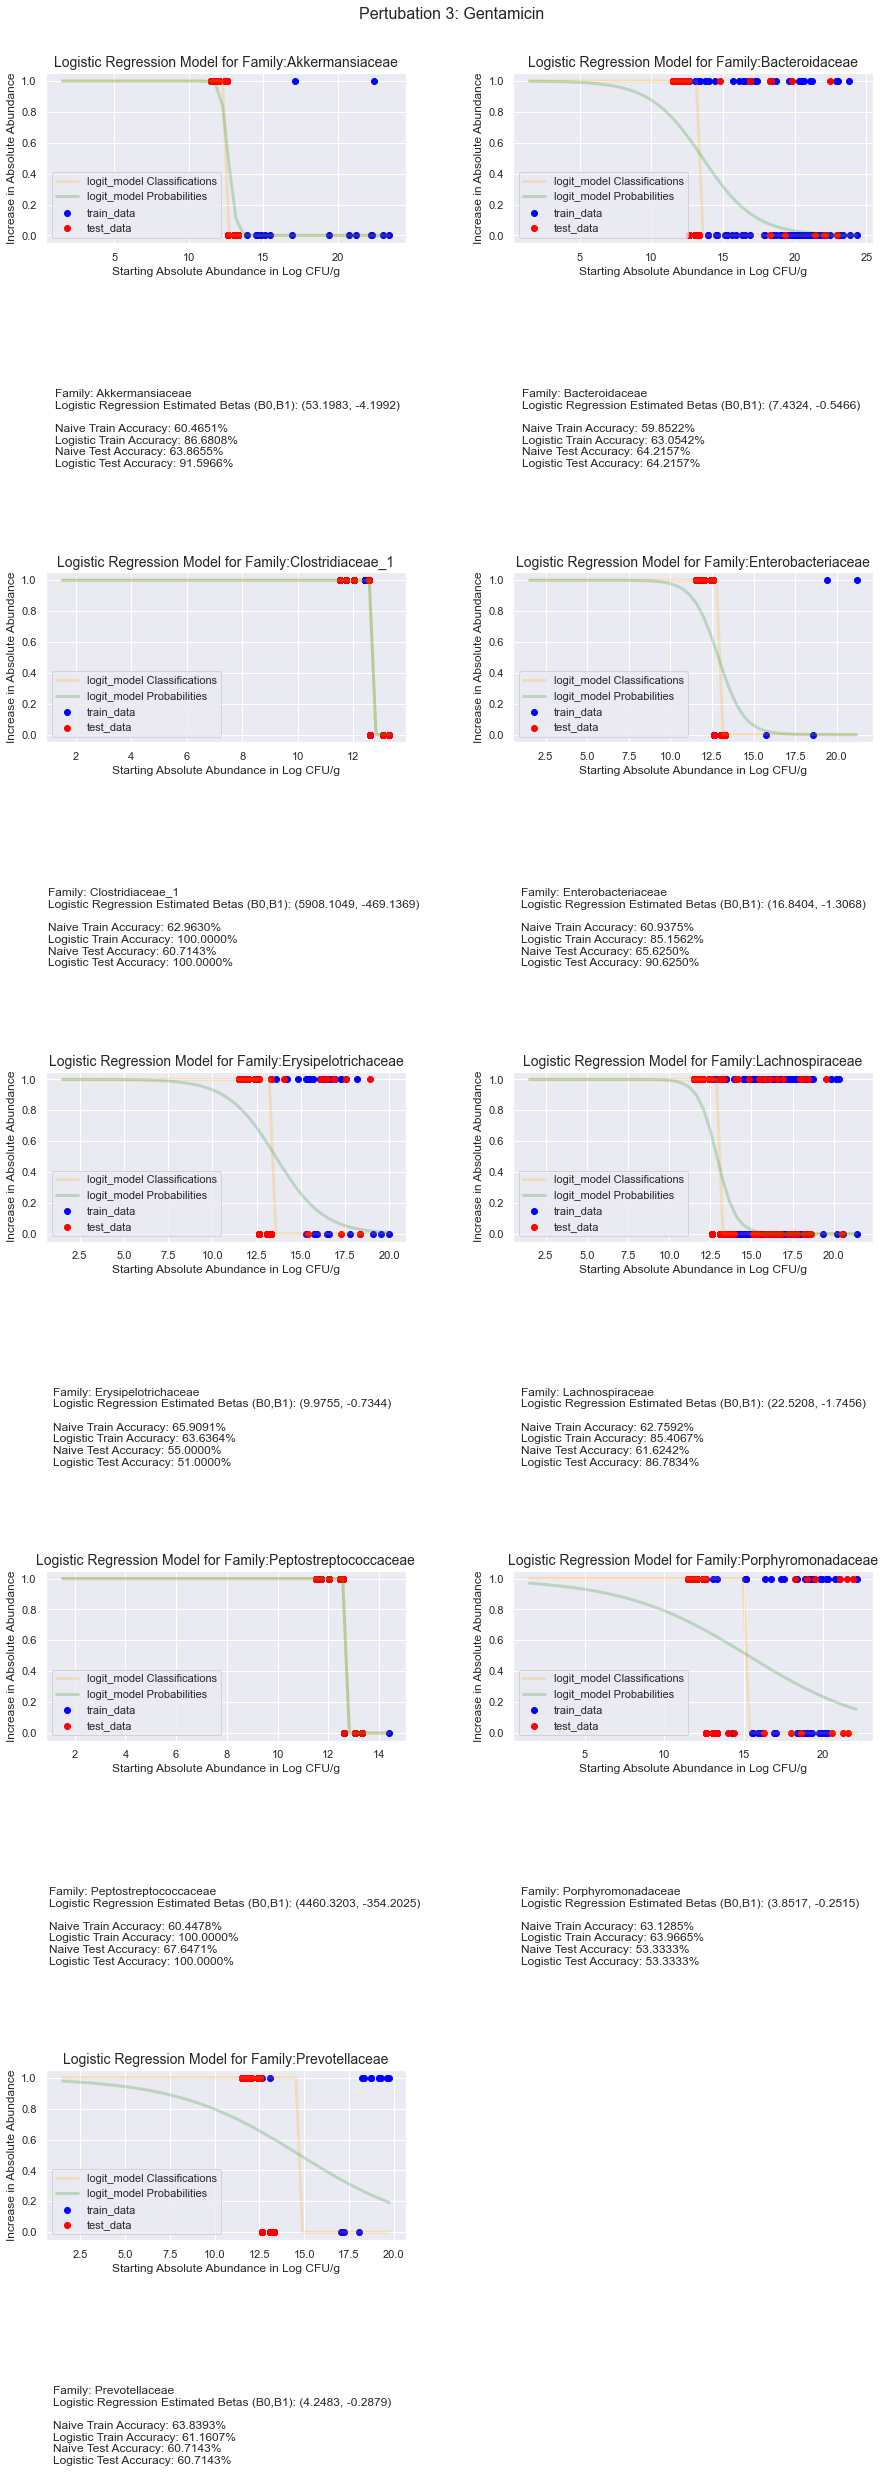

In [65]:
# Gentamicin Perturbation
# Perturbation starts at time 50.5 and ends at 57.5
start = 50.5
end = 57.5

# Create figure
fig, axes = plt.subplots(5,2,figsize = (13,35))
fig.subplots_adjust(top = 1, bottom = 0.5)

for fam, ax in zip(family_list, axes.flatten()):
    # Run the logistic regression
    data_array, betas, predictions, train_accuracies, test_accuracies = logistic_regression(fam, start, end)
    
    # Decompose the arrays
    x_train, x_test, y_train, y_test = data_array
    beta0, beta1 = betas
    yhat_prob_logit, yhat_class_logit = predictions
    naive_train_accuracy, logit_train_accuracy = train_accuracies
    naive_test_accuracy, logit_test_accuracy = test_accuracies
    

    # Check that the shapes are correct
    ax.text(1, -1.5, f'Family: {fam}\n' + f'Logistic Regression Estimated Betas (B0,B1): ({beta0[0]:.4f}, {beta1[0][0]:.4f})\n\n'
                        + f'Naive Train Accuracy: {naive_train_accuracy*100:.4f}%\n'
                        + f'Logistic Train Accuracy: {logit_train_accuracy*100:.4f}%\n'
                        + f'Naive Test Accuracy: {naive_test_accuracy*100:.4f}%\n'
                        + f'Logistic Test Accuracy: {logit_test_accuracy*100:.4f}%')
    
    # Define the x for plot
    x = np.linspace(np.min(x_train)-10,np.max(x_train))
    
    # Plotting
    # Plot the train and test data
    ax.scatter(x_train, y_train, c = 'blue', label = 'train_data')
    ax.scatter(x_test, y_test, c = 'red', label = 'test_data')

    # Plot classifications and probabilities
    ax.plot(x, yhat_class_logit, label='logit_model Classifications', c = 'orange', alpha = 0.2, linewidth = 3)
    ax.plot(x, yhat_prob_logit, label = 'logit_model Probabilities', c = 'green', alpha = 0.2, linewidth = 3)

    ax.legend()
    ax.set_xlabel('Starting Absolute Abundance in Log CFU/g')
    ax.set_ylabel('Increase in Absolute Abundance')
    ax.set_title('Logistic Regression Model for Family:' + fam, fontsize = 14)

fig.tight_layout(pad=2)
fig.suptitle('Pertubation 3: Gentamicin', fontsize = 16, y = 1.01);
fig.delaxes(axes[4][1]);

Examining each of the nine models for each of the three perturbations, we observe several interesting trends in the results. First, for the high fat diet perturbation, the logistic regression model only outperformed the naïve model three out of nine times based on the test accuracy. For the gentamicin perturbation it outperformed the naïve model five out of nine times, and for the vancomycin perturbation it outperformed six out of nine times. This could be because the high fat diet may have minimal impact on the absolute abundance of our selected OTUs. In that case, our model would have more limited predictive power, as there would be no effect of starting abundance on the probability of increasing in absolute abundance or decreasing in absolute abundance for a given perturbation. Examining the EDA chart titled “Healthy Cohort Mouse #2: After High Fat Diet”, we observe that at time 31 and at time 35, the relative abundances of the top 10 bacterial families is roughly equivalent, partly supporting this explanation.

Second, we also observe that our model consistently performs better than the naïve model for the family Lachnospiraceae regardless of perturbation. For the high fat diet, the naïve test accuracy is 0.805 while the logistic test accuracy is 0.812. For the vancomycin perturbation, the naïve test accuracy is 0.897 while the logistic test accuracy is 0.989. Finally, for the gentamicin perturbation the naïve test accuracy is 0.616 while the logistic test accuracy is significantly better at 0.868. Conversely, it is also interesting to note that the logistic regression model performs poorly on the Porphyromondaceae family regardless of the perturbation as evaluated by our logistic and naïve test accuracies.

Third, we observe that for many of the perturbation responses for a given family, both the train and test accuracies are quite low (below 0.65) with data points that are sparse and scattered with no clear pattern. This could indicate that given the perturbation for a some families, the starting absolute abundance has limited predictive power to determine whether the absolute abundance will increase or decrease by the end of the treatment.

One strength of this model is that although it is simple, it is thus, simple to understand and interpret. Whereas the output and results of our LSTM models and RNN models may be more difficult to interpret, using our logistic regression model, we can quantify the probability that the absolute abundance of a given family for a given perturbation will increase. This can have several practical real life applications. For instance, if scientists desire to know how a high fat diet, vancomycin, or gentamicin will affect the absolute concentration of an OTU that they have never observed, then they could sequence its 16s rRNA sequence, match the sequence to a preexisting 16s rRNA sequence, determine which family it belongs to, and then use the starting absolute abundance of the OTU and the appropriate logistic regression model to determine the probability of the absolute abundance increasing. 

One potential improvement to this model could be making this regression into a multi-class logistic regression with three classes: increase, decrease, or stay the same instead of just predicting whether the absolute abundance will increase or decrease; however, we chose not to pursue this avenue as an objective measure of “no change” would be difficult to determine without consensus from the broader scientific community. Another improvement that we considered, but ultimately chose not to pursue was with L1 or L2 regularization. In general, regularization is necessary when the model overfits the data. Based on the bias variance tradeoff, if our model overfit the data, then it would have low bias and high variance; however, given our train and test accuracy results, in addition to our graphs, it does not appear that our model has overfit the data. Moreover, we have no need for lasso regression as we do not require feature selection, since we only have one feature: absolute abundance. 

Future work could include repeating this experiment while collecting more features for greater model predictive power, testing out new perturbations, and trying to distinguish if there is a difference in perturbation response between UC mice and healthy mice if we had more data to utilize to train our models.


------

<a id="models2"> </a>
# Models (Part 2)

<a id="dataPreprocessing"> </a>
## Data Preprocessing

Next, we preprocessed our data for time series classification. Namely, we created a `time_series_df` with columns `Subject`, `ASV`, `Family`, and `Series`. 
- The `Subject` column contains the mice number. 
- The `ASV` column contains the ASV number. 
- The `Family` column contains the family name and will be used as the label for classification. 
- The `Series` column contains the time series in log absolute abundance (log(CFU/g)). It will be used as the data for classification.


Moreover, we calculated a max sequence length is `78`. Thus, we did a zero prepadding to every time series so that all the time series are of length `78`. In addition, we also added an indicator for each time series so that all the healthy subject's time series start with a `1` and all the unhealthy subject's time series start with a `0`. We believe that this indicator is necessay based on our EDA. Based on our Perturbations' Effect on Bacteria Families' qPCR Concentration Separated by Family chart, we saw that for some families, the qPCR concentration change differently depending on if the sample was from a mice with UC verus from a healthy mice.

In [66]:
# set indicator: healthy is 0 and unhealthy is 1
time_series_fat_dict = {"Subject": [], "ASV" : [], "Family": [], "Series": []}
time_series_vancomycin_dict = {"Subject": [], "ASV" : [], "Family": [], "Series": []}
time_series_gentamicin_dict = {"Subject": [], "ASV" : [], "Family": [], "Series": []}

max_len = 30
for index, row in absolute_abundance.iterrows():
    fat_series = {2: [(-1, 0)], 3: [(-1, 0)], 4: [(-1, 0)], 5: [(-1, 0)], 6: [(-1, 1)], 7: [(-1, 1)], 8: [(-1, 1)], 9: [(-1, 1)], 10: [(-1, 1)]}
    vancomycin_series = {2: [(-1, 0)], 3: [(-1, 0)], 4: [(-1, 0)], 5: [(-1, 0)], 6: [(-1, 1)], 7: [(-1, 1)], 8: [(-1, 1)], 9: [(-1, 1)], 10: [(-1, 1)]}
    gentamicin_series = {2: [(-1, 0)], 3: [(-1, 0)], 4: [(-1, 0)], 5: [(-1, 0)], 6: [(-1, 1)], 7: [(-1, 1)], 8: [(-1, 1)], 9: [(-1, 1)], 10: [(-1, 1)]}
    
    for column_name in absolute_abundance:
        if column_name == "Name" or column_name == "Family":
            break
        qPCR_row = qPCR_more.loc[qPCR_more['sampleID'] == column_name]
        
        time_ = qPCR_row['time'].values[0]
    
        if time_ >= 15.0 and time_ < 30.0:
            fat_series[qPCR_row['subject'].values[0]].append([time_, row[column_name]])
        elif time_ >= 30.0 and time_ < 45.0:
            vancomycin_series[qPCR_row['subject'].values[0]].append([time_, row[column_name]])
        elif time_ <= 45.0 and time_ > 60.0:
            gentamicin_series[qPCR_row['subject'].values[0]].append([time_, row[column_name]])

        
    for s in fat_series:

        time_series_fat_dict["Subject"].append(s)
        time_series_fat_dict["ASV"].append(row["Name"])
        time_series_fat_dict["Family"].append(row["Family"])
        
        sorted_series = sorted(fat_series[s], key=lambda x: x[0])
        time_series_fat_dict["Series"].append([0]*(max_len - len(sorted_series)) + [x[1] for x in sorted_series])
    
    for s in vancomycin_series:

        time_series_vancomycin_dict["Subject"].append(s)
        time_series_vancomycin_dict["ASV"].append(row["Name"])
        time_series_vancomycin_dict["Family"].append(row["Family"])
        
        sorted_series = sorted(vancomycin_series[s], key=lambda x: x[0])
        time_series_vancomycin_dict["Series"].append([0]*(max_len - len(sorted_series)) + [x[1] for x in sorted_series])
        
        
    for s in gentamicin_series:

        time_series_gentamicin_dict["Subject"].append(s)
        time_series_gentamicin_dict["ASV"].append(row["Name"])
        time_series_gentamicin_dict["Family"].append(row["Family"])
        
        sorted_series = sorted(gentamicin_series[s], key=lambda x: x[0])
        time_series_gentamicin_dict["Series"].append([0]*(max_len - len(sorted_series)) + [x[1] for x in sorted_series])    
    

In [67]:
time_series_fat_df = pd.DataFrame(time_series_fat_dict)
time_series_vancomycin_df = pd.DataFrame(time_series_vancomycin_dict)
time_series_gentamicin_df = pd.DataFrame(time_series_gentamicin_dict)

In [68]:
time_series_fat_df.to_csv('fat_series_data.csv')
time_series_vancomycin_df.to_csv('vancomycin_series_data.csv')
time_series_gentamicin_df.to_csv('gentamicin_series_data.csv')

In [69]:
time_series_fat_df = pd.read_csv('fat_series_data.csv')
time_series_vancomycin_df = pd.read_csv('vancomycin_series_data.csv')
time_series_gentamicin_df = pd.read_csv('gentamicin_series_data.csv')

In [70]:
def preprocess_time_series_df(time_series_df):
    for index, row in time_series_df.iterrows():
        if row["Family"] not in families:
            time_series_df.at[index, "Family"] = "Other"

    time_series_df["Series"] = time_series_df["Series"].apply(literal_eval)
    return time_series_df

In [71]:
time_series_fat_df = preprocess_time_series_df(time_series_fat_df)
time_series_vancomycin_df = preprocess_time_series_df(time_series_vancomycin_df)
time_series_gentamicin_df = preprocess_time_series_df(time_series_gentamicin_df)

### Time Series Data for Fat Diet Perturbation

In [73]:
X_fat = time_series_fat_df['Series'].values
X_fat = np.array(list(X_fat[:]), dtype=np.float64)

Y_fat = pd.get_dummies(time_series_fat_df['Family']).values

indices_fat = np.arange(X_fat.shape[0])


print(f"X fat shape: {X_fat.shape}")
print(f"Y fat shape: {Y_fat.shape}")
print(f"indices fat shape: {indices_fat.shape}")

X fat shape: (13257, 30)
Y fat shape: (13257, 10)
indices fat shape: (13257,)


In [74]:
X_fat_train, X_fat_test, Y_fat_train, Y_fat_test, train_fat_index, test_fat_index = train_test_split(X_fat, Y_fat, indices_fat, test_size = 0.20, random_state = 109)
print(f"X fat train shape: {X_fat_train.shape} , Y fat train shape: {Y_fat_train.shape}, train fat index shape: {train_fat_index.shape}")
print(f"X fat test shape: {X_fat_test.shape}, Y fat test shape: {Y_fat_test.shape}, test fat index shape: {test_fat_index.shape}")

X fat train shape: (10605, 30) , Y fat train shape: (10605, 10), train fat index shape: (10605,)
X fat test shape: (2652, 30), Y fat test shape: (2652, 10), test fat index shape: (2652,)


### Time Series Data for  Vancomycin Perturbation

In [75]:
X_vancomycin = time_series_vancomycin_df['Series'].values
X_vancomycin = np.array(list(X_vancomycin[:]), dtype=np.float64)

Y_vancomycin = pd.get_dummies(time_series_vancomycin_df['Family']).values

indices_vancomycin = np.arange(X_vancomycin.shape[0])


print(f"X vancomycin shape: {X_vancomycin.shape}")
print(f"Y vancomycin shape: {Y_vancomycin.shape}")
print(f"indices vancomycin shape: {indices_vancomycin.shape}")

X vancomycin shape: (13257, 30)
Y vancomycin shape: (13257, 10)
indices vancomycin shape: (13257,)


In [76]:
X_vancomycin_train, X_vancomycin_test, Y_vancomycin_train, Y_vancomycin_test, train_vancomycin_index, test_vancomycin_index = train_test_split(X_vancomycin, Y_vancomycin, indices_vancomycin, test_size = 0.20, random_state = 109)
print(f"X vancomycin train shape: {X_vancomycin_train.shape} , Y vancomycin train shape: {Y_vancomycin_train.shape}, train vancomycin index shape: {train_vancomycin_index.shape}")
print(f"X vancomycin test shape: {X_vancomycin_test.shape}, Y vancomycin test shape: {Y_vancomycin_test.shape}, test vancomycin index shape: {test_vancomycin_index.shape}")

X vancomycin train shape: (10605, 30) , Y vancomycin train shape: (10605, 10), train vancomycin index shape: (10605,)
X vancomycin test shape: (2652, 30), Y vancomycin test shape: (2652, 10), test vancomycin index shape: (2652,)


### Time Series Data for  Gentamicin Perturbation

In [77]:
X_gentamicin = time_series_gentamicin_df['Series'].values
X_gentamicin = np.array(list(X_gentamicin[:]), dtype=np.float64)

Y_gentamicin = pd.get_dummies(time_series_gentamicin_df['Family']).values

indices_gentamicin = np.arange(X_gentamicin.shape[0])

print(f"X gentamicin shape: {X_gentamicin.shape}")
print(f"Y gentamicin shape: {Y_gentamicin.shape}")
print(f"indices gentamicin shape: {indices_gentamicin.shape}")

X gentamicin shape: (13257, 30)
Y gentamicin shape: (13257, 10)
indices gentamicin shape: (13257,)


In [78]:
X_gentamicin_train, X_gentamicin_test, Y_gentamicin_train, Y_gentamicin_test, train_gentamicin_index, test_gentamicin_index = train_test_split(X_gentamicin, Y_gentamicin, indices_gentamicin, test_size = 0.20, random_state = 109)
print(f"X gentamicin train shape: {X_gentamicin_train.shape} , Y gentamicin train shape: {Y_gentamicin_train.shape}, train gentamicin index shape: {train_gentamicin_index.shape}")
print(f"X gentamicin test shape: {X_gentamicin_test.shape}, Y gentamicin test shape: {Y_gentamicin_test.shape}, test gentamicin index shape: {test_gentamicin_index.shape}")

X gentamicin train shape: (10605, 30) , Y gentamicin train shape: (10605, 10), train gentamicin index shape: (10605,)
X gentamicin test shape: (2652, 30), Y gentamicin test shape: (2652, 10), test gentamicin index shape: (2652,)


### Map Label Encoding to Family Name and Vice Versa

In [79]:
family_name_to_encode = dict()

for indx, row in time_series_fat_df.iterrows():
    assert(np.argmax(Y_fat[indx]) == np.argmax(Y_vancomycin[indx]) == np.argmax(Y_gentamicin[indx]))
    family_name_to_encode[row["Family"]] = Y_fat[indx]

family_name_to_encode

{'Bacteroidaceae': array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8),
 'Akkermansiaceae': array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8),
 'Other': array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0], dtype=uint8),
 'Enterobacteriaceae': array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0], dtype=uint8),
 'Porphyromonadaceae': array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0], dtype=uint8),
 'Lachnospiraceae': array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0], dtype=uint8),
 'Prevotellaceae': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1], dtype=uint8),
 'Clostridiaceae_1': array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0], dtype=uint8),
 'Erysipelotrichaceae': array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0], dtype=uint8),
 'Peptostreptococcaceae': array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0], dtype=uint8)}

In [80]:
encode_to_family_name = {tuple(value): key for key, value in family_name_to_encode.items()}

encode_to_family_name

{(0, 1, 0, 0, 0, 0, 0, 0, 0, 0): 'Bacteroidaceae',
 (1, 0, 0, 0, 0, 0, 0, 0, 0, 0): 'Akkermansiaceae',
 (0, 0, 0, 0, 0, 0, 1, 0, 0, 0): 'Other',
 (0, 0, 0, 1, 0, 0, 0, 0, 0, 0): 'Enterobacteriaceae',
 (0, 0, 0, 0, 0, 0, 0, 0, 1, 0): 'Porphyromonadaceae',
 (0, 0, 0, 0, 0, 1, 0, 0, 0, 0): 'Lachnospiraceae',
 (0, 0, 0, 0, 0, 0, 0, 0, 0, 1): 'Prevotellaceae',
 (0, 0, 1, 0, 0, 0, 0, 0, 0, 0): 'Clostridiaceae_1',
 (0, 0, 0, 0, 1, 0, 0, 0, 0, 0): 'Erysipelotrichaceae',
 (0, 0, 0, 0, 0, 0, 0, 1, 0, 0): 'Peptostreptococcaceae'}

---

<a id="baselineModel"> </a>
## Baseline Model

First, we created a baseline model. This will be a naive model for our classification task. Essentially, we found the class that appears the most frequently in our train data, "Other". Then, we have our model classify every time-series as "Other" and calculate the accuracy.

In [81]:
def get_max_family_class(y):
    return max(set(map(lambda y_: tuple(y_), y)), key = list(map(lambda y_: tuple(y_), y)).count)

In [83]:
max_class = get_max_family_class(Y_fat_train)

print(f"The most frequent occuring class in our training data is {max_class}, family: {encode_to_family_name[max_class]}.")
print()

train_fat_accuracy = list(map(lambda y_: tuple(y_), Y_fat_train)).count(max_class) / Y_fat_train.shape[0]
test_fat_accuracy = list(map(lambda y_: tuple(y_), Y_fat_test)).count(max_class) / Y_fat_test.shape[0]

print(f"The train accuracy of our baseline model is {train_fat_accuracy*100:.4f}% for all the perturbations.")
print(f"The test accuracy of our baseline model is {test_fat_accuracy*100:.4f}% for all the perturbations.")

The most frequent occuring class in our training data is (0, 0, 0, 0, 0, 0, 1, 0, 0, 0), family: Other.

The train accuracy of our baseline model is 45.4597% for all the perturbations.
The test accuracy of our baseline model is 45.2489% for all the perturbations.


---

<a id="modeling"> </a>
## Model Parameters

In [84]:
embedding_dim = 100
embedding_input_dimension = 1000
classes = 10
max_len = 78

epochs = 50
batch_size = 64

In [85]:
def plot_history(history, model_name):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

    ax1.set_title(f'Loss for {model_name}') 
    ax1.plot(history.history['loss'], label='train')
    ax1.plot(history.history['val_loss'], label='validation')
    ax1.legend()
    
    
    ax2.set_title(f'Accuracy for {model_name}')
    ax2.plot(history.history['accuracy'], label='train')
    ax2.plot(history.history['val_accuracy'], label='validation')
    ax2.legend()

    fig.show()

<a id="rnn"> </a>
## RNN

In [86]:
# Numpy of version below 1.20 required
np.__version__

'1.19.5'

In [87]:
def build_rnn(X, name="rnn_model", n_units=128, drop=0.2):

    model = keras.Sequential(name=name)
    model.add(layers.Embedding(embedding_input_dimension, embedding_dim, input_length=X.shape[1]))
    model.add(layers.Dropout(drop))
    model.add(layers.SimpleRNN(units=2*n_units))
    # model.add(Dense(n_tags, activation="softmax"))
#     model.add(layers.TimeDistributed(layers.Dense(classes, activation="sigmoid")))
    model.add(layers.Dense(classes, activation="sigmoid"))

    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

### RNN Model for Fat Diet Perturbations

In [88]:
model_rnn_fat = build_rnn(X_fat_train, "rnn_model_fat")
model_rnn_fat.summary()

Model: "rnn_model_fat"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 100)           100000    
_________________________________________________________________
dropout (Dropout)            (None, 30, 100)           0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 256)               91392     
_________________________________________________________________
dense (Dense)                (None, 10)                2570      
Total params: 193,962
Trainable params: 193,962
Non-trainable params: 0
_________________________________________________________________


In [89]:
history_rnn_fat = model_rnn_fat.fit(X_fat_train, 
                                    Y_fat_train, 
                                    epochs=epochs, 
                                    batch_size=batch_size,
                                    validation_split=0.1,
                                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, min_delta=0.0001)])

Epoch 1/50
150/150 [==============================] - 6s 42ms/step - loss: 1.6281 - accuracy: 0.4533 - val_loss: 1.6034 - val_accuracy: 0.4430
Epoch 2/50
150/150 [==============================] - 6s 42ms/step - loss: 1.6021 - accuracy: 0.4559 - val_loss: 1.6254 - val_accuracy: 0.4430
Epoch 3/50
150/150 [==============================] - 6s 43ms/step - loss: 1.5981 - accuracy: 0.4559 - val_loss: 1.6204 - val_accuracy: 0.4430
Epoch 4/50
150/150 [==============================] - 5s 36ms/step - loss: 1.5948 - accuracy: 0.4559 - val_loss: 1.5867 - val_accuracy: 0.4430
Epoch 5/50
150/150 [==============================] - 7s 44ms/step - loss: 1.5905 - accuracy: 0.4559 - val_loss: 1.5804 - val_accuracy: 0.4430
Epoch 6/50
150/150 [==============================] - 5s 33ms/step - loss: 1.5849 - accuracy: 0.4559 - val_loss: 1.5938 - val_accuracy: 0.4430
Epoch 7/50
150/150 [==============================] - 9s 57ms/step - loss: 1.5796 - accuracy: 0.4571 - val_loss: 1.5914 - val_accuracy: 0.4505

<ipython-input-85-aa3ebd3e001e>:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


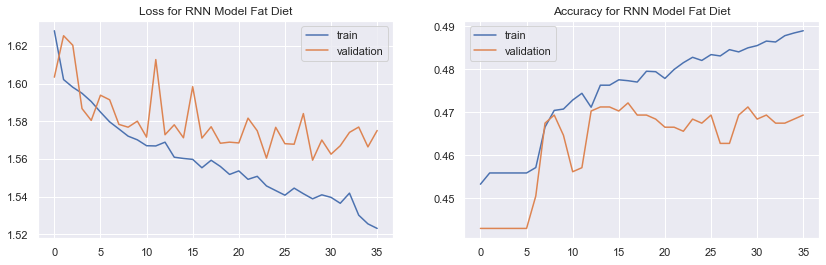

In [90]:
plot_history(history_rnn_fat, 'RNN Model Fat Diet')

In [91]:
_, rnn_train_acc_fat = model_rnn_fat.evaluate(X_fat_train, Y_fat_train, verbose=0)
_, rnn_test_acc_fat = model_rnn_fat.evaluate(X_fat_test, Y_fat_test, verbose=0)


print(f"RNN train accuracy fat diet: {rnn_train_acc_fat}")
print(f"RNN test accuracy fat diet: {rnn_test_acc_fat}")

RNN train accuracy fat diet: 0.48731729388237
RNN test accuracy fat diet: 0.4675716459751129


### RNN Model for Vancomycin Perturbations

In [92]:
model_rnn_vancomycin = build_rnn(X_vancomycin_train, "rnn_model_vancomycin")
model_rnn_vancomycin.summary()

Model: "rnn_model_vancomycin"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 30, 100)           100000    
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 100)           0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 256)               91392     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
Total params: 193,962
Trainable params: 193,962
Non-trainable params: 0
_________________________________________________________________


In [93]:
history_rnn_vancomycin = model_rnn_vancomycin.fit(X_vancomycin_train, 
                                                  Y_vancomycin_train, 
                                                  epochs=epochs, 
                                                  batch_size=batch_size,
                                                  validation_split=0.1,
                                                  callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, min_delta=0.0001)])

Epoch 1/50
150/150 [==============================] - 7s 46ms/step - loss: 1.6302 - accuracy: 0.4420 - val_loss: 1.6277 - val_accuracy: 0.4430
Epoch 2/50
150/150 [==============================] - 6s 43ms/step - loss: 1.6010 - accuracy: 0.4559 - val_loss: 1.5947 - val_accuracy: 0.4430
Epoch 3/50
150/150 [==============================] - 7s 44ms/step - loss: 1.5976 - accuracy: 0.4559 - val_loss: 1.6039 - val_accuracy: 0.4430
Epoch 4/50
150/150 [==============================] - 6s 43ms/step - loss: 1.5990 - accuracy: 0.4559 - val_loss: 1.5954 - val_accuracy: 0.4430
Epoch 5/50
150/150 [==============================] - 6s 43ms/step - loss: 1.5905 - accuracy: 0.4559 - val_loss: 1.6053 - val_accuracy: 0.4430
Epoch 6/50
150/150 [==============================] - 6s 38ms/step - loss: 1.5854 - accuracy: 0.4559 - val_loss: 1.5857 - val_accuracy: 0.4430
Epoch 7/50
150/150 [==============================] - 6s 37ms/step - loss: 1.5857 - accuracy: 0.4559 - val_loss: 1.5811 - val_accuracy: 0.4430

<ipython-input-85-aa3ebd3e001e>:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


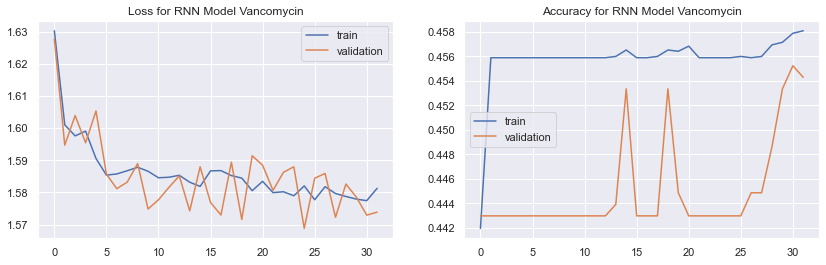

In [94]:
plot_history(history_rnn_vancomycin, 'RNN Model Vancomycin')

In [95]:
_, rnn_train_acc_vancomycin = model_rnn_vancomycin.evaluate(X_vancomycin_train, Y_vancomycin_train, verbose=0)
_, rnn_test_acc_vancomycin = model_rnn_vancomycin.evaluate(X_vancomycin_test, Y_vancomycin_test, verbose=0)


print(f"RNN train accuracy vancomycin diet: {rnn_train_acc_vancomycin}")
print(f"RNN test accuracy vancomycin diet: {rnn_test_acc_vancomycin}")

RNN train accuracy vancomycin diet: 0.45818009972572327
RNN test accuracy vancomycin diet: 0.4517345428466797


### RNN Model for Gentamicin Perturbations

In [96]:
model_rnn_gentamicin = build_rnn(X_gentamicin_train, "rnn_model_gentamicin")
model_rnn_gentamicin.summary()

Model: "rnn_model_gentamicin"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 30, 100)           100000    
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 100)           0         
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 256)               91392     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                2570      
Total params: 193,962
Trainable params: 193,962
Non-trainable params: 0
_________________________________________________________________


In [97]:
history_rnn_gentamicin = model_rnn_gentamicin.fit(X_gentamicin_train, 
                                                  Y_gentamicin_train, 
                                                  epochs=epochs, 
                                                  batch_size=batch_size,
                                                  validation_split=0.1,
                                                  callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, min_delta=0.0001)])

Epoch 1/50
150/150 [==============================] - 7s 44ms/step - loss: 1.6223 - accuracy: 0.4533 - val_loss: 1.6056 - val_accuracy: 0.4430
Epoch 2/50
150/150 [==============================] - 6s 42ms/step - loss: 1.6033 - accuracy: 0.4559 - val_loss: 1.6010 - val_accuracy: 0.4430
Epoch 3/50
150/150 [==============================] - 7s 44ms/step - loss: 1.5980 - accuracy: 0.4559 - val_loss: 1.5946 - val_accuracy: 0.4430
Epoch 4/50
150/150 [==============================] - 7s 44ms/step - loss: 1.5970 - accuracy: 0.4559 - val_loss: 1.6041 - val_accuracy: 0.4430
Epoch 5/50
150/150 [==============================] - 6s 43ms/step - loss: 1.6014 - accuracy: 0.4559 - val_loss: 1.5922 - val_accuracy: 0.4430
Epoch 6/50
150/150 [==============================] - 6s 43ms/step - loss: 1.5980 - accuracy: 0.4559 - val_loss: 1.6010 - val_accuracy: 0.4430
Epoch 7/50
150/150 [==============================] - 7s 44ms/step - loss: 1.6001 - accuracy: 0.4559 - val_loss: 1.5966 - val_accuracy: 0.4430

<ipython-input-85-aa3ebd3e001e>:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


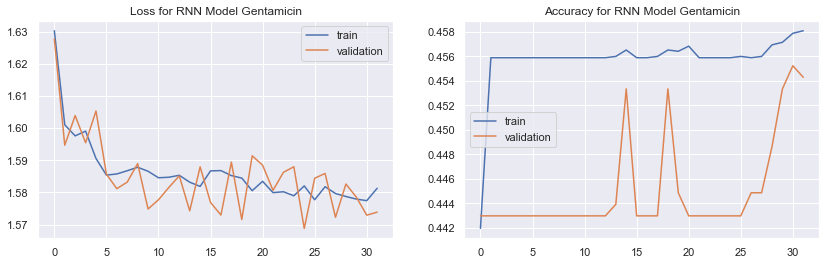

In [98]:
plot_history(history_rnn_vancomycin, 'RNN Model Gentamicin')

In [99]:
_, rnn_train_acc_gentamicin = model_rnn_gentamicin.evaluate(X_gentamicin_train, Y_gentamicin_train, verbose=0)
_, rnn_test_acc_gentamicin = model_rnn_gentamicin.evaluate(X_gentamicin_test, Y_gentamicin_test, verbose=0)


print(f"RNN train accuracy gentamicin diet: {rnn_train_acc_gentamicin}")
print(f"RNN test accuracy gentamicin diet: {rnn_test_acc_gentamicin}")

RNN train accuracy gentamicin diet: 0.4545968770980835
RNN test accuracy gentamicin diet: 0.4524886906147003


In our RNN every neuron in the network is assigned to a particular timestep (since our data is a time series). Just as in any regular RNN, the input layer is passed into a hidden layer which in turn produces the output layer. We started our neural network modeling with an RNN instead of a simple feed-forward network because it has a form of memory, since the output of a particular timestep is dependent on both the current input, and the previous hidden layer. This allows the network to take into account now just information from the current timestep, but also from the previous timestep. However, as we know, RNNs can suffer from vanishing gradients and from exploding gradients. This problem can be fixed by using and LSTM or a GRU. More abstractly, we can think about how when our model is at the end of the input sequence, it will not necessarily have much access to information from the beginning of the input sequence. If the beginning sequence information is important, however, then that could result in an incorrect prediction. For example, as we may recall, both bacterial families Enterobacteriaceae and Prevotellaceae have a clear split between healthy and unhealthy subjects, in terms of how much CFU they produce. However, Prevotellaceae has a dip for the high fat diet in the healthy mice, such that both healthy and unhealthy mice produce about the same amount of log(CFU/g). This dip is not present for the Enterobacteriaceae family, however. Therefore, if a network is not able to take into account the information from when the mice were undergoing a high fat diet, then the model could easily confuse the two families and produce an incorrect classification. As mentioned, both LSTMs and GRUs provide solutions to this.
 
For the RNN models, we see that the train and test accuracies vary a lot by the perturbations.
For the fat diet perturbation, we see that the RNN train and test accuracy for the fat perturbation is much better than that of the naive model. We achieved an accuracy of 45.46% on the train data and 45.25% on the test data for the naive model, for which we just predicted the most often occurring class, ‘Other’. With the RNN, we perform better than the baseline by a small margin: 48.73% for the train data and 46.76% for the test data. For the vancomycin perturbation, we see that the RNN train and test accuracy is also slightly better than that of the naive model, with an accuracy of 45.82% for the train data and accuracy of 45.17%% for the test data. Finally, for the gentamicin perturbation, we see that the RNN model performs the same as the naive model, 45.46% accuracy on the train data and 45.25% accuracy on the test data.

It seems that the RNN model had a more difficult time predicting the family class for gentamicin perturbations compared to that of fat perturbations and that of the vancomycin perturbation. This might be because there is more variability within family for the gentamicin perturbation compared to the other two perturbations as seen in the Visualized Perturbations' Effect on Bacteria Families' qPCR Concentration Separated by Family graph. We see that some families' absolute qPCR concentration, for example the Enterobacteriaceae family and the Akkermansiaceae Family, have much higher variability between subjects for the gentamicin perturbation compared to that of the other perturbations.

<a id="lstm"></a>
## LSTM

In [100]:
def build_lstm(X, name="lstm_model", n_units=128):
    model = keras.Sequential(name=name)
    model.add(layers.Embedding(embedding_input_dimension, embedding_dim, input_length=X.shape[1]))
    model.add(layers.SpatialDropout1D(0.2))
    model.add(layers.LSTM(n_units*2, dropout=0.2, recurrent_dropout=0.2))
    
    model.add(layers.Dense(n_units*4, activation="relu"))
    model.add(layers.Dense(classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

### LSTM Model for Fat Diet Perturbations

In [101]:
model_lstm_fat = build_lstm(X_fat_train, "lstm_model_fat")
model_lstm_fat.summary()

Model: "lstm_model_fat"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 30, 100)           100000    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 30, 100)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 256)               365568    
_________________________________________________________________
dense_3 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_4 (Dense)              (None, 10)                5130      
Total params: 602,282
Trainable params: 602,282
Non-trainable params: 0
_________________________________________________________________


In [102]:
history_lstm_fat = model_lstm_fat.fit(X_fat_train, 
                                      Y_fat_train, 
                                      epochs=epochs, 
                                      batch_size=batch_size,
                                      validation_split=0.1,
                                      callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, min_delta=0.0001)])

# callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)]

Epoch 1/50
150/150 [==============================] - 38s 254ms/step - loss: 1.6256 - accuracy: 0.4545 - val_loss: 1.5883 - val_accuracy: 0.4590
Epoch 2/50
150/150 [==============================] - 36s 238ms/step - loss: 1.5817 - accuracy: 0.4676 - val_loss: 1.5629 - val_accuracy: 0.4675
Epoch 3/50
150/150 [==============================] - 35s 234ms/step - loss: 1.5745 - accuracy: 0.4703 - val_loss: 1.5717 - val_accuracy: 0.4656
Epoch 4/50
150/150 [==============================] - 36s 242ms/step - loss: 1.5741 - accuracy: 0.4718 - val_loss: 1.5681 - val_accuracy: 0.4675
Epoch 5/50
150/150 [==============================] - 39s 262ms/step - loss: 1.5675 - accuracy: 0.4717 - val_loss: 1.5675 - val_accuracy: 0.4665
Epoch 6/50
150/150 [==============================] - 38s 257ms/step - loss: 1.5659 - accuracy: 0.4735 - val_loss: 1.5721 - val_accuracy: 0.4665
Epoch 7/50
150/150 [==============================] - 37s 247ms/step - loss: 1.5609 - accuracy: 0.4750 - val_loss: 1.5719 - val_ac

<ipython-input-85-aa3ebd3e001e>:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


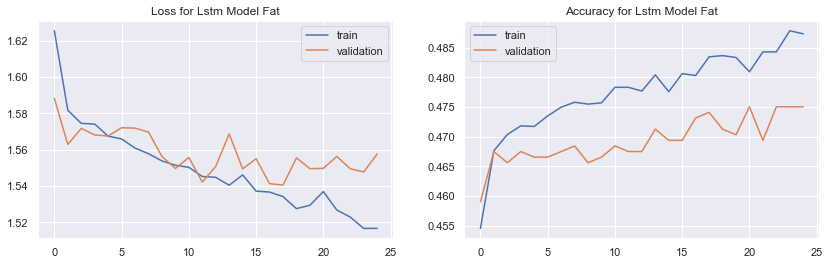

In [103]:
plot_history(history_lstm_fat, 'Lstm Model Fat')

In [104]:
_, lstm_train_acc_fat = model_lstm_fat.evaluate(X_fat_train, Y_fat_train, verbose=0)
_, lstm_test_acc_fat = model_lstm_fat.evaluate(X_fat_test, Y_fat_test, verbose=0)


print(f"LSTM train accuracy fat diet: {lstm_train_acc_fat}")
print(f"LSTM test accuracy fat diet: {lstm_test_acc_fat}")

LSTM train accuracy fat diet: 0.49118340015411377
LSTM test accuracy fat diet: 0.4694570004940033


### LSTM Model for Vancomycin Perturbations

In [105]:
model_lstm_vancomycin = build_lstm(X_fat_train, "lstm_model_vancomycin")
model_lstm_vancomycin.summary()

Model: "lstm_model_vancomycin"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 30, 100)           100000    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 30, 100)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               365568    
_________________________________________________________________
dense_5 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_6 (Dense)              (None, 10)                5130      
Total params: 602,282
Trainable params: 602,282
Non-trainable params: 0
_________________________________________________________________


In [106]:
history_lstm_vancomycin = model_lstm_vancomycin.fit(X_vancomycin_train, 
                                                    Y_vancomycin_train, 
                                                    epochs=epochs, 
                                                    batch_size=batch_size,
                                                    validation_split=0.1,
                                                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, min_delta=0.0001)])

Epoch 1/50
150/150 [==============================] - 30s 203ms/step - loss: 1.6235 - accuracy: 0.4493 - val_loss: 1.5879 - val_accuracy: 0.4430
Epoch 2/50
150/150 [==============================] - 29s 190ms/step - loss: 1.5846 - accuracy: 0.4579 - val_loss: 1.5764 - val_accuracy: 0.4449
Epoch 3/50
150/150 [==============================] - 37s 246ms/step - loss: 1.5821 - accuracy: 0.4599 - val_loss: 1.5847 - val_accuracy: 0.4533
Epoch 4/50
150/150 [==============================] - 33s 218ms/step - loss: 1.5672 - accuracy: 0.4698 - val_loss: 1.5658 - val_accuracy: 0.4647
Epoch 5/50
150/150 [==============================] - 30s 199ms/step - loss: 1.5635 - accuracy: 0.4715 - val_loss: 1.5586 - val_accuracy: 0.4665
Epoch 6/50
150/150 [==============================] - 28s 190ms/step - loss: 1.5554 - accuracy: 0.4756 - val_loss: 1.5577 - val_accuracy: 0.4703
Epoch 7/50
150/150 [==============================] - 35s 231ms/step - loss: 1.5534 - accuracy: 0.4768 - val_loss: 1.5599 - val_ac

<ipython-input-85-aa3ebd3e001e>:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


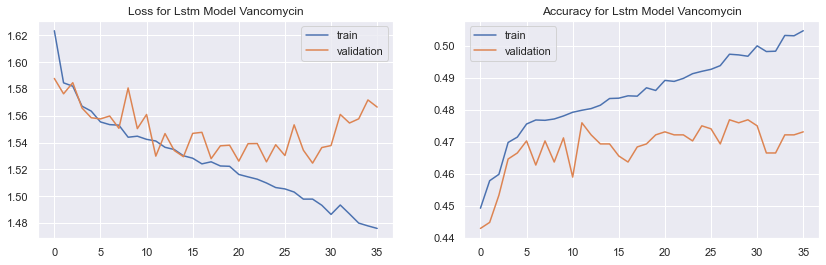

In [107]:
plot_history(history_lstm_vancomycin, 'Lstm Model Vancomycin')

In [108]:
_, lstm_train_acc_vancomycin = model_lstm_vancomycin.evaluate(X_vancomycin_train, Y_vancomycin_train, verbose=0)
_, lstm_test_acc_vancomycin = model_lstm_vancomycin.evaluate(X_vancomycin_test, Y_vancomycin_test, verbose=0)


print(f"LSTM train accuracy vancomycin: {lstm_train_acc_vancomycin}")
print(f"LSTM test accuracy vancomycin: {lstm_test_acc_vancomycin}")

LSTM train accuracy vancomycin: 0.5039132237434387
LSTM test accuracy vancomycin: 0.47624433040618896


### LSTM Model for Gentamicin Perturbations

In [109]:
model_lstm_gentamicin = build_lstm(X_gentamicin_train, "lstm_model_gentamicin")
model_lstm_gentamicin.summary()

Model: "lstm_model_gentamicin"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 30, 100)           100000    
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 30, 100)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 256)               365568    
_________________________________________________________________
dense_7 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_8 (Dense)              (None, 10)                5130      
Total params: 602,282
Trainable params: 602,282
Non-trainable params: 0
_________________________________________________________________


In [110]:
history_lstm_gentamicin = model_lstm_gentamicin.fit(X_gentamicin_train, 
                                                    Y_gentamicin_train, 
                                                    epochs=epochs, 
                                                    batch_size=batch_size,
                                                    validation_split=0.1,
                                                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, min_delta=0.0001)])

Epoch 1/50
150/150 [==============================] - 28s 187ms/step - loss: 1.6237 - accuracy: 0.4467 - val_loss: 1.5902 - val_accuracy: 0.4430
Epoch 2/50
150/150 [==============================] - 28s 184ms/step - loss: 1.5973 - accuracy: 0.4559 - val_loss: 1.6129 - val_accuracy: 0.4430
Epoch 3/50
150/150 [==============================] - 30s 203ms/step - loss: 1.5945 - accuracy: 0.4559 - val_loss: 1.5999 - val_accuracy: 0.4430
Epoch 4/50
150/150 [==============================] - 27s 182ms/step - loss: 1.5915 - accuracy: 0.4559 - val_loss: 1.6030 - val_accuracy: 0.4430
Epoch 5/50
150/150 [==============================] - 29s 194ms/step - loss: 1.5969 - accuracy: 0.4559 - val_loss: 1.6102 - val_accuracy: 0.4430
Epoch 6/50
150/150 [==============================] - 28s 185ms/step - loss: 1.5915 - accuracy: 0.4559 - val_loss: 1.5969 - val_accuracy: 0.4430
Epoch 7/50
150/150 [==============================] - 27s 178ms/step - loss: 1.5922 - accuracy: 0.4559 - val_loss: 1.6089 - val_ac

<ipython-input-85-aa3ebd3e001e>:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


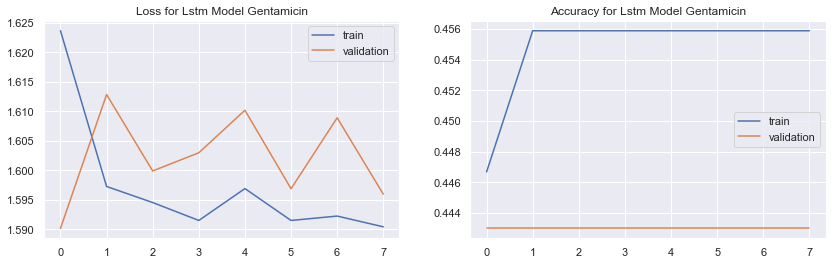

In [111]:
plot_history(history_lstm_gentamicin, 'Lstm Model Gentamicin')

In [112]:
_, lstm_train_acc_gentamicin = model_lstm_gentamicin.evaluate(X_gentamicin_train, Y_gentamicin_train, verbose=0)
_, lstm_test_acc_gentamicin = model_lstm_gentamicin.evaluate(X_gentamicin_test, Y_gentamicin_test, verbose=0)


print(f"LSTM train accuracy gentamicin: {lstm_train_acc_gentamicin}")
print(f"LSTM test accuracy gentamicin: {lstm_test_acc_gentamicin}")

LSTM train accuracy gentamicin: 0.4545968770980835
LSTM test accuracy gentamicin: 0.4524886906147003


We decided to do LSTM models next as an improvement upon the RNN models. An LSTM performs better than an RNN generally because it has three gates that control the cell states: an input gate, an output gate, and a forget gate. The input gate determines what new information to factor into the cell state at the current timestep, while the output gate selects what information from the current cell state to send to the next timestep. Finally, the forget gate controls which information will not be considered in the current cell state necessary and thus will be “forgotten.” These gates in effect are the “memory” of the network, since they effectively can store information all the way from the beginning of the input sequence, while also not taking into account information that should be forgotten as it can cause a misprediction.
 
For the LSTM models, we see that the train and test accuracies vary a lot by the perturbations. 
 
For the fat diet perturbation, we see that the LSTM train and test accuracy for the fat perturbation is much better than that of the naive model. We achieved an accuracy of 49.12% on the train data and 46.95% on the test data. For the vancomycin perturbation, we see that the RNN train and test accuracy is also slightly better than that of the naive model, with an accuracy of 45.82% for the train data and accuracy of 45.17%% for the test data. Finally, for the gentamicin perturbation, we see that similarly to the RNN model, the LSTM model performs the same as the naive model, 45.46% accuracy on the train data and 45.25% accuracy on the test data.
 
 
Overall, the LSTM had a higher accuracy when predicting the both the fat diet perturbation and 46.95% perturbation compared to the RNN.

<a id="biLstm"></a>
## Bidirectional LSTMs

In [113]:
def build_bidrectional_lstm(X, name="bidirectional_lstm_model", n_units=128):
    
    model = keras.Sequential(name='bidirectional_lstm_model')
    model.add(layers.Embedding(embedding_input_dimension, embedding_dim, input_length=X.shape[1]))
    model.add(layers.Bidirectional(layers.LSTM(2*n_units))) 
    model.add(layers.Dense(n_units*4, activation="relu"))
    model.add(layers.Dense(classes,activation="sigmoid"))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

### Bidirection LSTM Model for Fat Diet Perturbations

In [114]:
model_bidirectional_lstm_fat = build_bidrectional_lstm(X_fat_train, "bidirectional_lstm_model_fat")
model_bidirectional_lstm_fat.summary()

Model: "bidirectional_lstm_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 30, 100)           100000    
_________________________________________________________________
bidirectional (Bidirectional (None, 512)               731136    
_________________________________________________________________
dense_9 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_10 (Dense)             (None, 10)                5130      
Total params: 1,098,922
Trainable params: 1,098,922
Non-trainable params: 0
_________________________________________________________________


In [115]:
history_bidrectional_lstm_fat = model_bidirectional_lstm_fat.fit(X_fat_train, 
                                                                 Y_fat_train,
                                                                 epochs=epochs,
                                                                 batch_size=batch_size,
                                                                 validation_split=0.1,
                                                                 callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, min_delta=0.0001)])

Epoch 1/50
150/150 [==============================] - 31s 204ms/step - loss: 1.6454 - accuracy: 0.4537 - val_loss: 1.6159 - val_accuracy: 0.4430
Epoch 2/50
150/150 [==============================] - 30s 200ms/step - loss: 1.5846 - accuracy: 0.4563 - val_loss: 1.5921 - val_accuracy: 0.4430
Epoch 3/50
150/150 [==============================] - 32s 213ms/step - loss: 1.5799 - accuracy: 0.4568 - val_loss: 1.5779 - val_accuracy: 0.4477
Epoch 4/50
150/150 [==============================] - 29s 196ms/step - loss: 1.5721 - accuracy: 0.4575 - val_loss: 1.5706 - val_accuracy: 0.4439
Epoch 5/50
150/150 [==============================] - 31s 205ms/step - loss: 1.5683 - accuracy: 0.4581 - val_loss: 1.5627 - val_accuracy: 0.4477
Epoch 6/50
150/150 [==============================] - 32s 211ms/step - loss: 1.5660 - accuracy: 0.4583 - val_loss: 1.5531 - val_accuracy: 0.4486
Epoch 7/50
150/150 [==============================] - 31s 204ms/step - loss: 1.5607 - accuracy: 0.4580 - val_loss: 1.5660 - val_ac

<ipython-input-85-aa3ebd3e001e>:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


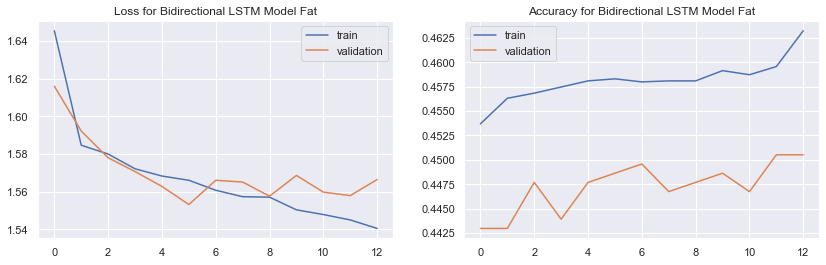

In [116]:
plot_history(history_bidrectional_lstm_fat, 'Bidirectional LSTM Model Fat')

In [117]:
_, bidirectional_lstm_train_acc_fat = model_bidirectional_lstm_fat.evaluate(X_fat_train, Y_fat_train, verbose=0)
_, bidirectional_lstm_test_acc_fat = model_bidirectional_lstm_fat.evaluate(X_fat_test, Y_fat_test, verbose=0)


print(f"Bidrectional LSTM train accuracy for fat diet perturbation: {bidirectional_lstm_train_acc_fat}")
print(f"Bidrectional LSTM test accuracy for fat diet perturbation: {bidirectional_lstm_test_acc_fat}")

Bidrectional LSTM train accuracy for fat diet perturbation: 0.4615747332572937
Bidrectional LSTM test accuracy for fat diet perturbation: 0.45512819290161133


### Bidirection LSTM Model for Vancomycin Perturbations

In [118]:
model_bidirectional_lstm_vancomycin = build_bidrectional_lstm(X_vancomycin_train, "bidirectional_lstm_model_vancomycin")
model_bidirectional_lstm_vancomycin.summary()

Model: "bidirectional_lstm_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 30, 100)           100000    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 512)               731136    
_________________________________________________________________
dense_11 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_12 (Dense)             (None, 10)                5130      
Total params: 1,098,922
Trainable params: 1,098,922
Non-trainable params: 0
_________________________________________________________________


In [119]:
history_bidrectional_lstm_vancomycin = model_bidirectional_lstm_vancomycin.fit(X_vancomycin_train, 
                                                                               Y_vancomycin_train, 
                                                                               epochs=epochs, 
                                                                               batch_size=batch_size,
                                                                               validation_split=0.1,
                                                                               callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, min_delta=0.0001)])

Epoch 1/50
150/150 [==============================] - 31s 205ms/step - loss: 1.6374 - accuracy: 0.4535 - val_loss: 1.6031 - val_accuracy: 0.4430
Epoch 2/50
150/150 [==============================] - 27s 177ms/step - loss: 1.5973 - accuracy: 0.4560 - val_loss: 1.5906 - val_accuracy: 0.4430
Epoch 3/50
150/150 [==============================] - 25s 168ms/step - loss: 1.5819 - accuracy: 0.4561 - val_loss: 1.5769 - val_accuracy: 0.4430
Epoch 4/50
150/150 [==============================] - 25s 165ms/step - loss: 1.5701 - accuracy: 0.4567 - val_loss: 1.5834 - val_accuracy: 0.4533
Epoch 5/50
150/150 [==============================] - 24s 163ms/step - loss: 1.5697 - accuracy: 0.4581 - val_loss: 1.5643 - val_accuracy: 0.4524
Epoch 6/50
150/150 [==============================] - 28s 186ms/step - loss: 1.5655 - accuracy: 0.4575 - val_loss: 1.5652 - val_accuracy: 0.4543
Epoch 7/50
150/150 [==============================] - 30s 202ms/step - loss: 1.5648 - accuracy: 0.4589 - val_loss: 1.5699 - val_ac

<ipython-input-85-aa3ebd3e001e>:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


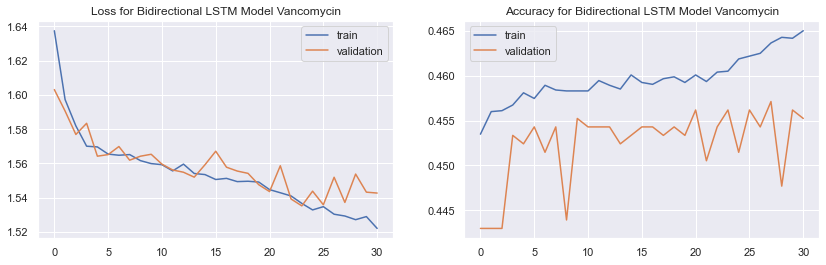

In [120]:
plot_history(history_bidrectional_lstm_vancomycin, 'Bidirectional LSTM Model Vancomycin')

In [121]:
_, bidirectional_lstm_train_acc_vancomycin = model_bidirectional_lstm_vancomycin.evaluate(X_vancomycin_train, Y_vancomycin_train, verbose=0)
_, bidirectional_lstm_test_acc_vancomycin = model_bidirectional_lstm_vancomycin.evaluate(X_vancomycin_test, Y_vancomycin_test, verbose=0)


print(f"Bidrectional LSTM train accuracy for vancomycin perturbation: {bidirectional_lstm_train_acc_vancomycin}")
print(f"Bidrectional LSTM test accuracy for vancomycin perturbation: {bidirectional_lstm_test_acc_vancomycin}")

Bidrectional LSTM train accuracy for vancomycin perturbation: 0.46638378500938416
Bidrectional LSTM test accuracy for vancomycin perturbation: 0.45625942945480347


### Bidirection LSTM Model for Gentamicin Perturbations

In [122]:
model_bidirectional_lstm_gentamicin = build_bidrectional_lstm(X_gentamicin_train, "bidirectional_lstm_model_gentamicin")
model_bidirectional_lstm_gentamicin.summary()

Model: "bidirectional_lstm_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 30, 100)           100000    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 512)               731136    
_________________________________________________________________
dense_13 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_14 (Dense)             (None, 10)                5130      
Total params: 1,098,922
Trainable params: 1,098,922
Non-trainable params: 0
_________________________________________________________________


In [123]:
history_bidrectional_lstm_gentamicin = model_bidirectional_lstm_gentamicin.fit(X_gentamicin_train, 
                                                                               Y_gentamicin_train, 
                                                                               epochs=epochs, 
                                                                               batch_size=batch_size,
                                                                               validation_split=0.1,
                                                                               callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, min_delta=0.0001)])

Epoch 1/50
150/150 [==============================] - 30s 197ms/step - loss: 1.6421 - accuracy: 0.4528 - val_loss: 1.6122 - val_accuracy: 0.4430
Epoch 2/50
150/150 [==============================] - 33s 221ms/step - loss: 1.6005 - accuracy: 0.4559 - val_loss: 1.5993 - val_accuracy: 0.4430
Epoch 3/50
150/150 [==============================] - 27s 182ms/step - loss: 1.5979 - accuracy: 0.4559 - val_loss: 1.6004 - val_accuracy: 0.4430
Epoch 4/50
150/150 [==============================] - 28s 188ms/step - loss: 1.5940 - accuracy: 0.4559 - val_loss: 1.5926 - val_accuracy: 0.4430
Epoch 5/50
150/150 [==============================] - 25s 166ms/step - loss: 1.5926 - accuracy: 0.4559 - val_loss: 1.5929 - val_accuracy: 0.4430
Epoch 6/50
150/150 [==============================] - 26s 176ms/step - loss: 1.5932 - accuracy: 0.4559 - val_loss: 1.5936 - val_accuracy: 0.4430
Epoch 7/50
150/150 [==============================] - 27s 178ms/step - loss: 1.5919 - accuracy: 0.4559 - val_loss: 1.5980 - val_ac

<ipython-input-85-aa3ebd3e001e>:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


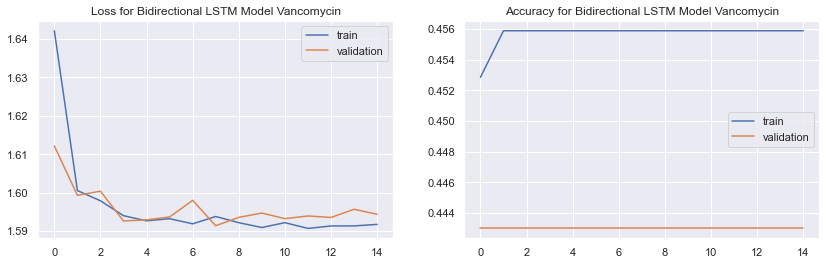

In [124]:
plot_history(history_bidrectional_lstm_gentamicin, 'Bidirectional LSTM Model Vancomycin')

In [125]:
_, bidirectional_lstm_train_acc_gentamicin = model_bidirectional_lstm_gentamicin.evaluate(X_gentamicin_train, Y_gentamicin_train, verbose=0)
_, bidirectional_lstm_test_acc_gentamicin = model_bidirectional_lstm_gentamicin.evaluate(X_gentamicin_test, Y_gentamicin_test, verbose=0)


print(f"Bidrectional LSTM train accuracy for gentamicin perturbation: {bidirectional_lstm_train_acc_gentamicin}")
print(f"Bidrectional LSTM test accuracy for gentamicin perturbation: {bidirectional_lstm_test_acc_gentamicin}")

Bidrectional LSTM train accuracy for gentamicin perturbation: 0.4545968770980835
Bidrectional LSTM test accuracy for gentamicin perturbation: 0.4524886906147003


Next, we tried the Bidirectional LSTM as an improvement to LSTM. The Bidirectional LSTM performs slightly better than the regular LSTM because it essentially runs the LSTM in both directions of the times series sequence. The output of both directions is combined to produce one final classification. This tends to perform better because it is able to learn the information from both sides of the input sequence, which can provide additional context and even speed up the network’s learning process.
 
For the Bidirectional LSTM models, we see that the train and test accuracies also vary a lot by the perturbations. 
 
For the fat diet perturbation, we see that the Bidirectional LSTM train and test accuracy for the fat perturbation is around the same compared to that of the naive model. We achieved an accuracy of 45.51% on the train data and 45.51% on the test data. For the vancomycin perturbation, we see that the Bidirectional LSTM train and test accuracy is also slightly better than that of the naive model, with an accuracy of 45.63% for the train data and accuracy of 45.63%% for the test data. Finally, for the gentamicin perturbation, we see that similarly to the other models, the Bidirectional LSTM model also performs the same as the naive model, 45.46% accuracy on the train data and 45.25% accuracy on the test data.
 
 
Overall, the Bidirectional LSTM had a lower accuracy compared to the LSTM on the fat diet and vancomycin perturbations.

<a id="gru"></a>
## GRU

In [126]:
def build_gru(X, name="gru_model", n_units=128):
    # Create an GRU Model
    model = keras.Sequential(name=name)
    model.add(layers.Embedding(embedding_input_dimension, embedding_dim, input_length=X.shape[1]))
    model.add(layers.Bidirectional(layers.GRU(2*n_units))) 
#     model.add(layers.GRU(n_units)) 
    
    model.add(layers.Dense(n_units*4, activation="relu"))
    model.add(layers.Dense(classes,activation="softmax"))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

### GRU Model for Fat Diet Perturbations

In [127]:
model_bidirectional_gru_fat = build_gru(X_fat_train, "gru_model_fat")
model_bidirectional_gru_fat.summary()

Model: "gru_model_fat"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 30, 100)           100000    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 512)               549888    
_________________________________________________________________
dense_15 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_16 (Dense)             (None, 10)                5130      
Total params: 917,674
Trainable params: 917,674
Non-trainable params: 0
_________________________________________________________________


In [128]:
history_bidrectional_gru_fat = model_bidirectional_gru_fat.fit(X_fat_train, 
                                                               Y_fat_train, 
                                                               epochs=epochs, 
                                                               batch_size=batch_size,
                                                               validation_split=0.1,
                                                               callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, min_delta=0.0001)])

Epoch 1/50
150/150 [==============================] - 24s 157ms/step - loss: 1.6174 - accuracy: 0.4530 - val_loss: 1.5856 - val_accuracy: 0.4618
Epoch 2/50
150/150 [==============================] - 24s 157ms/step - loss: 1.5767 - accuracy: 0.4692 - val_loss: 1.5645 - val_accuracy: 0.4675
Epoch 3/50
150/150 [==============================] - 25s 169ms/step - loss: 1.5716 - accuracy: 0.4711 - val_loss: 1.5631 - val_accuracy: 0.4703
Epoch 4/50
150/150 [==============================] - 27s 180ms/step - loss: 1.5698 - accuracy: 0.4742 - val_loss: 1.5668 - val_accuracy: 0.4665
Epoch 5/50
150/150 [==============================] - 24s 159ms/step - loss: 1.5588 - accuracy: 0.4747 - val_loss: 1.5769 - val_accuracy: 0.4665
Epoch 6/50
150/150 [==============================] - 23s 151ms/step - loss: 1.5568 - accuracy: 0.4760 - val_loss: 1.5645 - val_accuracy: 0.4665
Epoch 7/50
150/150 [==============================] - 24s 163ms/step - loss: 1.5526 - accuracy: 0.4779 - val_loss: 1.5650 - val_ac

<ipython-input-85-aa3ebd3e001e>:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


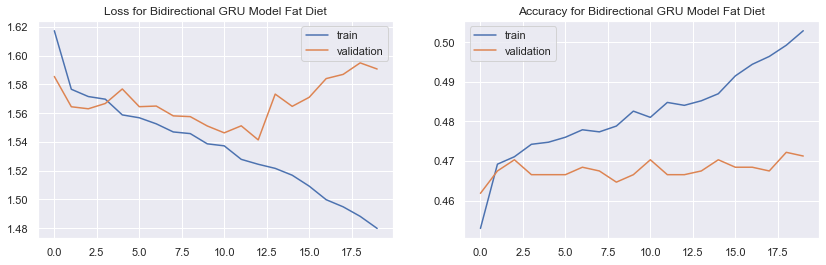

In [129]:
plot_history(history_bidrectional_gru_fat, 'Bidirectional GRU Model Fat Diet')

In [130]:
_, bidirectional_gru_train_acc_fat = model_bidirectional_gru_fat.evaluate(X_fat_train, Y_fat_train, verbose=0)
_, bidirectional_gru_test_acc_fat = model_bidirectional_gru_fat.evaluate(X_fat_test, Y_fat_test, verbose=0)


print(f"GRU train accuracy: {bidirectional_gru_train_acc_fat}")
print(f"GRU test accuracy: {bidirectional_gru_test_acc_fat}")

GRU train accuracy: 0.5051391124725342
GRU test accuracy: 0.4698340892791748


### GRU Model for Vancomycin  Perturbations

In [131]:
model_bidirectional_gru_vancomycin = build_gru(X_vancomycin_train, "gru_model_vancomycin")
model_bidirectional_gru_vancomycin.summary()

Model: "gru_model_vancomycin"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 30, 100)           100000    
_________________________________________________________________
bidirectional_4 (Bidirection (None, 512)               549888    
_________________________________________________________________
dense_17 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_18 (Dense)             (None, 10)                5130      
Total params: 917,674
Trainable params: 917,674
Non-trainable params: 0
_________________________________________________________________


In [132]:
history_bidrectional_gru_vancomycin = model_bidirectional_gru_vancomycin.fit(X_vancomycin_train, 
                                                               Y_vancomycin_train, 
                                                               epochs=epochs, 
                                                               batch_size=batch_size,
                                                               validation_split=0.1,
                                                               callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, min_delta=0.0001)])

Epoch 1/50
150/150 [==============================] - 21s 142ms/step - loss: 1.6147 - accuracy: 0.4557 - val_loss: 1.5901 - val_accuracy: 0.4449
Epoch 2/50
150/150 [==============================] - 25s 169ms/step - loss: 1.5845 - accuracy: 0.4586 - val_loss: 1.5881 - val_accuracy: 0.4496
Epoch 3/50
150/150 [==============================] - 22s 147ms/step - loss: 1.5806 - accuracy: 0.4587 - val_loss: 1.5789 - val_accuracy: 0.4533
Epoch 4/50
150/150 [==============================] - 20s 135ms/step - loss: 1.5786 - accuracy: 0.4587 - val_loss: 1.5791 - val_accuracy: 0.4533
Epoch 5/50
150/150 [==============================] - 21s 137ms/step - loss: 1.5691 - accuracy: 0.4663 - val_loss: 1.5548 - val_accuracy: 0.4665
Epoch 6/50
150/150 [==============================] - 20s 133ms/step - loss: 1.5599 - accuracy: 0.4740 - val_loss: 1.5577 - val_accuracy: 0.4665
Epoch 7/50
150/150 [==============================] - 19s 124ms/step - loss: 1.5567 - accuracy: 0.4760 - val_loss: 1.5538 - val_ac

<ipython-input-85-aa3ebd3e001e>:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


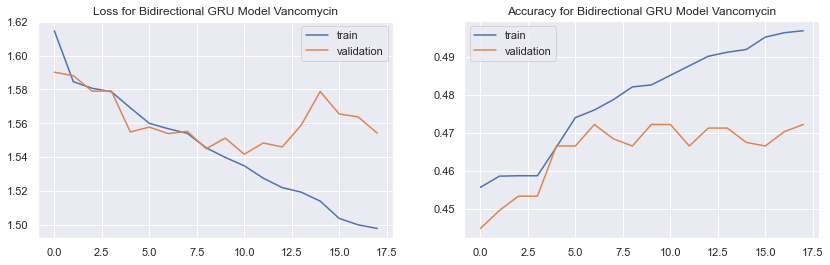

In [133]:
plot_history(history_bidrectional_gru_vancomycin, 'Bidirectional GRU Model Vancomycin')

In [134]:
_, bidirectional_gru_train_acc_vancomycin = model_bidirectional_gru_vancomycin.evaluate(X_vancomycin_train, Y_vancomycin_train, verbose=0)
_, bidirectional_gru_test_acc_vancomycin = model_bidirectional_gru_vancomycin.evaluate(X_vancomycin_test, Y_vancomycin_test, verbose=0)


print(f"GRU train accuracy: {bidirectional_gru_train_acc_vancomycin}")
print(f"GRU test accuracy: {bidirectional_gru_test_acc_vancomycin}")

GRU train accuracy: 0.5011786818504333
GRU test accuracy: 0.47586727142333984


### GRU Model for Gentamicin Perturbations

In [135]:
model_bidirectional_gru_gentamicin = build_gru(X_gentamicin_train, "gru_model_gentamicin")
model_bidirectional_gru_gentamicin.summary()

Model: "gru_model_gentamicin"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 30, 100)           100000    
_________________________________________________________________
bidirectional_5 (Bidirection (None, 512)               549888    
_________________________________________________________________
dense_19 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_20 (Dense)             (None, 10)                5130      
Total params: 917,674
Trainable params: 917,674
Non-trainable params: 0
_________________________________________________________________


In [136]:
history_bidrectional_gru_gentamicin = model_bidirectional_gru_gentamicin.fit(X_gentamicin_train, 
                                                               Y_gentamicin_train, 
                                                               epochs=epochs, 
                                                               batch_size=batch_size,
                                                               validation_split=0.1,
                                                               callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, min_delta=0.0001)])

Epoch 1/50
150/150 [==============================] - 24s 161ms/step - loss: 1.6217 - accuracy: 0.4505 - val_loss: 1.5944 - val_accuracy: 0.4430
Epoch 2/50
150/150 [==============================] - 23s 152ms/step - loss: 1.5977 - accuracy: 0.4559 - val_loss: 1.6061 - val_accuracy: 0.4430
Epoch 3/50
150/150 [==============================] - 24s 161ms/step - loss: 1.5957 - accuracy: 0.4559 - val_loss: 1.6134 - val_accuracy: 0.4430
Epoch 4/50
150/150 [==============================] - 24s 158ms/step - loss: 1.5977 - accuracy: 0.4559 - val_loss: 1.5998 - val_accuracy: 0.4430
Epoch 5/50
150/150 [==============================] - 21s 138ms/step - loss: 1.5925 - accuracy: 0.4559 - val_loss: 1.6066 - val_accuracy: 0.4430
Epoch 6/50
150/150 [==============================] - 21s 142ms/step - loss: 1.5928 - accuracy: 0.4559 - val_loss: 1.5985 - val_accuracy: 0.4430
Epoch 7/50
150/150 [==============================] - 22s 144ms/step - loss: 1.5927 - accuracy: 0.4559 - val_loss: 1.5936 - val_ac

<ipython-input-85-aa3ebd3e001e>:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


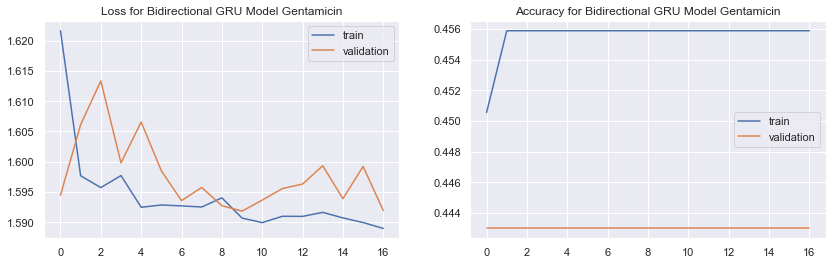

In [137]:
plot_history(history_bidrectional_gru_gentamicin, 'Bidirectional GRU Model Gentamicin')

In [138]:
_, bidirectional_gru_train_acc_gentamicin = model_bidirectional_gru_gentamicin.evaluate(X_gentamicin_train, Y_gentamicin_train, verbose=0)
_, bidirectional_gru_test_acc_gentamicin = model_bidirectional_gru_gentamicin.evaluate(X_gentamicin_test, Y_gentamicin_test, verbose=0)


print(f"GRU train accuracy: {bidirectional_gru_train_acc_gentamicin}")
print(f"GRU test accuracy: {bidirectional_gru_test_acc_gentamicin}")

GRU train accuracy: 0.4545968770980835
GRU test accuracy: 0.4524886906147003


Next, we tried using a GRU model. A GRU is generally very similar to the LSTM, in that it uses gates to provide a form of memory by remembering important information and discarding unimportant information. However, it does so with less architecture. It does not use a cell state but rather uses the hidden state directly. It also only has two gates instead of three, the update gate and the reset gate. Roughly speaking, the update gate determines what information to include and which information to not include, and the reset gate controls how much information to discard. Because it has less architecture, a GRU tends to train faster than an LSTM. However, an LSTM is a bit more thorough in delegating smaller tasks to more gates, and intuitively would seem to perform slightly better on certain datasets. In this case, we do observe that the LSTM slightly improves the GRU’s performance, though it is quite close, as expected. As before, a Bidirectional GRU has the added benefit of considering information in both directions, thus potentially using the additional context to learn more quickly.
 
For the GRU models, we see that the train and test accuracies also vary a lot by the perturbations. 
 
For the fat diet perturbation, we see that the GRU train and test accuracy for the fat perturbation is much higher compared to that of the naive model. We achieved an accuracy of 50.51% on the train data and 46.98% on the test data. For the vancomycin perturbation, we see that the GRU train and test accuracy is also better than that of the naive model, with an accuracy of 50.51% for the train data and accuracy of 47.59% for the test data. Finally, for the gentamicin perturbation, we see that similarly to the other models, the GRU model also performs the same as the naive model, 45.46% accuracy on the train data and 45.25% accuracy on the test data.
 
 
Overall, the GRU had a higher train accuracy compared to the LSTM but lower test accuracy for the fat diet and vancomycin perturbation.

<a id="cnn"></a>
## CNN

In [139]:
# X_train_cnn = X_train.reshape(X_train.shape[0],X_train.shape[1], 1)
# X_test_cnn = X_test.reshape(X_test.shape[0],X_test.shape[1], 1)

# print(f"X_train_cnn shape: {X_train_cnn.shape}, X_test_cnn shape: {X_test_cnn.shape}")

X_fat_train_cnn = X_fat_train.reshape(X_fat_train.shape[0],X_fat_train.shape[1], 1)
X_fat_test_cnn = X_fat_test.reshape(X_fat_test.shape[0],X_fat_test.shape[1], 1)

X_vancomycin_train_cnn = X_vancomycin_train.reshape(X_vancomycin_train.shape[0],X_vancomycin_train.shape[1], 1)
X_vancomycin_test_cnn = X_vancomycin_test.reshape(X_vancomycin_test.shape[0],X_vancomycin_test.shape[1], 1)

X_gentamicin_train_cnn = X_gentamicin_train.reshape(X_gentamicin_train.shape[0],X_gentamicin_train.shape[1], 1)
X_gentamicin_test_cnn = X_gentamicin_test.reshape(X_gentamicin_test.shape[0],X_gentamicin_test.shape[1], 1)

print(f"X_fat_train_cnn shape: {X_fat_train_cnn.shape}, X_fat_test_cnn shape: {X_fat_test_cnn.shape}")
print(f"X_vancomycin_train_cnn shape: {X_vancomycin_train_cnn.shape}, X_vancomycin_test_cnn shape: {X_vancomycin_test_cnn.shape}")
print(f"X_gentamicin_train_cnn shape: {X_gentamicin_train_cnn.shape}, X_gentamicin_test_cnn shape: {X_gentamicin_test_cnn.shape}")

X_fat_train_cnn shape: (10605, 30, 1), X_fat_test_cnn shape: (2652, 30, 1)
X_vancomycin_train_cnn shape: (10605, 30, 1), X_vancomycin_test_cnn shape: (2652, 30, 1)
X_gentamicin_train_cnn shape: (10605, 30, 1), X_gentamicin_test_cnn shape: (2652, 30, 1)


In [140]:
def build_cnn(X_train):    
    input_shape =(X_train.shape[1], 1)
    model = keras.Sequential()
    model.add(layers.Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(layers.Conv1D(filters=256, kernel_size=3, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.Flatten())
    model.add(layers.Dense(200, activation='relu'))
    model.add(layers.Dense(classes, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [ ]:
X_train_cnn = X_train.reshape(X_train.shape[0],X_train.shape[1], 1)
X_test_cnn = X_test.reshape(X_test.shape[0],X_test.shape[1], 1)

print(f"X_train_cnn shape: {X_train_cnn.shape}, X_test_cnn shape: {X_test_cnn.shape}")

### GRU Model for Fat Diet Perturbations

In [141]:
model_cnn_fat = build_cnn(X_fat_train_cnn) 
model_cnn_fat.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 28, 128)           512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 26, 256)           98560     
_________________________________________________________________
dropout_3 (Dropout)          (None, 26, 256)           0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 13, 256)           0         
_________________________________________________________________
flatten (Flatten)            (None, 3328)              0         
_________________________________________________________________
dense_21 (Dense)             (None, 200)               665800    
_________________________________________________________________
dense_22 (Dense)             (None, 10)                2

In [142]:
history_cnn_fat = model_cnn_fat.fit(X_fat_train_cnn, Y_fat_train, 
                                    epochs=epochs, 
                                    batch_size=batch_size,
                                    validation_split=0.1)

Epoch 1/50
150/150 [==============================] - 3s 20ms/step - loss: 1.6398 - accuracy: 0.4439 - val_loss: 1.6681 - val_accuracy: 0.4430
Epoch 2/50
150/150 [==============================] - 3s 20ms/step - loss: 1.6086 - accuracy: 0.4540 - val_loss: 1.6195 - val_accuracy: 0.4430
Epoch 3/50
150/150 [==============================] - 3s 21ms/step - loss: 1.6023 - accuracy: 0.4553 - val_loss: 1.6243 - val_accuracy: 0.4430
Epoch 4/50
150/150 [==============================] - 3s 21ms/step - loss: 1.5976 - accuracy: 0.4559 - val_loss: 1.6579 - val_accuracy: 0.4430
Epoch 5/50
150/150 [==============================] - 3s 19ms/step - loss: 1.5962 - accuracy: 0.4541 - val_loss: 1.6699 - val_accuracy: 0.4430
Epoch 6/50
150/150 [==============================] - 3s 21ms/step - loss: 1.5924 - accuracy: 0.4559 - val_loss: 1.6103 - val_accuracy: 0.4430
Epoch 7/50
150/150 [==============================] - 3s 20ms/step - loss: 1.5923 - accuracy: 0.4559 - val_loss: 1.6514 - val_accuracy: 0.4430

<ipython-input-85-aa3ebd3e001e>:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


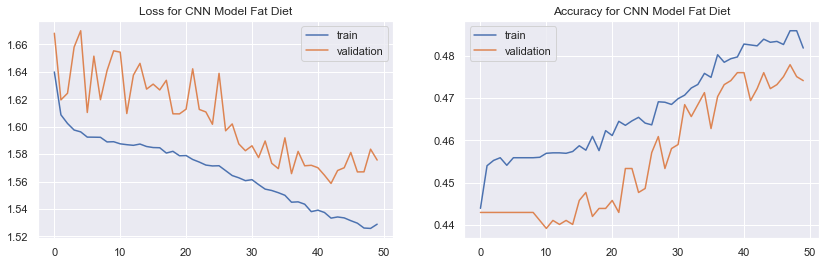

In [143]:
plot_history(history_cnn_fat, 'CNN Model Fat Diet')

In [144]:
_, cnn_train_acc_fat = model_cnn_fat.evaluate(X_fat_train_cnn, Y_fat_train, verbose=0)
_, cnn_test_acc_fat = model_cnn_fat.evaluate(X_fat_test_cnn, Y_fat_test, verbose=0)


print(f"CNN train accuracy: {cnn_train_acc_fat}")
print(f"CNN test accuracy: {cnn_test_acc_fat}")

CNN train accuracy: 0.4913719892501831
CNN test accuracy: 0.4717194437980652


### GRU Model for Vancomycin Perturbations

In [145]:
model_cnn_vancomycin  = build_cnn(X_vancomycin_train_cnn) 
model_cnn_vancomycin.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 28, 128)           512       
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 26, 256)           98560     
_________________________________________________________________
dropout_4 (Dropout)          (None, 26, 256)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 13, 256)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3328)              0         
_________________________________________________________________
dense_23 (Dense)             (None, 200)               665800    
_________________________________________________________________
dense_24 (Dense)             (None, 10)               

In [146]:
history_cnn_vancomycin = model_cnn_vancomycin.fit(X_vancomycin_train_cnn, Y_vancomycin_train, 
                                    epochs=epochs, 
                                    batch_size=batch_size,
                                    validation_split=0.1)

Epoch 1/50
150/150 [==============================] - 5s 34ms/step - loss: 1.7001 - accuracy: 0.4418 - val_loss: 1.6361 - val_accuracy: 0.4430
Epoch 2/50
150/150 [==============================] - 3s 17ms/step - loss: 1.6089 - accuracy: 0.4526 - val_loss: 1.6926 - val_accuracy: 0.4430
Epoch 3/50
150/150 [==============================] - 3s 19ms/step - loss: 1.6033 - accuracy: 0.4554 - val_loss: 1.7032 - val_accuracy: 0.4590
Epoch 4/50
150/150 [==============================] - 3s 19ms/step - loss: 1.5995 - accuracy: 0.4555 - val_loss: 1.6337 - val_accuracy: 0.4430
Epoch 5/50
150/150 [==============================] - 5s 32ms/step - loss: 1.5924 - accuracy: 0.4556 - val_loss: 1.6127 - val_accuracy: 0.4430
Epoch 6/50
150/150 [==============================] - 3s 17ms/step - loss: 1.5929 - accuracy: 0.4558 - val_loss: 1.6127 - val_accuracy: 0.4430
Epoch 7/50
150/150 [==============================] - 3s 20ms/step - loss: 1.5903 - accuracy: 0.4587 - val_loss: 1.6206 - val_accuracy: 0.4496

<ipython-input-85-aa3ebd3e001e>:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


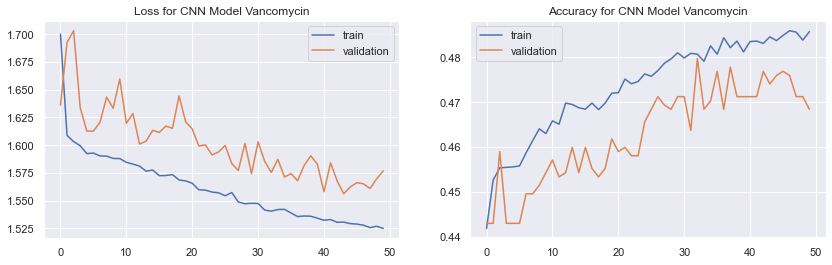

In [147]:
plot_history(history_cnn_vancomycin, 'CNN Model Vancomycin')

In [148]:
_, cnn_train_acc_vancomycin = model_cnn_vancomycin.evaluate(X_vancomycin_train_cnn, Y_vancomycin_train, verbose=0)
_, cnn_test_acc_vancomycin = model_cnn_vancomycin.evaluate(X_vancomycin_test_cnn, Y_vancomycin_test, verbose=0)


print(f"CNN train accuracy vancomycin: {cnn_train_acc_vancomycin}")
print(f"CNN test accuracy vancomycin: {cnn_test_acc_vancomycin}")

CNN train accuracy vancomycin: 0.48599717020988464
CNN test accuracy vancomycin: 0.4724735915660858


### GRU Model for Gentamicin Perturbations

In [149]:
model_cnn_gentamicin = build_cnn(X_gentamicin_train_cnn) 
model_cnn_gentamicin.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 28, 128)           512       
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 26, 256)           98560     
_________________________________________________________________
dropout_5 (Dropout)          (None, 26, 256)           0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 13, 256)           0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 3328)              0         
_________________________________________________________________
dense_25 (Dense)             (None, 200)               665800    
_________________________________________________________________
dense_26 (Dense)             (None, 10)               

In [150]:
history_cnn_gentamicin = model_cnn_gentamicin.fit(X_gentamicin_train_cnn, Y_gentamicin_train, 
                                    epochs=epochs, 
                                    batch_size=batch_size,
                                    validation_split=0.1)

Epoch 1/50
150/150 [==============================] - 5s 31ms/step - loss: 1.6332 - accuracy: 0.4532 - val_loss: 1.6186 - val_accuracy: 0.4430
Epoch 2/50
150/150 [==============================] - 5s 31ms/step - loss: 1.5940 - accuracy: 0.4559 - val_loss: 1.6692 - val_accuracy: 0.4430
Epoch 3/50
150/150 [==============================] - 5s 34ms/step - loss: 1.5947 - accuracy: 0.4559 - val_loss: 1.6487 - val_accuracy: 0.4430
Epoch 4/50
150/150 [==============================] - 5s 36ms/step - loss: 1.5943 - accuracy: 0.4559 - val_loss: 1.6619 - val_accuracy: 0.4430
Epoch 5/50
150/150 [==============================] - 3s 23ms/step - loss: 1.5919 - accuracy: 0.4559 - val_loss: 1.6307 - val_accuracy: 0.4430
Epoch 6/50
150/150 [==============================] - 3s 19ms/step - loss: 1.5994 - accuracy: 0.4559 - val_loss: 1.6111 - val_accuracy: 0.4430
Epoch 7/50
150/150 [==============================] - 3s 18ms/step - loss: 1.5925 - accuracy: 0.4559 - val_loss: 1.6452 - val_accuracy: 0.4430

<ipython-input-85-aa3ebd3e001e>:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


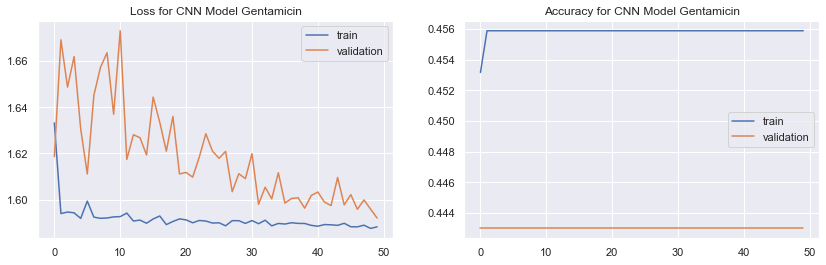

In [151]:
plot_history(history_cnn_gentamicin, 'CNN Model Gentamicin')

In [152]:
_, cnn_train_acc_gentamicin = model_cnn_gentamicin.evaluate(X_gentamicin_train_cnn, Y_gentamicin_train, verbose=0)
_, cnn_test_acc_gentamicin = model_cnn_gentamicin.evaluate(X_gentamicin_test_cnn, Y_gentamicin_test, verbose=0)


print(f"CNN train accuracy gentamicin: {cnn_train_acc_gentamicin}")
print(f"CNN test accuracy gentamicin: {cnn_test_acc_gentamicin}")

CNN train accuracy gentamicin: 0.4545968770980835
CNN test accuracy gentamicin: 0.4524886906147003


Finally, we tried a CNN model for time series classification to compare with the NLP models that we tried. A CNN should be good at capturing the temporal patterns of our time series dataset because the network’s filters are also trainable parameters. Our CNN model performs really well, when compared to the other models. It’s one of the best ones. This could be because convolutional networks are good at extracting high level features that are important in making a classification prediction. Our CNN architecture uses two convolutional layers, with 64 filters and a kernel size of 3. The result of this operation is several feature maps that are the first step towards learning certain higher level trends in our time series data. We then add an additional max pooling layer to reduce the dimensionality even further in order to try and learn even more dominant features to aid us in classification. Our final layer is a dense layer to predict the appropriate number of classes. Because of these layers, it appears that our CNN is able to capture the more dominant features better than our other models, which is why the classification appears to be a bit better. 
 
For the CNN models, we see that the train and test accuracies also vary a lot by the perturbations. 
 
For the fat diet perturbation, we see that the CNN train and test accuracy for the fat perturbation is higher compared to that of the naive model. We achieved an accuracy of 49.14% on the train data and 47.17% on the test data. For the vancomycin perturbation, we see that the GRU train and test accuracy is also better than that of the naive model, with an accuracy of 48.60% for the train data and accuracy of 47.25% for the test data. Finally, for the gentamicin perturbation, we see that similarly to the other models, the GRU model also performs the same as the naive model, 45.46% accuracy on the train data and 45.25% accuracy on the test data.

### Results

In [153]:
print("Fat Diet Perturbation")

print(f"RNN train accuracy fat diet: {rnn_train_acc_fat}")
print(f"RNN test accuracy fat diet: {rnn_test_acc_fat}")

print(f"LSTM train accuracy fat diet: {lstm_train_acc_fat}")
print(f"LSTM test accuracy fat diet: {lstm_test_acc_fat}")

print(f"Bidirectional LSTM train accuracy fat diet: {bidirectional_lstm_test_acc_fat}")
print(f"Bidirectional LSTM test accuracy fat diet: {bidirectional_lstm_test_acc_fat}")

print(f"GRU train accuracy fat diet: {bidirectional_gru_train_acc_fat}")
print(f"GRU test accuracy fat diet: {bidirectional_gru_test_acc_fat}")

print(f"CNN train accuracy fat diet: {cnn_train_acc_fat}")
print(f"CNN test accuracy fat diet: {cnn_test_acc_fat}")

print("Vancomycin Perturbation")

print(f"RNN train accuracy vancomycin: {rnn_train_acc_vancomycin}")
print(f"RNN test accuracy vancomycin: {rnn_test_acc_vancomycin}")

print(f"LSTM train accuracy vancomycin: {lstm_train_acc_vancomycin}")
print(f"LSTM test accuracy vancomycin: {lstm_test_acc_vancomycin}")

print(f"Bidirectional LSTM train accuracy vancomycin: {bidirectional_lstm_test_acc_vancomycin}")
print(f"Bidirectional LSTM test accuracy vancomycin: {bidirectional_lstm_test_acc_vancomycin}")

print(f"GRU train accuracy vancomycin: {bidirectional_gru_train_acc_vancomycin}")
print(f"GRU test accuracy vancomycin: {bidirectional_gru_test_acc_vancomycin}")

print(f"CNN train accuracy vancomycin: {cnn_train_acc_vancomycin}")
print(f"CNN test accuracy vancomycin: {cnn_test_acc_vancomycin}")


print("Gentamicin Perturbation")

print(f"RNN train accuracy gentamicin: {rnn_train_acc_gentamicin}")
print(f"RNN test accuracy gentamicin: {rnn_test_acc_gentamicin}")

print(f"LSTM train accuracy gentamicin: {lstm_train_acc_gentamicin}")
print(f"LSTM test accuracy gentamicin: {lstm_test_acc_gentamicin}")

print(f"Bidirectional LSTM train accuracy gentamicin: {bidirectional_lstm_test_acc_gentamicin}")
print(f"Bidirectional LSTM test accuracy gentamicin: {bidirectional_lstm_test_acc_gentamicin}")

print(f"GRU train accuracy gentamicin: {bidirectional_gru_train_acc_gentamicin}")
print(f"GRU test accuracy gentamicin: {bidirectional_gru_test_acc_gentamicin}")

print(f"CNN train accuracy gentamicin: {cnn_train_acc_gentamicin}")
print(f"CNN test accuracy gentamicin: {cnn_test_acc_gentamicin}")


model_names = ["RNN", "LSTM", "Bidirectional LSTM", "GRU", "CNN"]

fat_diet_test_acc = [rnn_test_acc_fat, lstm_test_acc_fat, bidirectional_lstm_test_acc_fat, bidirectional_gru_test_acc_fat, cnn_test_acc_fat]

vancomycin_test_acc = [rnn_test_acc_vancomycin, lstm_test_acc_vancomycin, bidirectional_lstm_test_acc_vancomycin, bidirectional_gru_test_acc_vancomycin, cnn_test_acc_vancomycin]

gentamicin_test_acc = [rnn_test_acc_gentamicin, lstm_test_acc_gentamicin, bidirectional_lstm_test_acc_gentamicin, bidirectional_gru_test_acc_gentamicin, cnn_test_acc_gentamicin]

print()
print("RESULTS")
print(f"Best model for fat diet perturbation is {model_names[np.argmax(fat_diet_test_acc)]} with accuracy {max(fat_diet_test_acc)}")
print(f"Best model for vancomycin perturbation is {model_names[np.argmax(vancomycin_test_acc)]} with accuracy {max(vancomycin_test_acc)}")
print(f"Best model for gentamicin perturbation is {model_names[np.argmax(gentamicin_test_acc)]} with accuracy {max(gentamicin_test_acc)}")

Fat Diet Perturbation
RNN train accuracy fat diet: 0.48731729388237
RNN test accuracy fat diet: 0.4675716459751129
LSTM train accuracy fat diet: 0.49118340015411377
LSTM test accuracy fat diet: 0.4694570004940033
Bidirectional LSTM train accuracy fat diet: 0.45512819290161133
Bidirectional LSTM test accuracy fat diet: 0.45512819290161133
GRU train accuracy fat diet: 0.5051391124725342
GRU test accuracy fat diet: 0.4698340892791748
CNN train accuracy fat diet: 0.4913719892501831
CNN test accuracy fat diet: 0.4717194437980652
Vancomycin Perturbation
RNN train accuracy vancomycin: 0.45818009972572327
RNN test accuracy vancomycin: 0.4517345428466797
LSTM train accuracy vancomycin: 0.5039132237434387
LSTM test accuracy vancomycin: 0.47624433040618896
Bidirectional LSTM train accuracy vancomycin: 0.45625942945480347
Bidirectional LSTM test accuracy vancomycin: 0.45625942945480347
GRU train accuracy vancomycin: 0.5011786818504333
GRU test accuracy vancomycin: 0.47586727142333984
CNN train acc

### Future Model

Future model to consider include an InceptionTime Network. This network is a deep CNN that uses Inception Modules instead of Convolutional Layers followed by Pooling Layers. The traditional Inception Time model includes several Inception Modules, with residual connection added at every third module, and a Global Average Pooling Layer at the end followed by a Fully Connected Layer, similar to a CNN. The heart of the network is the Inception Module itself. At a high level, this module passes the input layer through a bottleneck layer, consisting of a single convolutional layer with a kernel size of 1 and strides 1. The purpose of this layer is to reduce the dimensionality of the input and decrease the number of parameters. The input to the module is additionally passed to a Max Pooling layer, which is then itself passed through a similar bottleneck as before. We then have three convolutional layers, of kernel sizes 10, 20, and 40. These four convolutional layers are then concatenated along the depth dimension in a depth concatenation layer. All our layers use 32 filters. The Inception Network itself then combines several of these modules, which are then rounded off with the Global Average Pooling layer and a final Dense layer to return output to the number of desired classes (in our case that would have been 10). Lastly, this Network has high variable accuracy, likely due the random initialization of weights. Thus, the Inception Time model itself consists of 5 of these Inception Networks, so that the prediction of each Network is equally weighted.

Inception Time works similarly to CNNs in that lower level neurons learn features more local to a time series, while neurons in the higher layers learn more global features, such as certain trends in the data (like dips and spikes).

An important aspect of the Network is its Receptive Field. While fully-connected networks are constructed so that each neuron has access to the full input, in an Inception Network each neuron only depends on a slice of the inputted time series, namely the Receptive Field. This naturally helps explain why neurons in the lower layers capture more local information, since their receptive field is of course smaller. It is found that longer filters generally produce the most accurate results since that allows the model to learn on longer patterns of the data, as opposed to adding more layers to the network, both of which would increase the Receptive Field.

Overall, this seems like a solid model that can improve upon our CNN’s performance, to be experimented with in the future.   


---

<a id="conclusions"> </a>
# 7. Conclusions

In conclusion, our project attempted to answer two questions:

1) For a given family and starting absolute abundance, what is the effect of a perturbation on the absolute abundance? 

2) Provided the fluctuations in absolute abundance of a microbial taxa, would we be able to classify which family it is from?

Through our logistic regression models, we contribute to the field by answering question 1. Should a scientist desire to know how a high fat diet, vancomycin, or gentamicin will affect the absolute concentration of an OUT they have never observed, then that scientist could sequence its 16s rRNA sequence, identify its family, and use our models and starting abundances to predict the probability of the absolute abundance increasing.

Through our deep models (RNNs, LSTMs, and CNNs), we contribute to the field by answering question 2. Should a scientist desire to know what family a certain microbial belongs to given the fluctuations in absolute abundance of a microbial taxa, then that scientist can try to classify that time series to a family of bacteria using a model trained on previous data of similar type.

---

<a id="nextSteps"> </a>
# 8. Next Steps and Future Work

Tangentially, as we pursue the aforementioned two directions, we hope to be able to discover the differential effect of the three perturbations (high fat diet, Vancomycin, and Gentamicin) on healthy versus non-healthy microbiomes samples. Moreover, we hope to be able to gather more data with more samples and perturbations so that we can better train our networks.

---

<a id="resources"> </a>
# 9. Resources

### Data Reference
- https://drive.google.com/drive/folders/1j55QftXWhiT6NNFV_eQuepd0SJ2fRUaY


### Preprocessing Reference
- https://github.com/zoecastillo/microbiomeExplorer


### Model References
- https://towardsdatascience.com/time-series-classification-with-deep-learning-d238f0147d6f
- https://towardsdatascience.com/multi-class-text-classification-with-lstm-1590bee1bd17
- https://medium.com/@Rehan_Sayyad/how-to-use-convolutional-neural-networks-for-time-series-classification-80575131a474